In [1]:
import torch
# import helper as H
# import loader as dl
# import plots as pt
# import utils as U
# import Resnet
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.transforms as tt
from typing import Callable
from tqdm import tqdm

In [2]:
import numpy
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

def top_k(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def training_step( model,batch,loss_func):
    x, y = batch
    out = model(x)
    loss = loss_func(out,y)
    return loss
def training_step_KD(model,teacher_model,batch,loss_func):
    x,_ = batch
    out = model(x)
    # teacher_model.eval()
    teacher_model.eval()
    y = teacher_model(x)
    loss = loss_func(out,y)
    return loss

def validation_step(model,batch,loss_func,return_class_wise_fscore = False):
    # batch = batch
    # loss = loss
    # model = model
    x, y = batch
    out = model(x)
    loss = loss_func(out, y)
    acc = accuracy(out,y)
    if return_class_wise_fscore == False:
        return {'val_loss':loss.detach(),'val_acc':acc}
    else:
        return {'val_loss':loss.detach(),'val_acc':acc}, (out,y)

def validation_epoch_end( outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end( epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

def evaluate(model,loader,loss_func,return_class_wise_fscore = False,num_classes=None):
    with torch.no_grad():
        model.eval()
        if return_class_wise_fscore ==False:
            outputs = [validation_step(model,batch,loss_func) for batch in loader]
            return validation_epoch_end(outputs)
        else:
            y_preds,y_true = [], []
            outputs = []
            for batch in loader:
                output, _ = validation_step(model,batch,loss_func,return_class_wise_fscore=return_class_wise_fscore)
                outputs.append(output)
                y_preds.extend(_[0])
                y_true.extend(_[1])
            # print(len(y_true),len(y_preds))
            y_preds,y_true = torch.vstack(y_preds), torch.hstack(y_true)
            # print(y_preds.shape,y_true.shape)
            metric = MulticlassF1Score(num_classes=num_classes, average=None).to(device)                       
            class_wise_fscore = metric(y_preds,y_true)
            return validation_epoch_end(outputs), class_wise_fscore
def get_output(model,batch):
    model.eval()
    images, _ = batch
    return model(images)

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# import utils as U
from torchvision.utils import make_grid


class Plots():
    def __init__(self, history, model_name=None,root = './'):
        self.history = history
        self.model_name = model_name
        self.root = root

    def plot_accuracies(self):
        accuracies = [x['val_acc'] for x in self.history]
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.plot(accuracies)
        ax.set_xlabel('epoch')
        ax.set_ylabel('accuracy')
        ax.set_title('Accuracy vs. No. of epochs');
        fig.savefig(f'{self.root}accuracy_plot{self.model_name}.png')
        # plt.show()

    def plot_losses(self):
        train_losses = [x.get('train_loss') for x in self.history]
        val_losses = [x['val_loss'] for x in self.history]
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.plot(train_losses, 'b')
        ax.plot(val_losses, 'r')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(['Training', 'Validation'])
        ax.set_title('Loss vs. No. of epochs');
        fig.savefig(f'{self.root}loss_plot{self.model_name}.png')
        # plt.show()

    def plot_lrs(self):
        fig,ax = plt.subplots(figsize=(5,3))
        lrs = np.concatenate([x.get('lrs', []) for x in self.history])
        ax.plot(lrs)
        ax.set_xlabel('epoch')
        ax.set_ylabel('Learning rate')
        ax.set_title('Learning Rate vs. epochs.');
        fig.savefig(f'{self.root}lr_plot{self.model_name}.png')
        # plt.show()


def predict_image(img, model, train_ds):
    # Convert to a ba   tch of 1
    xb = U.to_device(img.unsqueeze(0), U.get_default_device())
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

def denormalize(images, means, stds,device = torch.device('cuda')):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    means = means.to(device)
    stds = stds.to(device)
    out = images * stds + means
    out = out.cpu()
    return out

def show_batch(dl,stats,root):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        f =  make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1)
        ax.imshow(f)
        fig.savefig('{root}batch_image.png')
        break


In [4]:
import torch
import numpy as np
import time
import json

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def logger(name, history, other_info=None,root = './'):
    epochs = len(history) - 1
    train_loss = history[-1]['train_loss']
    val_loss = history[-1]['val_loss']
    val_acc = history[-1]['val_acc']
    accuracies = [x['val_acc'] for x in history]
    max_acc_epoch = np.argmax(accuracies)
    max_acc_loss = history[max_acc_epoch]['val_loss']
    max_acc = history[max_acc_epoch]['val_acc']

    with open(root+name + '.txt', 'a') as log:
        log.write(
            f' {time.time()} :: epochs: {epochs},train_loss: {train_loss}, val_loss: {val_loss}, val_acc: {val_acc}, max_acc_epoch: {max_acc_epoch}, max_acc_loss: {max_acc_loss}, max_acc: {max_acc}, other_info: {other_info}\n')


In [5]:
def adjust_learning_rate(epoch, decay_epochs,lr_decay_rate,learning_rate, optimizer):
    """Sets the learning rate to the initial LR decayed by decay rate every steep step"""
    steps = np.sum(epoch > np.asarray(decay_epochs))
    if steps > 0:
        new_lr = learning_rate * (lr_decay_rate ** steps)
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
def get_lr(optimizer):
    for parma_group in optimizer.param_groups:
        return parma_group['lr']

In [6]:
def fit(epochs:int, max_lr:float, loss_func:Callable, model, model_parameters,train_loader, val_loader,model_name, weight_decay:float=None, grad_clip:float=None,
        optimizer=torch.optim.SGD,decay_epochs  = [10,30,50],output_dir = './',**kwargs)->list:
    history = []

    # setting up optimizer
    optim = optimizer(model_parameters, max_lr, **kwargs, weight_decay=weight_decay if weight_decay is not None else 0)
    # Set up one-cycle learning rate scheduler inspired from fastai's 1Cycle
    # sched = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr, epochs=epochs,
    #                                             steps_per_epoch=len(train_loader))
    # Using ReduceOnPlateay LR which decreases lr when loss is not decreaing anymore
    # sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,mode='min',factor=
    #                                                    0.5,patience=2,threshold=1e-4)
    best_acc = 0
    for epoch in range(1,epochs+1):
        # training
        model.train()
        # numel(model)
        train_loss = []
        lrs = []
        adjust_learning_rate(epoch, decay_epochs,0.1,max_lr, optim)
        for batch in tqdm(train_loader):
            loss = training_step(model, loss_func=loss_func, batch=batch)
            train_loss.append(loss)
            loss.backward()

            if grad_clip:
                nn.clip_grad_value_(model.parameters(), grad_clip)
            optim.step()
            optim.zero_grad()

            # recording lr
        lrs.append(get_lr(optim))


        result = evaluate(model=model, loss_func=loss_func, loader=val_loader)
        ## stepping the schedular using validation loss
        val_loss = result['val_loss']
        # sched.step(metrics=val_loss)

        result['train_loss'] = torch.stack(train_loss).mean().item()
        result['lrs'] = lrs
        epoch_end(epoch, result)
        history.append(result)
        with open(os.path.join(output_dir, f"{model_name}_log.txt"), mode="a", encoding="utf-8") as f:
                f.write(json.dumps(result) + "\n")
        if result['val_acc']>best_acc:
            torch.save(model.state_dict(),output_dir + model_name+'best.pth')
            best_acc = result['val_acc']
        print(f'best_acc: {best_acc}')
    torch.save(model.state_dict(), output_dir + model_name + '.pth')
        # torch.save(model.state_dict(), model_name + '.pth')
    return history


In [47]:
# def fit_class_wise_loss_avg(epochs:int, max_lr:float, loss_func:Callable, model, model_parameters,train_loader, val_loader,model_name, class_names, weight_decay:float=None, grad_clip:float=None,
#         optimizer=torch.optim.SGD,decay_epochs  = [10,30,50],tau = 1.0,method = 'relative',**kwargs)->list:
#     history = []
#     # setting up optimizer
#     optim = optimizer(model_parameters, max_lr, **kwargs ,weight_decay=weight_decay if weight_decay is not None else 0)
#     best_acc = 0
    
#     # initialize class weights
#     class_wise_weight = torch.ones(len(class_names),device=device)
  
#     for epoch in range(1,epochs+1):
#         # training
#         model.train()
#         train_loss = []
#         lrs = []
        
#         # initialising running average
#         running_avg = torch.zeros(len(class_names),device=device)
#         N = torch.zeros(len(class_names),device=device)
        
#         adjust_learning_rate(epoch, decay_epochs,0.1,max_lr, optim)
        
#         for batch in tqdm(train_loader):
#             x, y  = batch
#             out = model(x)
#             loss = 0.0
#             with torch.no_grad():
#                 # class wise loss        
#                 individual_loss = loss_func(out,y,reduction= "none")
#                 for ele,tar in zip(individual_loss, y):
#                     N[tar] += 1.0
#                     running_avg[tar] = running_avg[tar] + ((ele - running_avg[tar]) / N[tar])
                
#             loss = loss_func(out,y,reduction= "mean",weight = class_wise_weight) # class-wise weighted loss
#             train_loss.append(loss)
#             loss.backward()

#             if grad_clip:
#                 nn.clip_grad_value_(model.parameters(), grad_clip)
#             optim.step()
#             optim.zero_grad()

#         # recording lr
#         lrs.append(get_lr(optim))
        
#         if method == 'relative':
#             # updating class-weights 
#             class_wise_weight =  (running_avg / min(running_avg))** tau
#         elif method == 'independent':
#             # updating class-weights 
#             class_wise_weight =  F.softmax(running_avg,dim=0) * tau
#         result = evaluate(model=model, loss_func=loss_func, loader=val_loader)
#         ## stepping the schedular using validation loss
#         val_loss = result['val_loss']
#         # sched.step(metrics=val_loss)

#         result['train_loss'] = torch.stack(train_loss).mean().item()
#         result['lrs'] = lrs
#         epoch_end(epoch, result)
#         history.append(result)
#         if result['val_acc']>best_acc:
#             torch.save(model.state_dict(),model_name+'best.pth')
#             best_acc = result['val_acc']
#         print(f'best_acc: {best_acc}')
#     torch.save(model.state_dict(), model_name + '.pth')
#         # torch.save(model.state_dict(), model_name + '.pth')
#     return history


In [48]:
# from focal_loss import FocalLoss
# def fit_focal_loss(epochs:int, max_lr:float, loss_func:Callable, model, model_parameters,train_loader, val_loader,model_name, weight_decay:float=None, grad_clip:float=None,
#         optimizer=torch.optim.SGD,decay_epochs  = [10,30,50],**kwargs)->list:
#     history = []

#     # setting up optimizer
#     optim = optimizer(model_parameters, max_lr, **kwargs, weight_decay=weight_decay if weight_decay is not None else 0)
#     # Set up one-cycle learning rate scheduler inspired from fastai's 1Cycle
#     # sched = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr, epochs=epochs,
#     #                                             steps_per_epoch=len(train_loader))
#     # Using ReduceOnPlateay LR which decreases lr when loss is not decreaing anymore
#     # sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,mode='min',factor=
#     #                                                    0.5,patience=2,threshold=1e-4)
#     best_acc = 0
#     for epoch in range(1,epochs+1):
#         # training
#         model.train()
#         # numel(model)
#         train_loss = []
#         lrs = []
#         adjust_learning_rate(epoch, decay_epochs,0.1,max_lr, optim)
#         for batch in tqdm(train_loader):
#             x, y  = batch
#             out = model(x)
#             loss = loss_func(out,y) # class-wise weighted loss   
#             # print(loss)         
#             train_loss.append(loss)
#             loss.backward()

#             if grad_clip:
#                 nn.clip_grad_value_(model.parameters(), grad_clip)
#             optim.step()
#             optim.zero_grad()

#             # recording lr
#         lrs.append(get_lr(optim))


#         result = evaluate(model=model, loss_func=F.cross_entropy, loader=val_loader)
#         ## stepping the schedular using validation loss
#         val_loss = result['val_loss']
#         # sched.step(metrics=val_loss)

#         result['train_loss'] = torch.stack(train_loss).mean().item()
#         result['lrs'] = lrs
#         epoch_end(epoch, result)
#         history.append(result)
#         if result['val_acc']>best_acc:
#             torch.save(model.state_dict(),model_name+'best.pth')
#             best_acc = result['val_acc']
#         print(f'best_acc: {best_acc}')
#     torch.save(model.state_dict(), model_name + '.pth')
#         # torch.save(model.state_dict(), model_name + '.pth')
#     return history


ModuleNotFoundError: No module named 'focal_loss'

In [ ]:
# from focal_loss import FocalLoss
# def fit_focal_loss_fscore(epochs:int, max_lr:float, loss_func:Callable, model, model_parameters,train_loader, val_loader,model_name, class_names, weight_decay:float=None, grad_clip:float=None,
#         optimizer=torch.optim.SGD,decay_epochs  = [10,30,50],**kwargs)->list:
#     history = []

#     # setting up optimizer
#     optim = optimizer(model_parameters, max_lr, **kwargs, weight_decay=weight_decay if weight_decay is not None else 0)
   
#     best_acc = 0
    
#     # initialize class weights
#     class_wise_weight = torch.ones(len(class_names),device=device)
#     class_weights = []
    
#     for epoch in range(1,epochs+1):
#         # training
#         model.train()
#         # numel(model)
#         train_loss = []
#         lrs = []
#         adjust_learning_rate(epoch, decay_epochs,0.1,max_lr, optim)
#         for batch in tqdm(train_loader):
#             x, y  = batch
#             out = model(x)
#             loss_func = FocalLoss(gamma=2.0,reduction='mean',alpha=class_wise_weight)
#             loss = loss_func(out,y) # class-wise weighted loss   
#             # print(loss)         
#             train_loss.append(loss)
#             loss.backward()

#             if grad_clip:
#                 nn.clip_grad_value_(model.parameters(), grad_clip)
#             optim.step()
#             optim.zero_grad()

#             # recording lr
#         lrs.append(get_lr(optim))


#         result,class_wise_fscore = evaluate(model=model, loss_func=F.cross_entropy, loader=val_loader,return_class_wise_fscore=True,num_classes=len(class_names))
#         # class_wise_weight = 1 + 20*((1 - class_wise_fscore)**tau)
#         class_wise_fscore += 1e-4
#         class_wise_weight = 1+20*(-class_wise_fscore*torch.log(class_wise_fscore))
#         class_weights.append(class_wise_weight.clone().detach().cpu().numpy())
#         ## stepping the schedular using validation loss
#         val_loss = result['val_loss']
#         # sched.step(metrics=val_loss)

#         result['train_loss'] = torch.stack(train_loss).mean().item()
#         result['lrs'] = lrs
#         epoch_end(epoch, result)
#         history.append(result)
#         if result['val_acc']>best_acc:
#             torch.save(model.state_dict(),model_name+'best.pth')
#             best_acc = result['val_acc']
#         print(f'best_acc: {best_acc}')
#     torch.save(model.state_dict(), model_name + '.pth')
#     history.append(class_weights)
#     plt.plot(class_weights)
#     plt.legend(class_names)
#     plt.show()
#         # torch.save(model.state_dict(), model_name + '.pth')
#     return history


In [ ]:
# from torchmetrics.classification import MulticlassF1Score

# def fit_class_wise_loss_mlp_net(epochs:int, max_lr:float, loss_func:Callable, model, model_parameters, mlp_net, train_loader, val_loader,model_name, class_names, weight_decay:float=None, grad_clip:float=None,
#         optimizer=torch.optim.SGD,decay_epochs  = [10,30,50],**kwargs)->list:
#     history = []

#     # setting up optimizer
#     optim = optimizer(model_parameters, max_lr, **kwargs, weight_decay=weight_decay if weight_decay is not None else 0)
#     optim_mlp = torch.optim.SGD(mlp_net.parameters(), 0.01, momentum=0.9, nesterov=True, weight_decay= 1e-4)
#     best_acc = 0
#     # initialize class weights
#     class_wise_weight = torch.ones(len(class_names),device=device)
#     mlp_net.train()
#     mlp_net_update = False
#     class_weights = []
    
#     for epoch in range(1,epochs+1):
        
#         # training
#         model.train()
#         # numel(model)
#         train_loss = []
#         lrs = []
#         # adjust_learning_rate(epoch, decay_epochs,0.1,max_lr, optim)
#         for batch in tqdm(train_loader):
#             x, y  = batch
#             out = model(x)
#             loss = loss_func(out,y,reduction= "mean",weight = class_wise_weight) # class-wise weighted loss            
#             train_loss.append(loss)
#             loss.backward()

#             if grad_clip:
#                 nn.clip_grad_value_(model.parameters(), grad_clip)
#             optim.step()
#             optim.zero_grad()

#             # recording lr
#         lrs.append(get_lr(optim))


#         result,class_wise_fscore = evaluate(model=model, loss_func=loss_func, loader=val_loader,return_class_wise_fscore=True,num_classes=len(class_names))
#         print('f-score: ',class_wise_fscore)
#         # updating mlp_net
#         if mlp_net_update == True:
#             loss_mlp =  2 * (1 - class_wise_fscore)
#             optim_mlp.zero_grad()
#             loss_mlp.backward()
#             optim_mlp.step()
#         # Calculating class-wise weights
#         class_wise_fscore_input = class_wise_fscore.unsqueeze_(0)
#         # print(class_wise_fscore_input.shape)
#         class_wise_weight = mlp_net(class_wise_fscore_input)
#         class_wise_weight = 1 + 20 * torch.sigmoid(class_wise_weight)
#         class_wise_weight = class_wise_weight.detach().squeeze_(0)
#         # class_wise_weight = class_wise_weight.cuda()
#         mlp_net_update = True
#         print('class_wise weights: ',class_wise_weight)
#         class_weights.append(class_wise_weight.clone().detach().cpu().numpy())
#         # class_wise_fscore_old = class_wise_fscore.clone().detach()
        
#         ## stepping the schedular using validation loss
#         val_loss = result['val_loss']
#         # sched.step(metrics=val_loss)

#         result['train_loss'] = torch.stack(train_loss).mean().item()
#         result['lrs'] = lrs
#         epoch_end(epoch, result)
#         history.append(result)
#         if result['val_acc']>best_acc:
#             torch.save(model.state_dict(),model_name+'best.pth')
#             best_acc = result['val_acc']
#         print(f'best_acc: {best_acc}')
#     torch.save(model.state_dict(), model_name + '.pth')
#     plt.plot(class_weights)
#     plt.legend(class_names)
#     plt.show()
#         # torch.save(model.state_dict(), model_name + '.pth')
#     return history


In [ ]:
# # from utils import plot_images
# from torchvision import datasets
# from torchvision import transforms

# PATH = r'data/ODIR_Aug_Resample/'
# normalize = transforms.Normalize(
#     mean=[0.5]*3,
#     std=[0.5]*3,
# )

# batch_size = 32//2                          
# shuffle=True
# show_sample=False
# num_workers=2
# pin_memory=False

# train_transform = transforms.Compose([transforms.Resize(255),
#                                       transforms.CenterCrop(224),
#                                       transforms.ToTensor(),
#                                       normalize])
# # define transforms
# valid_transform = transforms.Compose([transforms.Resize(255),
#                                   transforms.CenterCrop(224),
#                                   transforms.ToTensor(),
#                                   normalize])
    

# # load the dataset
# train_dataset = datasets.ImageFolder(
#     root=PATH+'/train', transform=train_transform,
# )

# valid_dataset = datasets.ImageFolder(
#     root=PATH+'/test', transform=valid_transform,
# )

# train_loader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=batch_size, 
#     num_workers=num_workers, pin_memory=pin_memory,
# )
# val_loader = torch.utils.data.DataLoader(
#     valid_dataset, batch_size=batch_size, 
#     num_workers=num_workers, pin_memory=pin_memory,
# )
# print(class_names := train_dataset.classes)


In [ ]:
# import torch
# import numpy as np

# # from utils import plot_images
# from torchvision import datasets
# from torchvision import transforms
# from torch.utils.data.sampler import SubsetRandomSampler


# def get_train_valid_loader(data_dir,
#                            batch_size,
#                            augment,
#                            random_seed,
#                            valid_size=0.1,
#                            shuffle=True,
#                            show_sample=False,
#                            num_workers=4,
#                            pin_memory=False):
#     """
    
#     Params
#     ------
#     - data_dir: path directory to the dataset.
#     - batch_size: how many samples per batch to load.
#     - augment: whether to apply the data augmentation scheme
#       mentioned in the paper. Only applied on the train split.
#     - random_seed: fix seed for reproducibility.
#     - valid_size: percentage split of the training set used for
#       the validation set. Should be a float in the range [0, 1].
#     - shuffle: whether to shuffle the train/validation indices.
#     - show_sample: plot 9x9 sample grid of the dataset.
#     - num_workers: number of subprocesses to use when loading the dataset.
#     - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
#       True if using GPU.

#     Returns
#     -------
#     - train_loader: training set iterator.
#     - valid_loader: validation set iterator.
#     """
#     error_msg = "[!] valid_size should be in the range [0, 1]."
#     assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

#     normalize = transforms.Normalize(
#         mean=[0.5]*3,
#         std=[0.5]*3,
#     )

#    # define transforms
#     valid_transform = transforms.Compose([transforms.Resize(255),
#                                       transforms.CenterCrop(224),
#                                       transforms.ToTensor(),
#                                       normalize]) 
#     if augment:
#         train_transform = transforms.Compose([transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(224),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.ToTensor(),
#                                        normalize])
#     else:
#         train_transform = transforms.Compose([transforms.Resize(255),
#                                       transforms.CenterCrop(224),
#                                       transforms.ToTensor(),
#                                       normalize])

#     # load the dataset
#     train_dataset = datasets.ImageFolder(
#         root=data_dir, transform=train_transform,
#     )
#     print(class_names := train_dataset.classes)
#     valid_dataset = datasets.ImageFolder(
#         root=data_dir, transform=valid_transform,
#     )

#     num_train = len(train_dataset)
#     indices = list(range(num_train))
#     split = int(np.floor(valid_size * num_train))

#     if shuffle:
#         np.random.seed(random_seed)
#         np.random.shuffle(indices)

#     train_idx, valid_idx = indices[split:], indices[:split]
#     train_sampler = SubsetRandomSampler(train_idx)
#     valid_sampler = SubsetRandomSampler(valid_idx)

#     train_loader = torch.utils.data.DataLoader(
#         train_dataset, batch_size=batch_size, sampler=train_sampler,
#         num_workers=num_workers, pin_memory=pin_memory,
#     )
#     valid_loader = torch.utils.data.DataLoader(
#         valid_dataset, batch_size=batch_size, sampler=valid_sampler,
#         num_workers=num_workers, pin_memory=pin_memory,
#     )


#     return (train_loader, valid_loader,class_names)

# PATH = r'data/ODIR_Aug_Train/'
# train_loader,val_loader,class_names = get_train_valid_loader(PATH,64,augment = True,random_seed = 42,valid_size = 0.2,num_workers=2)

In [7]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------

import os
import PIL

from torchvision import datasets, transforms

from timm.data import create_transform
# from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

ODIR_DEFAULT_MEAN,ODIR_DEFAULT_STD = [0.5]*3,[0.5]*3

def build_dataset(is_train):
    transform = build_transform(is_train)

    root = os.path.join(data_path, 'train' if is_train else 'test')
    dataset = datasets.ImageFolder(root, transform=transform)

    print(dataset)

    return dataset


def build_transform(is_train,):
    mean = ODIR_DEFAULT_MEAN
    std = ODIR_DEFAULT_STD
    # train transform
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=input_size,
            is_training=True,
            auto_augment=None,
            interpolation='bicubic',
            re_prob=0.25,
            re_mode='pixel',
            re_count=1,
            mean=mean,
            std=std,
        )
        return transform

    # eval transform
    t = []
    if input_size <= 224:
        crop_pct = 224 / 256
    else:
        crop_pct = 1.0
    size = int(input_size / crop_pct)
    t.append(
        transforms.Resize(size, interpolation= transforms.InterpolationMode.BICUBIC),  # to maintain same ratio w.r.t. 224 images
    )
    t.append(transforms.CenterCrop(input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(mean, std))
    return transforms.Compose(t)


data_path = r'./data/ODIR_Aug_Resample/'
input_size = 224
batch_size = 64
num_workers = 2
pin_mem = True

  

dataset_train = build_dataset(is_train=True, )
dataset_val = build_dataset(is_train=False, )
print(class_names := dataset_train.classes)

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

train_loader = torch.utils.data.DataLoader(
        dataset_train, sampler=sampler_train,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_mem,
        drop_last=True,
    )

val_loader = torch.utils.data.DataLoader(
        dataset_val, sampler=sampler_val,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_mem,
        drop_last=False
    )

Dataset ImageFolder
    Number of datapoints: 4000
    Root location: ./data/ODIR_Aug_Resample/train
    StandardTransform
Transform: Compose(
               RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BICUBIC)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )
Dataset ImageFolder
    Number of datapoints: 1600
    Root location: ./data/ODIR_Aug_Resample/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bicubic, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
['AMD', 'Cataract', 'Diabetes', 'Glaucoma', 'Hypert

In [8]:
def numel(m: torch.nn.Module, only_trainable: bool = False):
    """
    Returns the total number of parameters used by `m` (only counting
    shared parameters once); if `only_trainable` is True, then only
    includes parameters with `requires_grad = True`
    """
    parameters = list(m.parameters())
    if only_trainable:
        parameters = [p for p in parameters if p.requires_grad]
    unique = {p.data_ptr(): p for p in parameters}.values()
    return sum(p.numel() for p in unique)


In [9]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## ODIR Dataset Pure

## VGG16 Basic

In [18]:
model_ft = models.vgg16(pretrained=True)

# # Newly created modules have require_grad=True by default
# model_ft.classifier[6].out_features = len(class_names) # vgg16
# # Freeze training for all layers
# for param in model_ft.features.parameters():
#     param.require_grad = False


# Freeze training for all layers
# for param in list(model_ft.features.parameters())[:-2]:
#     param.requires_grad = False
# for param in list(model_ft.classifier.parameters())[:-4]:
#     param.requires_grad = False

# Newly created modules have require_grad=True by default
num_features = model_ft.classifier[6].in_features
features = list(model_ft.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
model_ft.classifier = nn.Sequential(*features) # Replace the model classifier

# for param in model_ft.classifier.parameters():
#     param.requires_grad = False
#     print(param)
 # Replace the model classifier
print(model_ft)

numel(model_ft,1)

/data1/khadga/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data1/khadga/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

134293320

[{'val_loss': 2.1398561000823975, 'val_acc': 0.12437500059604645}]


100%|██████████| 62/62 [02:09<00:00,  2.08s/it]


Epoch [1], last_lr: 0.00100, train_loss: 1.8911, val_loss: 1.4868, val_acc: 0.4437
best_acc: 0.4437499940395355


100%|██████████| 62/62 [02:11<00:00,  2.12s/it]


Epoch [2], last_lr: 0.00100, train_loss: 1.6547, val_loss: 1.3398, val_acc: 0.4956
best_acc: 0.49562498927116394


100%|██████████| 62/62 [02:09<00:00,  2.08s/it]


Epoch [3], last_lr: 0.00100, train_loss: 1.5650, val_loss: 1.2875, val_acc: 0.5175
best_acc: 0.5174999833106995


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [4], last_lr: 0.00100, train_loss: 1.5443, val_loss: 1.2542, val_acc: 0.5331
best_acc: 0.5331249833106995


100%|██████████| 62/62 [02:10<00:00,  2.11s/it]


Epoch [5], last_lr: 0.00100, train_loss: 1.4959, val_loss: 1.2611, val_acc: 0.5288
best_acc: 0.5331249833106995


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [6], last_lr: 0.00100, train_loss: 1.4959, val_loss: 1.2493, val_acc: 0.5200
best_acc: 0.5331249833106995


100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


Epoch [7], last_lr: 0.00100, train_loss: 1.4737, val_loss: 1.2176, val_acc: 0.5469
best_acc: 0.546875


100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


Epoch [8], last_lr: 0.00100, train_loss: 1.4651, val_loss: 1.1979, val_acc: 0.5550
best_acc: 0.5550000071525574


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [9], last_lr: 0.00100, train_loss: 1.4480, val_loss: 1.1960, val_acc: 0.5431
best_acc: 0.5550000071525574


100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


Epoch [10], last_lr: 0.00100, train_loss: 1.4333, val_loss: 1.1864, val_acc: 0.5462
best_acc: 0.5550000071525574


100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


Epoch [11], last_lr: 0.00100, train_loss: 1.4186, val_loss: 1.1622, val_acc: 0.5638
best_acc: 0.5637500286102295


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [12], last_lr: 0.00100, train_loss: 1.4124, val_loss: 1.1490, val_acc: 0.5681
best_acc: 0.5681250095367432


100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


Epoch [13], last_lr: 0.00100, train_loss: 1.4187, val_loss: 1.1358, val_acc: 0.5869
best_acc: 0.5868750214576721


100%|██████████| 62/62 [02:07<00:00,  2.05s/it]


Epoch [14], last_lr: 0.00100, train_loss: 1.3852, val_loss: 1.1570, val_acc: 0.5556
best_acc: 0.5868750214576721


100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


Epoch [15], last_lr: 0.00100, train_loss: 1.3826, val_loss: 1.1273, val_acc: 0.5856
best_acc: 0.5868750214576721


100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


Epoch [16], last_lr: 0.00100, train_loss: 1.3709, val_loss: 1.1139, val_acc: 0.5850
best_acc: 0.5868750214576721


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [17], last_lr: 0.00100, train_loss: 1.3746, val_loss: 1.1005, val_acc: 0.5894
best_acc: 0.5893750190734863


100%|██████████| 62/62 [02:09<00:00,  2.08s/it]


Epoch [18], last_lr: 0.00100, train_loss: 1.3653, val_loss: 1.1160, val_acc: 0.5875
best_acc: 0.5893750190734863


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [19], last_lr: 0.00100, train_loss: 1.3725, val_loss: 1.0990, val_acc: 0.5906
best_acc: 0.590624988079071


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [20], last_lr: 0.00100, train_loss: 1.3551, val_loss: 1.0859, val_acc: 0.5906
best_acc: 0.590624988079071


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [21], last_lr: 0.00100, train_loss: 1.3420, val_loss: 1.0807, val_acc: 0.5956
best_acc: 0.5956249833106995


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [22], last_lr: 0.00100, train_loss: 1.3381, val_loss: 1.0649, val_acc: 0.6031
best_acc: 0.6031249761581421


100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


Epoch [23], last_lr: 0.00100, train_loss: 1.3431, val_loss: 1.0635, val_acc: 0.6106
best_acc: 0.6106250286102295


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [24], last_lr: 0.00100, train_loss: 1.3218, val_loss: 1.0521, val_acc: 0.6094
best_acc: 0.6106250286102295


100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


Epoch [25], last_lr: 0.00100, train_loss: 1.3283, val_loss: 1.0830, val_acc: 0.5831
best_acc: 0.6106250286102295


100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


Epoch [26], last_lr: 0.00010, train_loss: 1.3108, val_loss: 1.0498, val_acc: 0.6062
best_acc: 0.6106250286102295


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [27], last_lr: 0.00010, train_loss: 1.3105, val_loss: 1.0471, val_acc: 0.6137
best_acc: 0.6137499809265137


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [28], last_lr: 0.00010, train_loss: 1.3075, val_loss: 1.0473, val_acc: 0.6119
best_acc: 0.6137499809265137


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [29], last_lr: 0.00010, train_loss: 1.2973, val_loss: 1.0453, val_acc: 0.6131
best_acc: 0.6137499809265137


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [30], last_lr: 0.00010, train_loss: 1.3039, val_loss: 1.0440, val_acc: 0.6100
best_acc: 0.6137499809265137


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [31], last_lr: 0.00010, train_loss: 1.3218, val_loss: 1.0423, val_acc: 0.6106
best_acc: 0.6137499809265137


100%|██████████| 62/62 [02:11<00:00,  2.12s/it]


Epoch [32], last_lr: 0.00010, train_loss: 1.3144, val_loss: 1.0406, val_acc: 0.6175
best_acc: 0.6175000071525574


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [33], last_lr: 0.00010, train_loss: 1.3097, val_loss: 1.0428, val_acc: 0.6119
best_acc: 0.6175000071525574


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [34], last_lr: 0.00010, train_loss: 1.3102, val_loss: 1.0395, val_acc: 0.6150
best_acc: 0.6175000071525574


100%|██████████| 62/62 [02:07<00:00,  2.05s/it]


Epoch [35], last_lr: 0.00010, train_loss: 1.3020, val_loss: 1.0370, val_acc: 0.6181
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [36], last_lr: 0.00010, train_loss: 1.2928, val_loss: 1.0347, val_acc: 0.6162
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [37], last_lr: 0.00010, train_loss: 1.2958, val_loss: 1.0332, val_acc: 0.6162
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [38], last_lr: 0.00010, train_loss: 1.3099, val_loss: 1.0336, val_acc: 0.6162
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [39], last_lr: 0.00010, train_loss: 1.3002, val_loss: 1.0333, val_acc: 0.6156
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


Epoch [40], last_lr: 0.00010, train_loss: 1.2953, val_loss: 1.0311, val_acc: 0.6169
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [41], last_lr: 0.00001, train_loss: 1.3146, val_loss: 1.0313, val_acc: 0.6169
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [42], last_lr: 0.00001, train_loss: 1.2889, val_loss: 1.0315, val_acc: 0.6169
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


Epoch [43], last_lr: 0.00001, train_loss: 1.3076, val_loss: 1.0311, val_acc: 0.6175
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


Epoch [44], last_lr: 0.00001, train_loss: 1.3046, val_loss: 1.0311, val_acc: 0.6181
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


Epoch [45], last_lr: 0.00001, train_loss: 1.2965, val_loss: 1.0308, val_acc: 0.6175
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:08<00:00,  2.06s/it]


Epoch [46], last_lr: 0.00001, train_loss: 1.2948, val_loss: 1.0304, val_acc: 0.6169
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


Epoch [47], last_lr: 0.00001, train_loss: 1.2848, val_loss: 1.0306, val_acc: 0.6162
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


Epoch [48], last_lr: 0.00001, train_loss: 1.3023, val_loss: 1.0306, val_acc: 0.6156
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:09<00:00,  2.08s/it]


Epoch [49], last_lr: 0.00001, train_loss: 1.2936, val_loss: 1.0304, val_acc: 0.6156
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


Epoch [50], last_lr: 0.00001, train_loss: 1.3064, val_loss: 1.0303, val_acc: 0.6150
best_acc: 0.6181250214576721


NameError: name 'root' is not defined

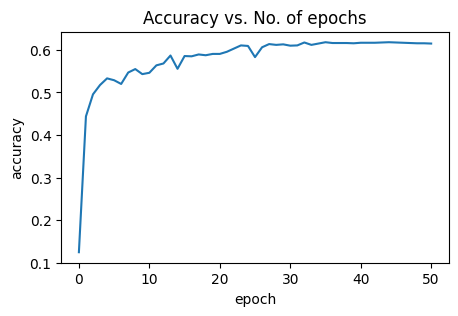

In [19]:
epochs = 50
max_lr = 0.001
decay_epochs = [25,40]
grad_clip = 0.1
weight_decay = 1e-6
kwargs = {'nesterov':True,'momentum':0.9}
opt_func = torch.optim.SGD
loss = F.cross_entropy
dataset = 'ODIR_Aug_res'
output_dir = 'outputs_TL/Vgg16'
os.makedirs(output_dir,exist_ok=True)
model = model_ft.cuda()
model_parameters = model.classifier.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Vgg_tl_allfc_{dataset}'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit(epochs=epochs,max_lr=max_lr,loss_func=loss,model = model,model_parameters=model_parameters,train_loader=train_loader,val_loader=val_loader,model_name=model_name,decay_epochs=decay_epochs,optimizer=opt_func,output_dir=output_dir,**kwargs)


logger(model_name,history,{'Dataset':dataset,'BaseModel':'vgg16_fcs',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'},root = output_dir)

plot = Plots(history,model_name,root=output_dir)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


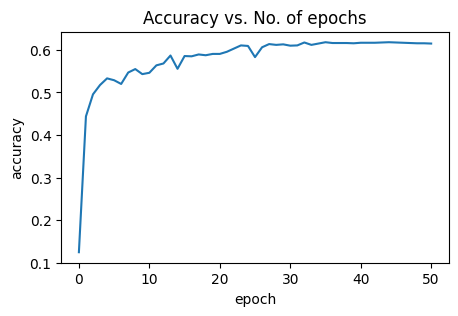

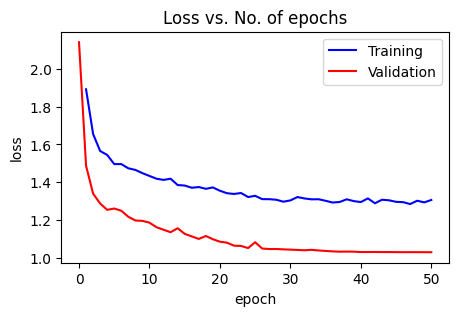

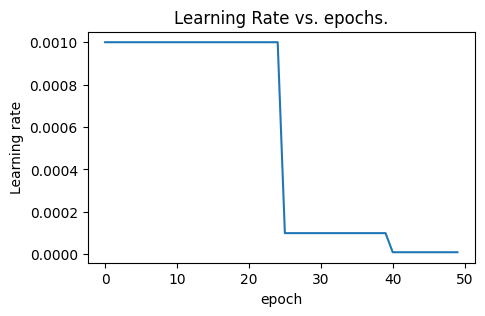

In [21]:
plot = Plots(history,model_name,root=output_dir)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()

### VGG 16 ODIR github 

In [21]:
model_ft = models.vgg16(pretrained=True)
# # Newly created modules have require_grad=True by default
# vgg16
# # Freeze training for all layers
for param in model_ft.parameters():
    param.requires_grad = False
num_features = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_features, len(class_names))

 # Replace the model classifier
# print(list(model_ft.classifier.named_parameters()))
# print(model_ft.classifier)
numel(model_ft,1)

32776

### Normal/baseline form ODIR Github 

[{'val_loss': 2.113868474960327, 'val_acc': 0.1525000035762787}]


100%|██████████| 62/62 [02:49<00:00,  2.73s/it]


Epoch [1], last_lr: 0.00100, train_loss: 1.9036, val_loss: 1.5324, val_acc: 0.4250
best_acc: 0.42500001192092896


100%|██████████| 62/62 [02:57<00:00,  2.87s/it]


Epoch [2], last_lr: 0.00100, train_loss: 1.6880, val_loss: 1.4372, val_acc: 0.4462
best_acc: 0.44624999165534973


100%|██████████| 62/62 [02:28<00:00,  2.40s/it]


Epoch [3], last_lr: 0.00100, train_loss: 1.6382, val_loss: 1.3890, val_acc: 0.4806
best_acc: 0.4806250035762787


100%|██████████| 62/62 [02:26<00:00,  2.37s/it]


Epoch [4], last_lr: 0.00100, train_loss: 1.6147, val_loss: 1.3422, val_acc: 0.5006
best_acc: 0.5006250143051147


100%|██████████| 62/62 [02:23<00:00,  2.32s/it]


Epoch [5], last_lr: 0.00100, train_loss: 1.6030, val_loss: 1.3189, val_acc: 0.5038
best_acc: 0.5037500262260437


100%|██████████| 62/62 [02:29<00:00,  2.41s/it]


Epoch [6], last_lr: 0.00100, train_loss: 1.5902, val_loss: 1.3030, val_acc: 0.5275
best_acc: 0.5274999737739563


100%|██████████| 62/62 [02:36<00:00,  2.52s/it]


Epoch [7], last_lr: 0.00100, train_loss: 1.5698, val_loss: 1.2977, val_acc: 0.5081
best_acc: 0.5274999737739563


100%|██████████| 62/62 [02:27<00:00,  2.38s/it]


Epoch [8], last_lr: 0.00100, train_loss: 1.5892, val_loss: 1.2736, val_acc: 0.5400
best_acc: 0.5400000214576721


100%|██████████| 62/62 [02:30<00:00,  2.43s/it]


Epoch [9], last_lr: 0.00100, train_loss: 1.5496, val_loss: 1.2946, val_acc: 0.5050
best_acc: 0.5400000214576721


100%|██████████| 62/62 [02:27<00:00,  2.38s/it]


Epoch [10], last_lr: 0.00100, train_loss: 1.5736, val_loss: 1.2784, val_acc: 0.5319
best_acc: 0.5400000214576721


100%|██████████| 62/62 [02:37<00:00,  2.53s/it]


Epoch [11], last_lr: 0.00100, train_loss: 1.5704, val_loss: 1.2652, val_acc: 0.5387
best_acc: 0.5400000214576721


100%|██████████| 62/62 [02:27<00:00,  2.38s/it]


Epoch [12], last_lr: 0.00100, train_loss: 1.5646, val_loss: 1.2731, val_acc: 0.5300
best_acc: 0.5400000214576721


100%|██████████| 62/62 [02:26<00:00,  2.36s/it]


Epoch [13], last_lr: 0.00100, train_loss: 1.5606, val_loss: 1.2703, val_acc: 0.5269
best_acc: 0.5400000214576721


100%|██████████| 62/62 [02:30<00:00,  2.42s/it]


Epoch [14], last_lr: 0.00100, train_loss: 1.5750, val_loss: 1.2661, val_acc: 0.5113
best_acc: 0.5400000214576721


100%|██████████| 62/62 [02:27<00:00,  2.38s/it]


Epoch [15], last_lr: 0.00100, train_loss: 1.5663, val_loss: 1.2554, val_acc: 0.5394
best_acc: 0.5400000214576721


100%|██████████| 62/62 [02:39<00:00,  2.57s/it]


Epoch [16], last_lr: 0.00100, train_loss: 1.5567, val_loss: 1.2605, val_acc: 0.5163
best_acc: 0.5400000214576721


100%|██████████| 62/62 [02:45<00:00,  2.67s/it]


Epoch [17], last_lr: 0.00100, train_loss: 1.5471, val_loss: 1.2402, val_acc: 0.5444
best_acc: 0.5443750023841858


100%|██████████| 62/62 [02:39<00:00,  2.57s/it]


Epoch [18], last_lr: 0.00100, train_loss: 1.5335, val_loss: 1.2369, val_acc: 0.5425
best_acc: 0.5443750023841858


100%|██████████| 62/62 [02:33<00:00,  2.47s/it]


Epoch [19], last_lr: 0.00100, train_loss: 1.5372, val_loss: 1.2439, val_acc: 0.5319
best_acc: 0.5443750023841858


100%|██████████| 62/62 [02:24<00:00,  2.33s/it]


Epoch [20], last_lr: 0.00100, train_loss: 1.5327, val_loss: 1.2416, val_acc: 0.5331
best_acc: 0.5443750023841858


100%|██████████| 62/62 [02:23<00:00,  2.32s/it]


Epoch [21], last_lr: 0.00100, train_loss: 1.5466, val_loss: 1.2201, val_acc: 0.5569
best_acc: 0.5568749904632568


100%|██████████| 62/62 [02:25<00:00,  2.35s/it]


Epoch [22], last_lr: 0.00100, train_loss: 1.5371, val_loss: 1.2274, val_acc: 0.5425
best_acc: 0.5568749904632568


100%|██████████| 62/62 [02:24<00:00,  2.34s/it]


Epoch [23], last_lr: 0.00100, train_loss: 1.5563, val_loss: 1.2499, val_acc: 0.5219
best_acc: 0.5568749904632568


100%|██████████| 62/62 [02:22<00:00,  2.29s/it]


Epoch [24], last_lr: 0.00100, train_loss: 1.5494, val_loss: 1.2532, val_acc: 0.5431
best_acc: 0.5568749904632568


100%|██████████| 62/62 [02:32<00:00,  2.45s/it]


Epoch [25], last_lr: 0.00100, train_loss: 1.5240, val_loss: 1.2766, val_acc: 0.5450
best_acc: 0.5568749904632568


100%|██████████| 62/62 [02:29<00:00,  2.40s/it]


Epoch [26], last_lr: 0.00010, train_loss: 1.5124, val_loss: 1.2310, val_acc: 0.5494
best_acc: 0.5568749904632568


100%|██████████| 62/62 [02:28<00:00,  2.40s/it]


Epoch [27], last_lr: 0.00010, train_loss: 1.5268, val_loss: 1.2293, val_acc: 0.5494
best_acc: 0.5568749904632568


100%|██████████| 62/62 [02:23<00:00,  2.32s/it]


Epoch [28], last_lr: 0.00010, train_loss: 1.5146, val_loss: 1.2194, val_acc: 0.5537
best_acc: 0.5568749904632568


100%|██████████| 62/62 [02:27<00:00,  2.39s/it]


Epoch [29], last_lr: 0.00010, train_loss: 1.5115, val_loss: 1.2266, val_acc: 0.5562
best_acc: 0.5568749904632568


100%|██████████| 62/62 [02:22<00:00,  2.30s/it]


Epoch [30], last_lr: 0.00010, train_loss: 1.5040, val_loss: 1.2214, val_acc: 0.5625
best_acc: 0.5625


100%|██████████| 62/62 [02:25<00:00,  2.34s/it]


Epoch [31], last_lr: 0.00010, train_loss: 1.5050, val_loss: 1.2188, val_acc: 0.5631
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:24<00:00,  2.34s/it]


Epoch [32], last_lr: 0.00010, train_loss: 1.5376, val_loss: 1.2202, val_acc: 0.5612
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:34<00:00,  2.49s/it]


Epoch [33], last_lr: 0.00010, train_loss: 1.5201, val_loss: 1.2212, val_acc: 0.5550
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:29<00:00,  2.40s/it]


Epoch [34], last_lr: 0.00010, train_loss: 1.5115, val_loss: 1.2212, val_acc: 0.5581
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:27<00:00,  2.38s/it]


Epoch [35], last_lr: 0.00010, train_loss: 1.5215, val_loss: 1.2244, val_acc: 0.5569
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:29<00:00,  2.42s/it]


Epoch [36], last_lr: 0.00010, train_loss: 1.5044, val_loss: 1.2240, val_acc: 0.5494
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:27<00:00,  2.38s/it]


Epoch [37], last_lr: 0.00010, train_loss: 1.5196, val_loss: 1.2200, val_acc: 0.5581
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:26<00:00,  2.36s/it]


Epoch [38], last_lr: 0.00010, train_loss: 1.4810, val_loss: 1.2225, val_acc: 0.5569
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:19<00:00,  2.25s/it]


Epoch [39], last_lr: 0.00010, train_loss: 1.5009, val_loss: 1.2178, val_acc: 0.5625
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:22<00:00,  2.30s/it]


Epoch [40], last_lr: 0.00010, train_loss: 1.4880, val_loss: 1.2244, val_acc: 0.5544
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:22<00:00,  2.29s/it]


Epoch [41], last_lr: 0.00001, train_loss: 1.5055, val_loss: 1.2231, val_acc: 0.5550
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:18<00:00,  2.24s/it]


Epoch [42], last_lr: 0.00001, train_loss: 1.5048, val_loss: 1.2224, val_acc: 0.5562
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:20<00:00,  2.27s/it]


Epoch [43], last_lr: 0.00001, train_loss: 1.4983, val_loss: 1.2213, val_acc: 0.5619
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:22<00:00,  2.29s/it]


Epoch [44], last_lr: 0.00001, train_loss: 1.5160, val_loss: 1.2194, val_acc: 0.5606
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:24<00:00,  2.33s/it]


Epoch [45], last_lr: 0.00001, train_loss: 1.4967, val_loss: 1.2197, val_acc: 0.5600
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:25<00:00,  2.34s/it]


Epoch [46], last_lr: 0.00001, train_loss: 1.5114, val_loss: 1.2191, val_acc: 0.5600
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:33<00:00,  2.47s/it]


Epoch [47], last_lr: 0.00001, train_loss: 1.5082, val_loss: 1.2188, val_acc: 0.5594
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:28<00:00,  2.40s/it]


Epoch [48], last_lr: 0.00001, train_loss: 1.5125, val_loss: 1.2183, val_acc: 0.5594
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:30<00:00,  2.42s/it]


Epoch [49], last_lr: 0.00001, train_loss: 1.4935, val_loss: 1.2185, val_acc: 0.5612
best_acc: 0.5631250143051147


100%|██████████| 62/62 [02:29<00:00,  2.41s/it]


Epoch [50], last_lr: 0.00001, train_loss: 1.5011, val_loss: 1.2181, val_acc: 0.5619
best_acc: 0.5631250143051147


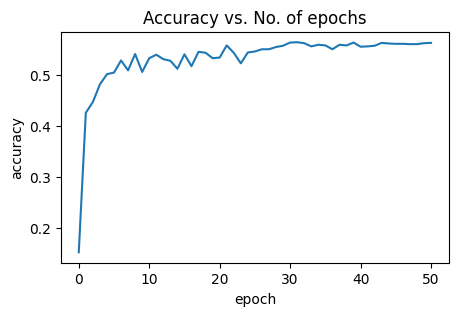

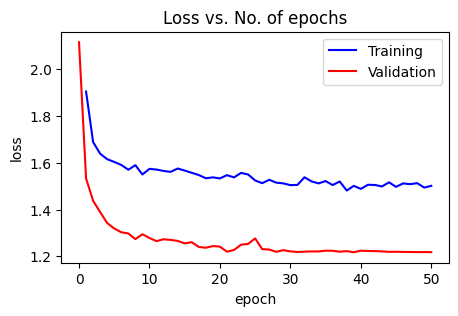

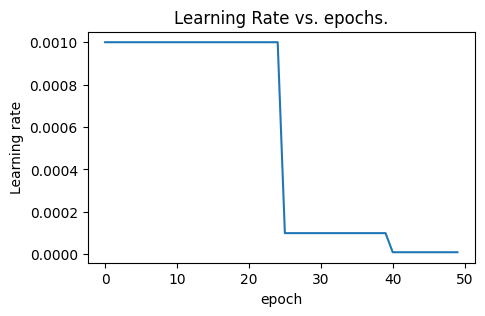

In [22]:
epochs = 50
max_lr = 0.001
decay_epochs = [25,40]
grad_clip = 0.1
weight_decay = 1e-6
kwargs = {'nesterov':True,'momentum':0.9}
opt_func = torch.optim.SGD
loss = F.cross_entropy
dataset = 'ODIR_Aug_res'
output_dir = 'outputs_TL/Vgg16/'
os.makedirs(output_dir,exist_ok=True)
model = model_ft.cuda()
model_parameters = model.classifier[6].parameters()# be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Vgg_tl_baseline_{dataset}'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit(epochs=epochs,max_lr=max_lr,loss_func=loss,model = model,model_parameters=model_parameters,train_loader=train_loader,val_loader=val_loader,model_name=model_name,decay_epochs=decay_epochs,optimizer=opt_func,output_dir=output_dir,**kwargs)

logger(model_name,history,{'Dataset':dataset,'BaseModel':'vgg16_baseline',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'},root=output_dir)

plot = Plots(history,model_name,root=output_dir)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

### Class-wise tau=1.0

### Efficient Net

In [34]:
from efficientnet_pytorch import EfficientNet

In [38]:
model_transfer = EfficientNet.from_pretrained('efficientnet-b4')
 
# print(model_transfer)
# # Freeze weights
for param in model_transfer.parameters():
    param.requires_grad = False
in_features = model_transfer._fc.in_features


# Defining Dense top layers after the convolutional layers
model_transfer._fc = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, len(class_names)),
    )
# if use_cuda:
#     model_transfer = model_transfer.cuda()
# print(model_transfer)

Loaded pretrained weights for efficientnet-b4


In [39]:
numel(model_transfer,1)

989576

[{'val_loss': 2.0777552127838135, 'val_acc': 0.12312500178813934}]


100%|██████████| 62/62 [02:30<00:00,  2.43s/it]


Epoch [1], last_lr: 0.00100, train_loss: 2.0877, val_loss: 1.8530, val_acc: 0.2575
best_acc: 0.2574999928474426


100%|██████████| 62/62 [02:33<00:00,  2.47s/it]


Epoch [2], last_lr: 0.00100, train_loss: 1.8036, val_loss: 1.6393, val_acc: 0.3656
best_acc: 0.3656249940395355


100%|██████████| 62/62 [02:26<00:00,  2.36s/it]


Epoch [3], last_lr: 0.00100, train_loss: 1.6974, val_loss: 1.4818, val_acc: 0.4494
best_acc: 0.4493750035762787


100%|██████████| 62/62 [02:24<00:00,  2.33s/it]


Epoch [4], last_lr: 0.00100, train_loss: 1.6340, val_loss: 1.3911, val_acc: 0.4919
best_acc: 0.4918749928474426


100%|██████████| 62/62 [02:29<00:00,  2.41s/it]


Epoch [5], last_lr: 0.00100, train_loss: 1.6135, val_loss: 1.3385, val_acc: 0.5144
best_acc: 0.5143749713897705


100%|██████████| 62/62 [02:25<00:00,  2.34s/it]


Epoch [6], last_lr: 0.00100, train_loss: 1.5599, val_loss: 1.2949, val_acc: 0.5337
best_acc: 0.5337499976158142


100%|██████████| 62/62 [02:24<00:00,  2.33s/it]


Epoch [7], last_lr: 0.00100, train_loss: 1.5730, val_loss: 1.2665, val_acc: 0.5400
best_acc: 0.5400000214576721


100%|██████████| 62/62 [02:24<00:00,  2.33s/it]


Epoch [8], last_lr: 0.00100, train_loss: 1.5376, val_loss: 1.2426, val_acc: 0.5475
best_acc: 0.5475000143051147


100%|██████████| 62/62 [02:23<00:00,  2.32s/it]


Epoch [9], last_lr: 0.00100, train_loss: 1.5294, val_loss: 1.2221, val_acc: 0.5519
best_acc: 0.5518749952316284


100%|██████████| 62/62 [02:25<00:00,  2.34s/it]


Epoch [10], last_lr: 0.00100, train_loss: 1.4983, val_loss: 1.2133, val_acc: 0.5562
best_acc: 0.5562499761581421


100%|██████████| 62/62 [02:26<00:00,  2.37s/it]


Epoch [11], last_lr: 0.00100, train_loss: 1.4870, val_loss: 1.1915, val_acc: 0.5688
best_acc: 0.5687500238418579


100%|██████████| 62/62 [02:18<00:00,  2.24s/it]


Epoch [12], last_lr: 0.00100, train_loss: 1.4494, val_loss: 1.1793, val_acc: 0.5744
best_acc: 0.5743749737739563


100%|██████████| 62/62 [02:17<00:00,  2.21s/it]


Epoch [13], last_lr: 0.00100, train_loss: 1.4640, val_loss: 1.1737, val_acc: 0.5688
best_acc: 0.5743749737739563


100%|██████████| 62/62 [02:20<00:00,  2.26s/it]


Epoch [14], last_lr: 0.00100, train_loss: 1.4652, val_loss: 1.1554, val_acc: 0.5750
best_acc: 0.574999988079071


100%|██████████| 62/62 [02:13<00:00,  2.15s/it]


Epoch [15], last_lr: 0.00100, train_loss: 1.4516, val_loss: 1.1515, val_acc: 0.5825
best_acc: 0.5824999809265137


100%|██████████| 62/62 [02:22<00:00,  2.30s/it]


Epoch [16], last_lr: 0.00100, train_loss: 1.4771, val_loss: 1.1407, val_acc: 0.5875
best_acc: 0.5874999761581421


100%|██████████| 62/62 [02:22<00:00,  2.30s/it]


Epoch [17], last_lr: 0.00100, train_loss: 1.4503, val_loss: 1.1321, val_acc: 0.5944
best_acc: 0.5943750143051147


100%|██████████| 62/62 [02:20<00:00,  2.26s/it]


Epoch [18], last_lr: 0.00100, train_loss: 1.4291, val_loss: 1.1289, val_acc: 0.5900
best_acc: 0.5943750143051147


100%|██████████| 62/62 [02:23<00:00,  2.31s/it]


Epoch [19], last_lr: 0.00100, train_loss: 1.4378, val_loss: 1.1209, val_acc: 0.6050
best_acc: 0.6050000190734863


100%|██████████| 62/62 [02:27<00:00,  2.38s/it]


Epoch [20], last_lr: 0.00100, train_loss: 1.4356, val_loss: 1.1160, val_acc: 0.6044
best_acc: 0.6050000190734863


100%|██████████| 62/62 [02:20<00:00,  2.26s/it]


Epoch [21], last_lr: 0.00100, train_loss: 1.4252, val_loss: 1.1119, val_acc: 0.6094
best_acc: 0.609375


100%|██████████| 62/62 [02:24<00:00,  2.33s/it]


Epoch [22], last_lr: 0.00100, train_loss: 1.4300, val_loss: 1.1077, val_acc: 0.6081
best_acc: 0.609375


100%|██████████| 62/62 [02:19<00:00,  2.25s/it]


Epoch [23], last_lr: 0.00100, train_loss: 1.4395, val_loss: 1.0987, val_acc: 0.6081
best_acc: 0.609375


100%|██████████| 62/62 [02:18<00:00,  2.23s/it]


Epoch [24], last_lr: 0.00100, train_loss: 1.4030, val_loss: 1.0973, val_acc: 0.6081
best_acc: 0.609375


100%|██████████| 62/62 [02:17<00:00,  2.22s/it]


Epoch [25], last_lr: 0.00100, train_loss: 1.3933, val_loss: 1.0932, val_acc: 0.6106
best_acc: 0.6106250286102295


100%|██████████| 62/62 [02:21<00:00,  2.28s/it]


Epoch [26], last_lr: 0.00010, train_loss: 1.4195, val_loss: 1.0919, val_acc: 0.6094
best_acc: 0.6106250286102295


100%|██████████| 62/62 [02:20<00:00,  2.26s/it]


Epoch [27], last_lr: 0.00010, train_loss: 1.3895, val_loss: 1.0929, val_acc: 0.6106
best_acc: 0.6106250286102295


100%|██████████| 62/62 [02:19<00:00,  2.25s/it]


Epoch [28], last_lr: 0.00010, train_loss: 1.4016, val_loss: 1.0925, val_acc: 0.6094
best_acc: 0.6106250286102295


100%|██████████| 62/62 [02:19<00:00,  2.26s/it]


Epoch [29], last_lr: 0.00010, train_loss: 1.3990, val_loss: 1.0917, val_acc: 0.6150
best_acc: 0.6150000095367432


100%|██████████| 62/62 [02:16<00:00,  2.21s/it]


Epoch [30], last_lr: 0.00010, train_loss: 1.3919, val_loss: 1.0901, val_acc: 0.6137
best_acc: 0.6150000095367432


100%|██████████| 62/62 [02:20<00:00,  2.27s/it]


Epoch [31], last_lr: 0.00010, train_loss: 1.3937, val_loss: 1.0902, val_acc: 0.6137
best_acc: 0.6150000095367432


100%|██████████| 62/62 [02:17<00:00,  2.23s/it]


Epoch [32], last_lr: 0.00010, train_loss: 1.3904, val_loss: 1.0892, val_acc: 0.6100
best_acc: 0.6150000095367432


100%|██████████| 62/62 [02:15<00:00,  2.19s/it]


Epoch [33], last_lr: 0.00010, train_loss: 1.4064, val_loss: 1.0859, val_acc: 0.6144
best_acc: 0.6150000095367432


100%|██████████| 62/62 [02:13<00:00,  2.16s/it]


Epoch [34], last_lr: 0.00010, train_loss: 1.4179, val_loss: 1.0864, val_acc: 0.6112
best_acc: 0.6150000095367432


100%|██████████| 62/62 [02:22<00:00,  2.29s/it]


Epoch [35], last_lr: 0.00010, train_loss: 1.3975, val_loss: 1.0861, val_acc: 0.6150
best_acc: 0.6150000095367432


100%|██████████| 62/62 [02:47<00:00,  2.70s/it]


Epoch [36], last_lr: 0.00010, train_loss: 1.3985, val_loss: 1.0880, val_acc: 0.6150
best_acc: 0.6150000095367432


100%|██████████| 62/62 [02:44<00:00,  2.66s/it]


Epoch [37], last_lr: 0.00010, train_loss: 1.3721, val_loss: 1.0880, val_acc: 0.6181
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:27<00:00,  2.38s/it]


Epoch [38], last_lr: 0.00010, train_loss: 1.4124, val_loss: 1.0855, val_acc: 0.6137
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:22<00:00,  2.30s/it]


Epoch [39], last_lr: 0.00010, train_loss: 1.3998, val_loss: 1.0867, val_acc: 0.6144
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:19<00:00,  2.25s/it]


Epoch [40], last_lr: 0.00010, train_loss: 1.3957, val_loss: 1.0855, val_acc: 0.6150
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:40<00:00,  2.59s/it]


Epoch [41], last_lr: 0.00001, train_loss: 1.4017, val_loss: 1.0843, val_acc: 0.6162
best_acc: 0.6181250214576721


100%|██████████| 62/62 [03:00<00:00,  2.92s/it]


Epoch [42], last_lr: 0.00001, train_loss: 1.4170, val_loss: 1.0826, val_acc: 0.6156
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:25<00:00,  2.34s/it]


Epoch [43], last_lr: 0.00001, train_loss: 1.3817, val_loss: 1.0837, val_acc: 0.6156
best_acc: 0.6181250214576721


100%|██████████| 62/62 [02:21<00:00,  2.29s/it]


Epoch [44], last_lr: 0.00001, train_loss: 1.3917, val_loss: 1.0827, val_acc: 0.6187
best_acc: 0.6187499761581421


100%|██████████| 62/62 [02:18<00:00,  2.23s/it]


Epoch [45], last_lr: 0.00001, train_loss: 1.3903, val_loss: 1.0826, val_acc: 0.6169
best_acc: 0.6187499761581421


100%|██████████| 62/62 [02:20<00:00,  2.26s/it]


Epoch [46], last_lr: 0.00001, train_loss: 1.4151, val_loss: 1.0830, val_acc: 0.6150
best_acc: 0.6187499761581421


100%|██████████| 62/62 [02:18<00:00,  2.24s/it]


Epoch [47], last_lr: 0.00001, train_loss: 1.3843, val_loss: 1.0845, val_acc: 0.6150
best_acc: 0.6187499761581421


100%|██████████| 62/62 [02:26<00:00,  2.36s/it]


Epoch [48], last_lr: 0.00001, train_loss: 1.3663, val_loss: 1.0838, val_acc: 0.6162
best_acc: 0.6187499761581421


100%|██████████| 62/62 [02:23<00:00,  2.32s/it]


Epoch [49], last_lr: 0.00001, train_loss: 1.4007, val_loss: 1.0836, val_acc: 0.6169
best_acc: 0.6187499761581421


100%|██████████| 62/62 [02:33<00:00,  2.48s/it]


Epoch [50], last_lr: 0.00001, train_loss: 1.4039, val_loss: 1.0841, val_acc: 0.6125
best_acc: 0.6187499761581421


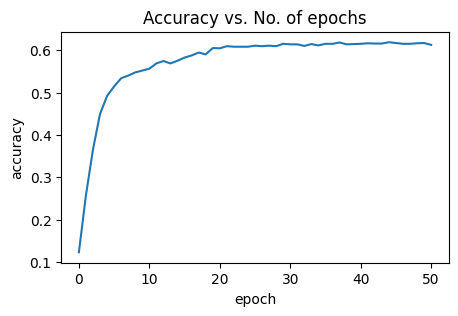

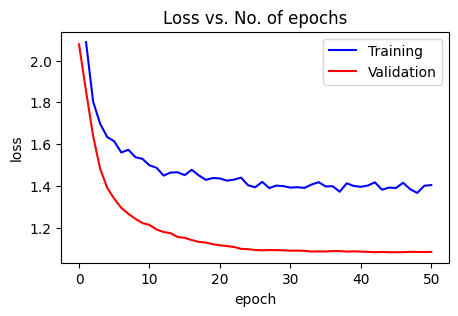

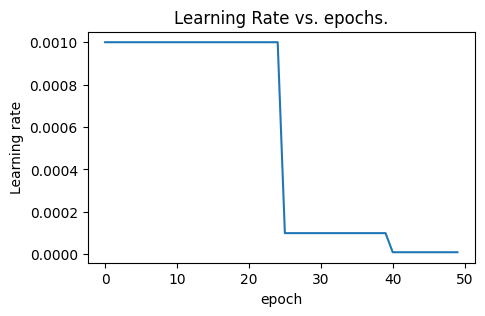

In [40]:
epochs = 50
max_lr = 0.001
decay_epochs = [25,40]
grad_clip = 0.1
weight_decay = 1e-6
kwargs = {'nesterov':True,'momentum':0.9}
opt_func = torch.optim.SGD
loss = F.cross_entropy
dataset = 'ODIR_Aug_res'
output_dir = 'outputs_TL/Eff_b4/'
os.makedirs(output_dir,exist_ok=True)
model = model_transfer.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'EffNet_tl_{dataset}'
history = [evaluate(model, val_loader,loss)]
print(history)

# print(history)
history += fit(epochs=epochs,max_lr=max_lr,loss_func=loss,model = model,model_parameters=model_parameters,train_loader=train_loader,val_loader=val_loader,model_name=model_name,decay_epochs=decay_epochs,optimizer=opt_func,output_dir=output_dir,**kwargs)

logger(model_name,history,{'Dataset':dataset,'BaseModel':'EffNet+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'},root=output_dir)

plot = Plots(history,model_name,root=output_dir)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

### Efficient net with Class-wise loss

In [15]:
epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'ODIR_Aug'
model = model_transfer.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'EffNet_tl_{dataset}_class_wise'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit_class_wise_loss_avg(epochs = epochs, max_lr= max_lr, loss_func= loss, model = model, model_parameters = model_parameters,train_loader = train_loader, val_loader = val_loader, model_name=model_name,decay_epochs=decay_epochs,class_names=class_names)

torch.save(model_ft.state_dict(),f'{model_name}.pth')
logger(model_name,history,{'Dataset':dataset,'BaseModel':'EffNet+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

KeyboardInterrupt: 

In [20]:
del model_transfer, model
torch.cuda.empty_cache()

## Resnet50

In [10]:
model_res = models.resnet50(pretrained=True)
# # Freeze weights
for param in model_res.parameters():
    param.requires_grad = False
in_features = model_res.fc.in_features


# Defining Dense top layers after the convolutional layers
model_res.fc = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, len(class_names)),
    )
# print(model_res)

/data1/khadga/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data1/khadga/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/akshay/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 102MB/s] 


In [11]:
numel(model_res,1)

1121160

[{'val_loss': 2.0828857421875, 'val_acc': 0.1262499988079071}]


100%|██████████| 62/62 [02:24<00:00,  2.33s/it]


Epoch [1], last_lr: 0.00100, train_loss: 1.8009, val_loss: 1.3529, val_acc: 0.5050
best_acc: 0.5049999952316284


100%|██████████| 62/62 [02:19<00:00,  2.25s/it]


Epoch [2], last_lr: 0.00100, train_loss: 1.5386, val_loss: 1.2320, val_acc: 0.5694
best_acc: 0.5693749785423279


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [3], last_lr: 0.00100, train_loss: 1.4759, val_loss: 1.1769, val_acc: 0.5888
best_acc: 0.5887500047683716


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [4], last_lr: 0.00100, train_loss: 1.3858, val_loss: 1.1332, val_acc: 0.6019
best_acc: 0.6018750071525574


100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


Epoch [5], last_lr: 0.00100, train_loss: 1.3821, val_loss: 1.1025, val_acc: 0.6200
best_acc: 0.6200000047683716


100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


Epoch [6], last_lr: 0.00100, train_loss: 1.3428, val_loss: 1.0894, val_acc: 0.6194
best_acc: 0.6200000047683716


100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


Epoch [7], last_lr: 0.00100, train_loss: 1.3437, val_loss: 1.0779, val_acc: 0.6319
best_acc: 0.6318749785423279


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [8], last_lr: 0.00100, train_loss: 1.3166, val_loss: 1.0604, val_acc: 0.6256
best_acc: 0.6318749785423279


100%|██████████| 62/62 [02:11<00:00,  2.11s/it]


Epoch [9], last_lr: 0.00100, train_loss: 1.2918, val_loss: 1.0539, val_acc: 0.6156
best_acc: 0.6318749785423279


100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


Epoch [10], last_lr: 0.00100, train_loss: 1.2729, val_loss: 1.0269, val_acc: 0.6294
best_acc: 0.6318749785423279


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [11], last_lr: 0.00100, train_loss: 1.2675, val_loss: 1.0210, val_acc: 0.6363
best_acc: 0.6362500190734863


100%|██████████| 62/62 [02:12<00:00,  2.13s/it]


Epoch [12], last_lr: 0.00100, train_loss: 1.2500, val_loss: 0.9984, val_acc: 0.6419
best_acc: 0.6418750286102295


100%|██████████| 62/62 [02:12<00:00,  2.13s/it]


Epoch [13], last_lr: 0.00100, train_loss: 1.2560, val_loss: 0.9936, val_acc: 0.6475
best_acc: 0.6474999785423279


100%|██████████| 62/62 [02:14<00:00,  2.17s/it]


Epoch [14], last_lr: 0.00100, train_loss: 1.2134, val_loss: 0.9952, val_acc: 0.6400
best_acc: 0.6474999785423279


100%|██████████| 62/62 [02:09<00:00,  2.08s/it]


Epoch [15], last_lr: 0.00100, train_loss: 1.2182, val_loss: 0.9660, val_acc: 0.6494
best_acc: 0.6493750214576721


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [16], last_lr: 0.00100, train_loss: 1.2309, val_loss: 0.9541, val_acc: 0.6475
best_acc: 0.6493750214576721


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [17], last_lr: 0.00100, train_loss: 1.2050, val_loss: 0.9561, val_acc: 0.6513
best_acc: 0.6512500047683716


100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


Epoch [18], last_lr: 0.00100, train_loss: 1.1909, val_loss: 0.9475, val_acc: 0.6575
best_acc: 0.6575000286102295


100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


Epoch [19], last_lr: 0.00100, train_loss: 1.2017, val_loss: 0.9378, val_acc: 0.6625
best_acc: 0.6625000238418579


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [20], last_lr: 0.00100, train_loss: 1.1739, val_loss: 0.9453, val_acc: 0.6637
best_acc: 0.6637499928474426


100%|██████████| 62/62 [02:09<00:00,  2.08s/it]


Epoch [21], last_lr: 0.00100, train_loss: 1.1647, val_loss: 0.9220, val_acc: 0.6837
best_acc: 0.6837499737739563


100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


Epoch [22], last_lr: 0.00100, train_loss: 1.2023, val_loss: 0.9208, val_acc: 0.6700
best_acc: 0.6837499737739563


100%|██████████| 62/62 [02:15<00:00,  2.18s/it]


Epoch [23], last_lr: 0.00100, train_loss: 1.1792, val_loss: 0.9300, val_acc: 0.6644
best_acc: 0.6837499737739563


100%|██████████| 62/62 [02:15<00:00,  2.18s/it]


Epoch [24], last_lr: 0.00100, train_loss: 1.1829, val_loss: 0.9058, val_acc: 0.6831
best_acc: 0.6837499737739563


100%|██████████| 62/62 [02:11<00:00,  2.12s/it]


Epoch [25], last_lr: 0.00100, train_loss: 1.1821, val_loss: 0.9098, val_acc: 0.6794
best_acc: 0.6837499737739563


100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


Epoch [26], last_lr: 0.00010, train_loss: 1.1370, val_loss: 0.9023, val_acc: 0.6856
best_acc: 0.6856250166893005


100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


Epoch [27], last_lr: 0.00010, train_loss: 1.1358, val_loss: 0.8940, val_acc: 0.6925
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:13<00:00,  2.15s/it]


Epoch [28], last_lr: 0.00010, train_loss: 1.1383, val_loss: 0.8928, val_acc: 0.6831
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [29], last_lr: 0.00010, train_loss: 1.1301, val_loss: 0.8939, val_acc: 0.6831
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:09<00:00,  2.08s/it]


Epoch [30], last_lr: 0.00010, train_loss: 1.1557, val_loss: 0.8949, val_acc: 0.6831
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:09<00:00,  2.08s/it]


Epoch [31], last_lr: 0.00010, train_loss: 1.1337, val_loss: 0.8948, val_acc: 0.6737
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


Epoch [32], last_lr: 0.00010, train_loss: 1.1199, val_loss: 0.8896, val_acc: 0.6837
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [33], last_lr: 0.00010, train_loss: 1.1230, val_loss: 0.8867, val_acc: 0.6837
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:17<00:00,  2.21s/it]


Epoch [34], last_lr: 0.00010, train_loss: 1.1305, val_loss: 0.8823, val_acc: 0.6875
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:12<00:00,  2.13s/it]


Epoch [35], last_lr: 0.00010, train_loss: 1.1187, val_loss: 0.8866, val_acc: 0.6913
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:12<00:00,  2.14s/it]


Epoch [36], last_lr: 0.00010, train_loss: 1.1220, val_loss: 0.8806, val_acc: 0.6850
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:11<00:00,  2.11s/it]


Epoch [37], last_lr: 0.00010, train_loss: 1.1179, val_loss: 0.8797, val_acc: 0.6856
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:36<00:00,  2.53s/it]


Epoch [38], last_lr: 0.00010, train_loss: 1.1206, val_loss: 0.8782, val_acc: 0.6888
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:11<00:00,  2.12s/it]


Epoch [39], last_lr: 0.00010, train_loss: 1.1175, val_loss: 0.8715, val_acc: 0.6906
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:13<00:00,  2.15s/it]


Epoch [40], last_lr: 0.00010, train_loss: 1.1064, val_loss: 0.8727, val_acc: 0.6906
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:09<00:00,  2.08s/it]


Epoch [41], last_lr: 0.00001, train_loss: 1.1416, val_loss: 0.8807, val_acc: 0.6888
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


Epoch [42], last_lr: 0.00001, train_loss: 1.1092, val_loss: 0.8750, val_acc: 0.6913
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:09<00:00,  2.08s/it]


Epoch [43], last_lr: 0.00001, train_loss: 1.1339, val_loss: 0.8798, val_acc: 0.6894
best_acc: 0.6924999952316284


100%|██████████| 62/62 [02:10<00:00,  2.11s/it]


Epoch [44], last_lr: 0.00001, train_loss: 1.1282, val_loss: 0.8763, val_acc: 0.6969
best_acc: 0.6968749761581421


100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


Epoch [45], last_lr: 0.00001, train_loss: 1.1183, val_loss: 0.8775, val_acc: 0.6938
best_acc: 0.6968749761581421


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


Epoch [46], last_lr: 0.00001, train_loss: 1.1267, val_loss: 0.8764, val_acc: 0.6900
best_acc: 0.6968749761581421


100%|██████████| 62/62 [02:13<00:00,  2.15s/it]


Epoch [47], last_lr: 0.00001, train_loss: 1.1169, val_loss: 0.8834, val_acc: 0.6925
best_acc: 0.6968749761581421


100%|██████████| 62/62 [02:16<00:00,  2.20s/it]


Epoch [48], last_lr: 0.00001, train_loss: 1.1113, val_loss: 0.8636, val_acc: 0.6956
best_acc: 0.6968749761581421


100%|██████████| 62/62 [02:16<00:00,  2.20s/it]


Epoch [49], last_lr: 0.00001, train_loss: 1.1184, val_loss: 0.8716, val_acc: 0.6919
best_acc: 0.6968749761581421


100%|██████████| 62/62 [02:10<00:00,  2.11s/it]


Epoch [50], last_lr: 0.00001, train_loss: 1.1082, val_loss: 0.8762, val_acc: 0.6831
best_acc: 0.6968749761581421


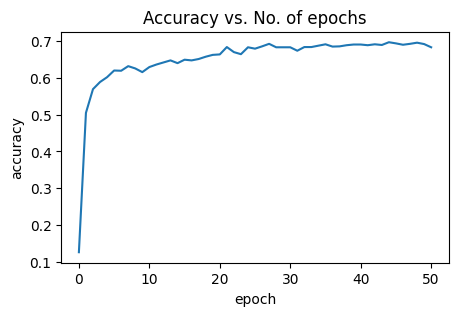

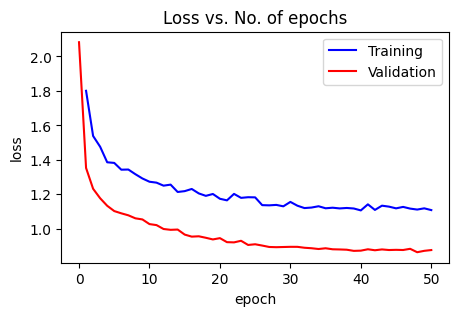

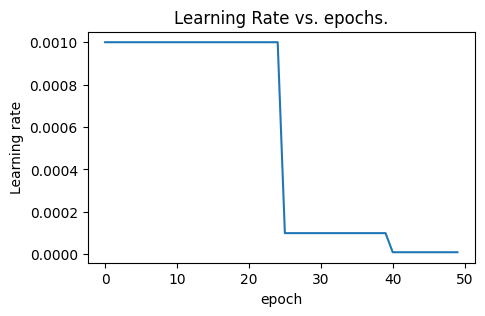

In [12]:
epochs = 50
max_lr = 0.001
decay_epochs = [25,40]
grad_clip = 0.1
weight_decay = 1e-6
kwargs = {'nesterov':True,'momentum':0.9}
opt_func = torch.optim.SGD
loss = F.cross_entropy
dataset = 'ODIR_Aug_res'
output_dir = 'outputs_TL/Res50/'
os.makedirs(output_dir,exist_ok=True)
model = model_res.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Res50_tl_{dataset}'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit(epochs=epochs,max_lr=max_lr,loss_func=loss,model = model,model_parameters=model_parameters,train_loader=train_loader,val_loader=val_loader,model_name=model_name,decay_epochs=decay_epochs,optimizer=opt_func,output_dir=output_dir,**kwargs)

logger(model_name,history,{'Dataset':dataset,'BaseModel':'Res50+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'},root=output_dir)

plot = Plots(history,model_name,root=output_dir)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

### Resnet50 with class_Wise loss

In [32]:
epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'ODIR_Aug'
model = model_res.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Res50_tl_{dataset}_class_wise'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit_class_wise_loss_avg(epochs = epochs, max_lr= max_lr, loss_func= loss, model = model, model_parameters = model_parameters,train_loader = train_loader, val_loader = val_loader, model_name=model_name,decay_epochs=decay_epochs,class_names=class_names)

logger(model_name,history,{'Dataset':dataset,'BaseModel':'Res50+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

[{'val_loss': 2.0784547328948975, 'val_acc': 0.1287499964237213}]


100%|██████████| 200/200 [07:47<00:00,  2.34s/it]


Epoch [1], last_lr: 0.01000, train_loss: 1.6613, val_loss: 1.3193, val_acc: 0.5337
best_acc: 0.5337499976158142


100%|██████████| 200/200 [06:14<00:00,  1.87s/it]


Epoch [2], last_lr: 0.01000, train_loss: 1.6028, val_loss: 1.2477, val_acc: 0.5412
best_acc: 0.5412499904632568


100%|██████████| 200/200 [06:12<00:00,  1.86s/it]


Epoch [3], last_lr: 0.01000, train_loss: 1.5434, val_loss: 1.2150, val_acc: 0.5612
best_acc: 0.5612499713897705


100%|██████████| 200/200 [06:16<00:00,  1.88s/it]


Epoch [4], last_lr: 0.01000, train_loss: 1.4697, val_loss: 1.1620, val_acc: 0.5875
best_acc: 0.5874999761581421


100%|██████████| 200/200 [06:14<00:00,  1.87s/it]


Epoch [5], last_lr: 0.01000, train_loss: 1.4490, val_loss: 1.1215, val_acc: 0.6000
best_acc: 0.6000000238418579


100%|██████████| 200/200 [06:17<00:00,  1.89s/it]


Epoch [6], last_lr: 0.00100, train_loss: 1.4071, val_loss: 1.1189, val_acc: 0.6025
best_acc: 0.6025000214576721


100%|██████████| 200/200 [06:19<00:00,  1.90s/it]


Epoch [7], last_lr: 0.00100, train_loss: 1.4163, val_loss: 1.1198, val_acc: 0.6087
best_acc: 0.6087499856948853


100%|██████████| 200/200 [06:21<00:00,  1.91s/it]


Epoch [8], last_lr: 0.00100, train_loss: 1.4056, val_loss: 1.1159, val_acc: 0.6025
best_acc: 0.6087499856948853


100%|██████████| 200/200 [06:28<00:00,  1.94s/it]


Epoch [9], last_lr: 0.00100, train_loss: 1.4098, val_loss: 1.1045, val_acc: 0.6037
best_acc: 0.6087499856948853


100%|██████████| 200/200 [06:18<00:00,  1.89s/it]


Epoch [10], last_lr: 0.00100, train_loss: 1.3847, val_loss: 1.1055, val_acc: 0.6037
best_acc: 0.6087499856948853


100%|██████████| 200/200 [06:17<00:00,  1.89s/it]


Epoch [11], last_lr: 0.00100, train_loss: 1.3843, val_loss: 1.1045, val_acc: 0.6037
best_acc: 0.6087499856948853


100%|██████████| 200/200 [06:17<00:00,  1.89s/it]


Epoch [12], last_lr: 0.00100, train_loss: 1.3705, val_loss: 1.0914, val_acc: 0.6175
best_acc: 0.6175000071525574


100%|██████████| 200/200 [06:15<00:00,  1.88s/it]


Epoch [13], last_lr: 0.00100, train_loss: 1.3528, val_loss: 1.1001, val_acc: 0.6100
best_acc: 0.6175000071525574


100%|██████████| 200/200 [06:11<00:00,  1.86s/it]


Epoch [14], last_lr: 0.00100, train_loss: 1.3711, val_loss: 1.0874, val_acc: 0.6025
best_acc: 0.6175000071525574


100%|██████████| 200/200 [06:15<00:00,  1.88s/it]


Epoch [15], last_lr: 0.00100, train_loss: 1.3728, val_loss: 1.0828, val_acc: 0.6137
best_acc: 0.6175000071525574


100%|██████████| 200/200 [06:15<00:00,  1.88s/it]


Epoch [16], last_lr: 0.00010, train_loss: 1.3561, val_loss: 1.0980, val_acc: 0.6075
best_acc: 0.6175000071525574


100%|██████████| 200/200 [06:27<00:00,  1.94s/it]


Epoch [17], last_lr: 0.00010, train_loss: 1.3625, val_loss: 1.0888, val_acc: 0.6100
best_acc: 0.6175000071525574


100%|██████████| 200/200 [06:20<00:00,  1.90s/it]


Epoch [18], last_lr: 0.00010, train_loss: 1.3455, val_loss: 1.0799, val_acc: 0.6087
best_acc: 0.6175000071525574


100%|██████████| 200/200 [06:16<00:00,  1.88s/it]


Epoch [19], last_lr: 0.00010, train_loss: 1.3243, val_loss: 1.0855, val_acc: 0.6050
best_acc: 0.6175000071525574


100%|██████████| 200/200 [06:10<00:00,  1.85s/it]


Epoch [20], last_lr: 0.00010, train_loss: 1.3581, val_loss: 1.0807, val_acc: 0.6075
best_acc: 0.6175000071525574


100%|██████████| 200/200 [06:15<00:00,  1.88s/it]


Epoch [21], last_lr: 0.00010, train_loss: 1.3402, val_loss: 1.0734, val_acc: 0.6137
best_acc: 0.6175000071525574


100%|██████████| 200/200 [06:14<00:00,  1.87s/it]


Epoch [22], last_lr: 0.00010, train_loss: 1.3456, val_loss: 1.0900, val_acc: 0.6062
best_acc: 0.6175000071525574


100%|██████████| 200/200 [06:16<00:00,  1.88s/it]


Epoch [23], last_lr: 0.00010, train_loss: 1.3696, val_loss: 1.0856, val_acc: 0.6225
best_acc: 0.6225000023841858


100%|██████████| 200/200 [06:13<00:00,  1.87s/it]


Epoch [24], last_lr: 0.00010, train_loss: 1.3465, val_loss: 1.0775, val_acc: 0.6050
best_acc: 0.6225000023841858


100%|██████████| 200/200 [06:22<00:00,  1.91s/it]


Epoch [25], last_lr: 0.00010, train_loss: 1.3629, val_loss: 1.0892, val_acc: 0.6125
best_acc: 0.6225000023841858


100%|██████████| 200/200 [06:22<00:00,  1.91s/it]


Epoch [26], last_lr: 0.00001, train_loss: 1.3432, val_loss: 1.0776, val_acc: 0.6200
best_acc: 0.6225000023841858


100%|██████████| 200/200 [06:18<00:00,  1.89s/it]


Epoch [27], last_lr: 0.00001, train_loss: 1.3629, val_loss: 1.0721, val_acc: 0.6162
best_acc: 0.6225000023841858


100%|██████████| 200/200 [06:14<00:00,  1.87s/it]


Epoch [28], last_lr: 0.00001, train_loss: 1.3337, val_loss: 1.0699, val_acc: 0.6175
best_acc: 0.6225000023841858


100%|██████████| 200/200 [06:14<00:00,  1.87s/it]


Epoch [29], last_lr: 0.00001, train_loss: 1.3486, val_loss: 1.0951, val_acc: 0.5987
best_acc: 0.6225000023841858


100%|██████████| 200/200 [06:14<00:00,  1.87s/it]


Epoch [30], last_lr: 0.00001, train_loss: 1.3430, val_loss: 1.0826, val_acc: 0.6062
best_acc: 0.6225000023841858


NameError: name 'model_ft' is not defined

### Resnet50 class-wise tau = 1.5

[{'val_loss': 2.074084520339966, 'val_acc': 0.13875000178813934}]


100%|██████████| 200/200 [09:11<00:00,  2.76s/it]


Epoch [1], last_lr: 0.01000, train_loss: 1.6502, val_loss: 1.3112, val_acc: 0.5312
best_acc: 0.53125


100%|██████████| 200/200 [08:29<00:00,  2.55s/it]


Epoch [2], last_lr: 0.01000, train_loss: 1.6470, val_loss: 1.3143, val_acc: 0.5113
best_acc: 0.53125


100%|██████████| 200/200 [08:33<00:00,  2.57s/it]


Epoch [3], last_lr: 0.01000, train_loss: 1.5637, val_loss: 1.2148, val_acc: 0.5700
best_acc: 0.5699999928474426


100%|██████████| 200/200 [08:17<00:00,  2.49s/it]


Epoch [4], last_lr: 0.01000, train_loss: 1.5304, val_loss: 1.1624, val_acc: 0.5888
best_acc: 0.5887500047683716


100%|██████████| 200/200 [08:35<00:00,  2.58s/it]


Epoch [5], last_lr: 0.01000, train_loss: 1.4783, val_loss: 1.1329, val_acc: 0.6050
best_acc: 0.6050000190734863


100%|██████████| 200/200 [11:25<00:00,  3.43s/it]


Epoch [6], last_lr: 0.00100, train_loss: 1.4536, val_loss: 1.1301, val_acc: 0.5950
best_acc: 0.6050000190734863


100%|██████████| 200/200 [06:30<00:00,  1.95s/it]


Epoch [7], last_lr: 0.00100, train_loss: 1.4311, val_loss: 1.1130, val_acc: 0.6062
best_acc: 0.606249988079071


100%|██████████| 200/200 [06:14<00:00,  1.87s/it]


Epoch [8], last_lr: 0.00100, train_loss: 1.4251, val_loss: 1.1088, val_acc: 0.6062
best_acc: 0.606249988079071


100%|██████████| 200/200 [06:20<00:00,  1.90s/it]


Epoch [9], last_lr: 0.00100, train_loss: 1.4381, val_loss: 1.1101, val_acc: 0.6012
best_acc: 0.606249988079071


100%|██████████| 200/200 [06:23<00:00,  1.92s/it]


Epoch [10], last_lr: 0.00100, train_loss: 1.4110, val_loss: 1.1079, val_acc: 0.6025
best_acc: 0.606249988079071


100%|██████████| 200/200 [06:16<00:00,  1.88s/it]


Epoch [11], last_lr: 0.00100, train_loss: 1.3863, val_loss: 1.0917, val_acc: 0.6200
best_acc: 0.6200000047683716


100%|██████████| 200/200 [06:07<00:00,  1.84s/it]


Epoch [12], last_lr: 0.00100, train_loss: 1.3938, val_loss: 1.0775, val_acc: 0.6300
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:04<00:00,  1.82s/it]


Epoch [13], last_lr: 0.00100, train_loss: 1.3784, val_loss: 1.0771, val_acc: 0.6137
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:05<00:00,  1.83s/it]


Epoch [14], last_lr: 0.00100, train_loss: 1.3745, val_loss: 1.0693, val_acc: 0.6162
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:10<00:00,  1.85s/it]


Epoch [15], last_lr: 0.00100, train_loss: 1.3642, val_loss: 1.0636, val_acc: 0.6187
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:09<00:00,  1.85s/it]


Epoch [16], last_lr: 0.00010, train_loss: 1.4244, val_loss: 1.0720, val_acc: 0.6187
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:01<00:00,  1.81s/it]


Epoch [17], last_lr: 0.00010, train_loss: 1.3839, val_loss: 1.0788, val_acc: 0.6087
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:05<00:00,  1.83s/it]


Epoch [18], last_lr: 0.00010, train_loss: 1.3822, val_loss: 1.0522, val_acc: 0.6237
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:04<00:00,  1.82s/it]


Epoch [19], last_lr: 0.00010, train_loss: 1.3767, val_loss: 1.0598, val_acc: 0.6225
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:06<00:00,  1.83s/it]


Epoch [20], last_lr: 0.00010, train_loss: 1.3855, val_loss: 1.0618, val_acc: 0.6087
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:00<00:00,  1.80s/it]


Epoch [21], last_lr: 0.00010, train_loss: 1.3634, val_loss: 1.0655, val_acc: 0.6112
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:07<00:00,  1.84s/it]


Epoch [22], last_lr: 0.00010, train_loss: 1.3828, val_loss: 1.0532, val_acc: 0.6137
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:05<00:00,  1.83s/it]


Epoch [23], last_lr: 0.00010, train_loss: 1.3593, val_loss: 1.0528, val_acc: 0.6237
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:14<00:00,  1.87s/it]


Epoch [24], last_lr: 0.00010, train_loss: 1.3828, val_loss: 1.0686, val_acc: 0.6075
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:08<00:00,  1.84s/it]


Epoch [25], last_lr: 0.00010, train_loss: 1.3762, val_loss: 1.0770, val_acc: 0.6175
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:06<00:00,  1.83s/it]


Epoch [26], last_lr: 0.00001, train_loss: 1.3918, val_loss: 1.0628, val_acc: 0.6162
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:03<00:00,  1.82s/it]


Epoch [27], last_lr: 0.00001, train_loss: 1.3667, val_loss: 1.0625, val_acc: 0.6200
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:02<00:00,  1.81s/it]


Epoch [28], last_lr: 0.00001, train_loss: 1.3601, val_loss: 1.0629, val_acc: 0.6225
best_acc: 0.6299999952316284


100%|██████████| 200/200 [05:56<00:00,  1.78s/it]


Epoch [29], last_lr: 0.00001, train_loss: 1.3646, val_loss: 1.0634, val_acc: 0.6200
best_acc: 0.6299999952316284


100%|██████████| 200/200 [06:00<00:00,  1.80s/it]


Epoch [30], last_lr: 0.00001, train_loss: 1.3621, val_loss: 1.0691, val_acc: 0.6187
best_acc: 0.6299999952316284


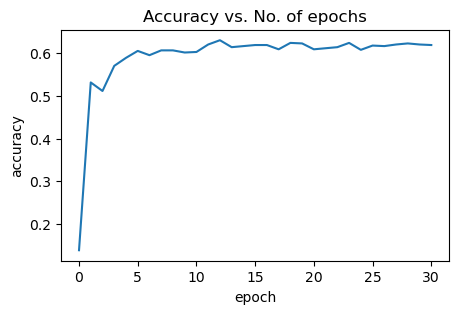

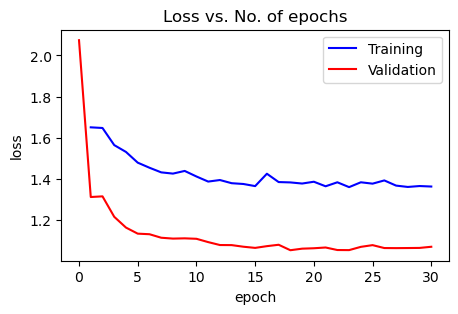

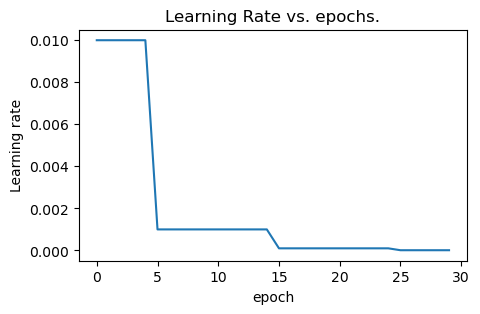

In [42]:
epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'ODIR_Aug'
model = model_res.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Res50_tl_{dataset}_class_wise_t15'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit_class_wise_loss_avg(epochs = epochs, max_lr= max_lr, loss_func= loss, model = model, model_parameters = model_parameters,train_loader = train_loader, val_loader = val_loader, model_name=model_name,decay_epochs=decay_epochs,class_names=class_names,tau=1.5)

logger(model_name,history,{'Dataset':dataset,'BaseModel':'Res50+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

### Resnet50 with tau = 2.0

[{'val_loss': 2.082671880722046, 'val_acc': 0.08624999970197678}]


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


Epoch [1], last_lr: 0.01000, train_loss: 1.6349, val_loss: 1.2813, val_acc: 0.5425
best_acc: 0.5425000190734863


100%|██████████| 200/200 [06:08<00:00,  1.84s/it]


Epoch [2], last_lr: 0.01000, train_loss: 1.7023, val_loss: 1.3257, val_acc: 0.5213
best_acc: 0.5425000190734863


100%|██████████| 200/200 [06:10<00:00,  1.85s/it]


Epoch [3], last_lr: 0.01000, train_loss: 1.6019, val_loss: 1.2202, val_acc: 0.5500
best_acc: 0.550000011920929


100%|██████████| 200/200 [06:11<00:00,  1.86s/it]


Epoch [4], last_lr: 0.01000, train_loss: 1.5139, val_loss: 1.1777, val_acc: 0.5888
best_acc: 0.5887500047683716


100%|██████████| 200/200 [06:08<00:00,  1.84s/it]


Epoch [5], last_lr: 0.01000, train_loss: 1.4933, val_loss: 1.1611, val_acc: 0.5537
best_acc: 0.5887500047683716


100%|██████████| 200/200 [06:03<00:00,  1.82s/it]


Epoch [6], last_lr: 0.00100, train_loss: 1.4403, val_loss: 1.1320, val_acc: 0.5763
best_acc: 0.5887500047683716


100%|██████████| 200/200 [06:13<00:00,  1.87s/it]


Epoch [7], last_lr: 0.00100, train_loss: 1.4578, val_loss: 1.1195, val_acc: 0.5850
best_acc: 0.5887500047683716


100%|██████████| 200/200 [06:08<00:00,  1.84s/it]


Epoch [8], last_lr: 0.00100, train_loss: 1.4314, val_loss: 1.1260, val_acc: 0.5825
best_acc: 0.5887500047683716


100%|██████████| 200/200 [06:36<00:00,  1.98s/it]


Epoch [9], last_lr: 0.00100, train_loss: 1.4451, val_loss: 1.1095, val_acc: 0.5850
best_acc: 0.5887500047683716


100%|██████████| 200/200 [06:10<00:00,  1.85s/it]


Epoch [10], last_lr: 0.00100, train_loss: 1.4246, val_loss: 1.1068, val_acc: 0.5925
best_acc: 0.5924999713897705


100%|██████████| 200/200 [06:06<00:00,  1.83s/it]


Epoch [11], last_lr: 0.00100, train_loss: 1.4146, val_loss: 1.0874, val_acc: 0.6025
best_acc: 0.6025000214576721


100%|██████████| 200/200 [06:11<00:00,  1.86s/it]


Epoch [12], last_lr: 0.00100, train_loss: 1.4156, val_loss: 1.0943, val_acc: 0.5962
best_acc: 0.6025000214576721


100%|██████████| 200/200 [06:08<00:00,  1.84s/it]


Epoch [13], last_lr: 0.00100, train_loss: 1.4050, val_loss: 1.0959, val_acc: 0.5888
best_acc: 0.6025000214576721


100%|██████████| 200/200 [06:10<00:00,  1.85s/it]


Epoch [14], last_lr: 0.00100, train_loss: 1.4172, val_loss: 1.0911, val_acc: 0.6012
best_acc: 0.6025000214576721


100%|██████████| 200/200 [06:06<00:00,  1.83s/it]


Epoch [15], last_lr: 0.00100, train_loss: 1.3778, val_loss: 1.0759, val_acc: 0.6025
best_acc: 0.6025000214576721


100%|██████████| 200/200 [06:12<00:00,  1.86s/it]


Epoch [16], last_lr: 0.00010, train_loss: 1.4034, val_loss: 1.0775, val_acc: 0.5925
best_acc: 0.6025000214576721


100%|██████████| 200/200 [06:25<00:00,  1.93s/it]


Epoch [17], last_lr: 0.00010, train_loss: 1.3803, val_loss: 1.0692, val_acc: 0.5975
best_acc: 0.6025000214576721


100%|██████████| 200/200 [08:18<00:00,  2.49s/it] 


Epoch [18], last_lr: 0.00010, train_loss: 1.4054, val_loss: 1.0951, val_acc: 0.5900
best_acc: 0.6025000214576721


100%|██████████| 200/200 [06:00<00:00,  1.80s/it]


Epoch [19], last_lr: 0.00010, train_loss: 1.4097, val_loss: 1.0826, val_acc: 0.6087
best_acc: 0.6087499856948853


100%|██████████| 200/200 [05:51<00:00,  1.76s/it]


Epoch [20], last_lr: 0.00010, train_loss: 1.3919, val_loss: 1.0774, val_acc: 0.6012
best_acc: 0.6087499856948853


100%|██████████| 200/200 [05:48<00:00,  1.74s/it]


Epoch [21], last_lr: 0.00010, train_loss: 1.3993, val_loss: 1.0600, val_acc: 0.6062
best_acc: 0.6087499856948853


100%|██████████| 200/200 [05:54<00:00,  1.77s/it]


Epoch [22], last_lr: 0.00010, train_loss: 1.4075, val_loss: 1.0741, val_acc: 0.6100
best_acc: 0.6100000143051147


100%|██████████| 200/200 [05:52<00:00,  1.76s/it]


Epoch [23], last_lr: 0.00010, train_loss: 1.4047, val_loss: 1.0652, val_acc: 0.6125
best_acc: 0.612500011920929


100%|██████████| 200/200 [05:47<00:00,  1.74s/it]


Epoch [24], last_lr: 0.00010, train_loss: 1.3921, val_loss: 1.1029, val_acc: 0.5925
best_acc: 0.612500011920929


100%|██████████| 200/200 [05:50<00:00,  1.75s/it]


Epoch [25], last_lr: 0.00010, train_loss: 1.3975, val_loss: 1.0835, val_acc: 0.5987
best_acc: 0.612500011920929


100%|██████████| 200/200 [05:51<00:00,  1.76s/it]


Epoch [26], last_lr: 0.00001, train_loss: 1.3984, val_loss: 1.0845, val_acc: 0.5925
best_acc: 0.612500011920929


100%|██████████| 200/200 [05:53<00:00,  1.77s/it]


Epoch [27], last_lr: 0.00001, train_loss: 1.3723, val_loss: 1.0631, val_acc: 0.6087
best_acc: 0.612500011920929


100%|██████████| 200/200 [05:45<00:00,  1.73s/it]


Epoch [28], last_lr: 0.00001, train_loss: 1.3877, val_loss: 1.0728, val_acc: 0.5925
best_acc: 0.612500011920929


100%|██████████| 200/200 [05:50<00:00,  1.75s/it]


Epoch [29], last_lr: 0.00001, train_loss: 1.3920, val_loss: 1.0773, val_acc: 0.6050
best_acc: 0.612500011920929


100%|██████████| 200/200 [05:45<00:00,  1.73s/it]


Epoch [30], last_lr: 0.00001, train_loss: 1.3910, val_loss: 1.0737, val_acc: 0.5888
best_acc: 0.612500011920929


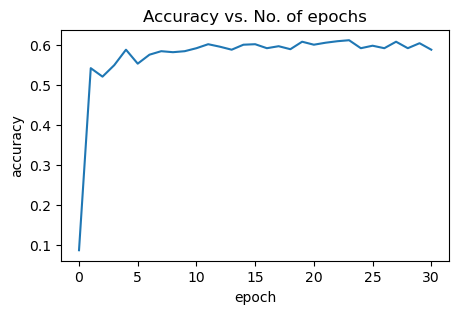

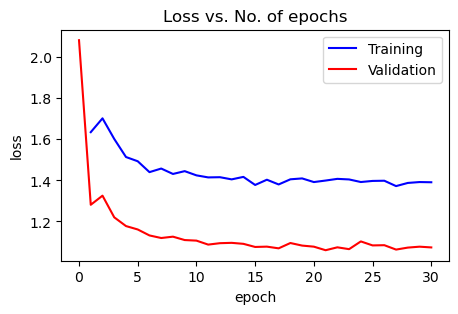

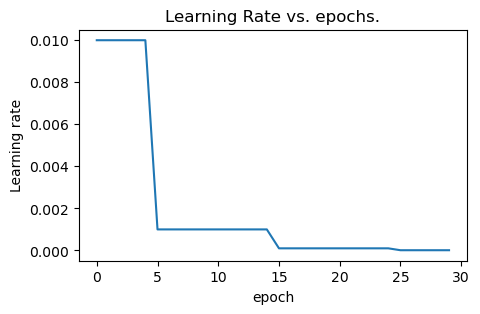

In [92]:
epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'ODIR_Aug'
model = model_res.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Res50_tl_{dataset}_class_wise_t20'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit_class_wise_loss_avg(epochs = epochs, max_lr= max_lr, loss_func= loss, model = model, model_parameters = model_parameters,train_loader = train_loader, val_loader = val_loader, model_name=model_name,decay_epochs=decay_epochs,class_names=class_names,tau=2.0)

logger(model_name,history,{'Dataset':dataset,'BaseModel':'Res50+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

## Class wise loss avg independent

[{'val_loss': 1.3247087001800537, 'val_acc': 0.5362499952316284}]


100%|██████████| 200/200 [03:49<00:00,  1.15s/it]


Epoch [1], last_lr: 0.01000, train_loss: 1.4504, val_loss: 1.2294, val_acc: 0.5663
best_acc: 0.5662500262260437


100%|██████████| 200/200 [03:50<00:00,  1.15s/it]


Epoch [2], last_lr: 0.01000, train_loss: 1.5984, val_loss: 1.2219, val_acc: 0.5700
best_acc: 0.5699999928474426


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]


Epoch [3], last_lr: 0.01000, train_loss: 1.5274, val_loss: 1.1618, val_acc: 0.5863
best_acc: 0.5862500071525574


100%|██████████| 200/200 [03:44<00:00,  1.12s/it]


Epoch [4], last_lr: 0.01000, train_loss: 1.4719, val_loss: 1.1570, val_acc: 0.5763
best_acc: 0.5862500071525574


100%|██████████| 200/200 [03:37<00:00,  1.09s/it]


Epoch [5], last_lr: 0.01000, train_loss: 1.4585, val_loss: 1.1153, val_acc: 0.5962
best_acc: 0.5962499976158142


100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [6], last_lr: 0.00100, train_loss: 1.4111, val_loss: 1.1063, val_acc: 0.5950
best_acc: 0.5962499976158142


100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [7], last_lr: 0.00100, train_loss: 1.3849, val_loss: 1.1070, val_acc: 0.6075
best_acc: 0.6075000166893005


100%|██████████| 200/200 [02:52<00:00,  1.16it/s]


Epoch [8], last_lr: 0.00100, train_loss: 1.3748, val_loss: 1.0889, val_acc: 0.5975
best_acc: 0.6075000166893005


100%|██████████| 200/200 [02:49<00:00,  1.18it/s]


Epoch [9], last_lr: 0.00100, train_loss: 1.3675, val_loss: 1.0844, val_acc: 0.6025
best_acc: 0.6075000166893005


100%|██████████| 200/200 [02:50<00:00,  1.17it/s]


Epoch [10], last_lr: 0.00100, train_loss: 1.3799, val_loss: 1.0841, val_acc: 0.5850
best_acc: 0.6075000166893005


100%|██████████| 200/200 [02:42<00:00,  1.23it/s]


Epoch [11], last_lr: 0.00100, train_loss: 1.3730, val_loss: 1.0785, val_acc: 0.6150
best_acc: 0.6150000095367432


100%|██████████| 200/200 [02:54<00:00,  1.15it/s]


Epoch [12], last_lr: 0.00100, train_loss: 1.3580, val_loss: 1.0833, val_acc: 0.5975
best_acc: 0.6150000095367432


100%|██████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [13], last_lr: 0.00100, train_loss: 1.3607, val_loss: 1.0727, val_acc: 0.6012
best_acc: 0.6150000095367432


100%|██████████| 200/200 [02:51<00:00,  1.16it/s]


Epoch [14], last_lr: 0.00100, train_loss: 1.3437, val_loss: 1.0548, val_acc: 0.6050
best_acc: 0.6150000095367432


100%|██████████| 200/200 [02:40<00:00,  1.24it/s]


Epoch [15], last_lr: 0.00100, train_loss: 1.3681, val_loss: 1.0632, val_acc: 0.6200
best_acc: 0.6200000047683716


100%|██████████| 200/200 [02:47<00:00,  1.20it/s]


Epoch [16], last_lr: 0.00010, train_loss: 1.3606, val_loss: 1.0603, val_acc: 0.6150
best_acc: 0.6200000047683716


100%|██████████| 200/200 [02:54<00:00,  1.15it/s]


Epoch [17], last_lr: 0.00010, train_loss: 1.3518, val_loss: 1.0623, val_acc: 0.6100
best_acc: 0.6200000047683716


100%|██████████| 200/200 [02:40<00:00,  1.24it/s]


Epoch [18], last_lr: 0.00010, train_loss: 1.3526, val_loss: 1.0541, val_acc: 0.6012
best_acc: 0.6200000047683716


100%|██████████| 200/200 [02:40<00:00,  1.25it/s]


Epoch [19], last_lr: 0.00010, train_loss: 1.3408, val_loss: 1.0582, val_acc: 0.6125
best_acc: 0.6200000047683716


100%|██████████| 200/200 [02:41<00:00,  1.24it/s]


Epoch [20], last_lr: 0.00010, train_loss: 1.3309, val_loss: 1.0666, val_acc: 0.6087
best_acc: 0.6200000047683716


100%|██████████| 200/200 [02:41<00:00,  1.24it/s]


Epoch [21], last_lr: 0.00010, train_loss: 1.3577, val_loss: 1.0664, val_acc: 0.6025
best_acc: 0.6200000047683716


100%|██████████| 200/200 [02:41<00:00,  1.24it/s]


Epoch [22], last_lr: 0.00010, train_loss: 1.3567, val_loss: 1.0652, val_acc: 0.6100
best_acc: 0.6200000047683716


100%|██████████| 200/200 [02:42<00:00,  1.23it/s]


Epoch [23], last_lr: 0.00010, train_loss: 1.3230, val_loss: 1.0572, val_acc: 0.6025
best_acc: 0.6200000047683716


100%|██████████| 200/200 [02:51<00:00,  1.17it/s]


Epoch [24], last_lr: 0.00010, train_loss: 1.3293, val_loss: 1.0631, val_acc: 0.6125
best_acc: 0.6200000047683716


100%|██████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [25], last_lr: 0.00010, train_loss: 1.3282, val_loss: 1.0587, val_acc: 0.6087
best_acc: 0.6200000047683716


100%|██████████| 200/200 [02:42<00:00,  1.23it/s]


Epoch [26], last_lr: 0.00001, train_loss: 1.3397, val_loss: 1.0600, val_acc: 0.6062
best_acc: 0.6200000047683716


100%|██████████| 200/200 [02:43<00:00,  1.23it/s]


Epoch [27], last_lr: 0.00001, train_loss: 1.3301, val_loss: 1.0653, val_acc: 0.6250
best_acc: 0.625


100%|██████████| 200/200 [02:42<00:00,  1.23it/s]


Epoch [28], last_lr: 0.00001, train_loss: 1.3381, val_loss: 1.0667, val_acc: 0.6187
best_acc: 0.625


100%|██████████| 200/200 [02:39<00:00,  1.25it/s]


Epoch [29], last_lr: 0.00001, train_loss: 1.3389, val_loss: 1.0560, val_acc: 0.6187
best_acc: 0.625


100%|██████████| 200/200 [02:38<00:00,  1.26it/s]


Epoch [30], last_lr: 0.00001, train_loss: 1.3614, val_loss: 1.0533, val_acc: 0.6100
best_acc: 0.625


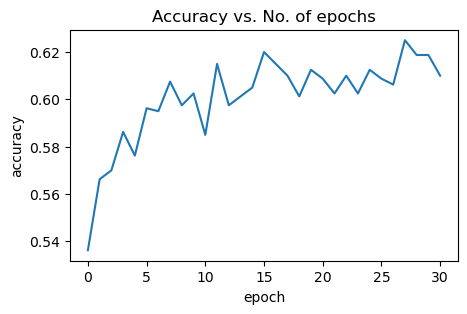

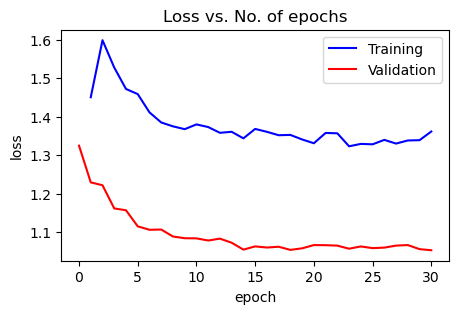

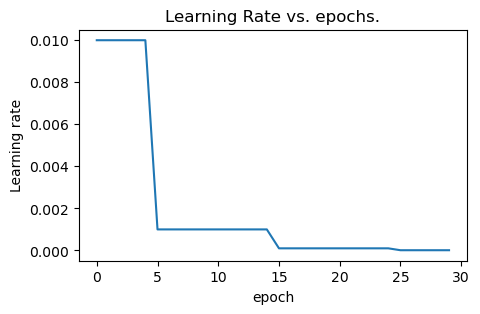

In [22]:
# tau = 1.0

epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'ODIR_Aug'
model = model_res.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Res50_tl_{dataset}_class_wise__ind_t10'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit_class_wise_loss_avg(epochs = epochs, max_lr= max_lr, loss_func= loss, model = model, model_parameters = model_parameters,train_loader = train_loader, val_loader = val_loader, model_name=model_name,decay_epochs=decay_epochs,class_names=class_names,tau=1.0,method='independent')

logger(model_name,history,{'Dataset':dataset,'BaseModel':'Res50+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

[{'val_loss': 2.0917556285858154, 'val_acc': 0.10750000178813934}]


100%|██████████| 200/200 [04:08<00:00,  1.24s/it]


Epoch [1], last_lr: 0.01000, train_loss: 1.6278, val_loss: 1.2975, val_acc: 0.5350
best_acc: 0.5350000262260437


100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


Epoch [2], last_lr: 0.01000, train_loss: 1.6469, val_loss: 1.2465, val_acc: 0.5575
best_acc: 0.5575000047683716


100%|██████████| 200/200 [03:51<00:00,  1.16s/it]


Epoch [3], last_lr: 0.01000, train_loss: 1.5664, val_loss: 1.2156, val_acc: 0.5387
best_acc: 0.5575000047683716


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch [4], last_lr: 0.01000, train_loss: 1.5060, val_loss: 1.1805, val_acc: 0.5362
best_acc: 0.5575000047683716


100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [5], last_lr: 0.01000, train_loss: 1.4783, val_loss: 1.1291, val_acc: 0.5825
best_acc: 0.5824999809265137


100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [6], last_lr: 0.00100, train_loss: 1.4221, val_loss: 1.1152, val_acc: 0.5838
best_acc: 0.5837500095367432


100%|██████████| 200/200 [03:07<00:00,  1.07it/s]


Epoch [7], last_lr: 0.00100, train_loss: 1.4241, val_loss: 1.1081, val_acc: 0.5987
best_acc: 0.5987499952316284


100%|██████████| 200/200 [03:09<00:00,  1.05it/s]


Epoch [8], last_lr: 0.00100, train_loss: 1.4132, val_loss: 1.0944, val_acc: 0.5950
best_acc: 0.5987499952316284


100%|██████████| 200/200 [03:04<00:00,  1.08it/s]


Epoch [9], last_lr: 0.00100, train_loss: 1.4034, val_loss: 1.0962, val_acc: 0.5962
best_acc: 0.5987499952316284


100%|██████████| 200/200 [03:04<00:00,  1.08it/s]


Epoch [10], last_lr: 0.00100, train_loss: 1.3757, val_loss: 1.0773, val_acc: 0.5987
best_acc: 0.5987499952316284


100%|██████████| 200/200 [03:04<00:00,  1.08it/s]


Epoch [11], last_lr: 0.00100, train_loss: 1.3758, val_loss: 1.0877, val_acc: 0.6000
best_acc: 0.6000000238418579


100%|██████████| 200/200 [03:07<00:00,  1.06it/s]


Epoch [12], last_lr: 0.00100, train_loss: 1.3736, val_loss: 1.0851, val_acc: 0.5950
best_acc: 0.6000000238418579


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch [13], last_lr: 0.00100, train_loss: 1.3778, val_loss: 1.0814, val_acc: 0.6050
best_acc: 0.6050000190734863


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch [14], last_lr: 0.00100, train_loss: 1.3917, val_loss: 1.0702, val_acc: 0.6000
best_acc: 0.6050000190734863


100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch [15], last_lr: 0.00100, train_loss: 1.3792, val_loss: 1.0656, val_acc: 0.6037
best_acc: 0.6050000190734863


100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [16], last_lr: 0.00010, train_loss: 1.3654, val_loss: 1.0850, val_acc: 0.6100
best_acc: 0.6100000143051147


100%|██████████| 200/200 [03:09<00:00,  1.05it/s]


Epoch [17], last_lr: 0.00010, train_loss: 1.3821, val_loss: 1.0715, val_acc: 0.6050
best_acc: 0.6100000143051147


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch [18], last_lr: 0.00010, train_loss: 1.3830, val_loss: 1.0679, val_acc: 0.6087
best_acc: 0.6100000143051147


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch [19], last_lr: 0.00010, train_loss: 1.3740, val_loss: 1.0651, val_acc: 0.6025
best_acc: 0.6100000143051147


100%|██████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [20], last_lr: 0.00010, train_loss: 1.3761, val_loss: 1.0638, val_acc: 0.5962
best_acc: 0.6100000143051147


100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch [21], last_lr: 0.00010, train_loss: 1.3481, val_loss: 1.0646, val_acc: 0.6000
best_acc: 0.6100000143051147


100%|██████████| 200/200 [03:04<00:00,  1.08it/s]


Epoch [22], last_lr: 0.00010, train_loss: 1.3445, val_loss: 1.0629, val_acc: 0.6087
best_acc: 0.6100000143051147


100%|██████████| 200/200 [03:26<00:00,  1.03s/it]


Epoch [23], last_lr: 0.00010, train_loss: 1.3501, val_loss: 1.0701, val_acc: 0.5987
best_acc: 0.6100000143051147


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch [24], last_lr: 0.00010, train_loss: 1.3812, val_loss: 1.0608, val_acc: 0.6000
best_acc: 0.6100000143051147


100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


Epoch [25], last_lr: 0.00010, train_loss: 1.3682, val_loss: 1.0671, val_acc: 0.6100
best_acc: 0.6100000143051147


100%|██████████| 200/200 [03:25<00:00,  1.03s/it]


Epoch [26], last_lr: 0.00001, train_loss: 1.3597, val_loss: 1.0688, val_acc: 0.6075
best_acc: 0.6100000143051147


100%|██████████| 200/200 [03:34<00:00,  1.07s/it]


Epoch [27], last_lr: 0.00001, train_loss: 1.3632, val_loss: 1.0647, val_acc: 0.6162
best_acc: 0.6162499785423279


100%|██████████| 200/200 [03:28<00:00,  1.04s/it]


Epoch [28], last_lr: 0.00001, train_loss: 1.3864, val_loss: 1.0607, val_acc: 0.6037
best_acc: 0.6162499785423279


100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [29], last_lr: 0.00001, train_loss: 1.3488, val_loss: 1.0675, val_acc: 0.6025
best_acc: 0.6162499785423279


100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [30], last_lr: 0.00001, train_loss: 1.3575, val_loss: 1.0619, val_acc: 0.6050
best_acc: 0.6162499785423279


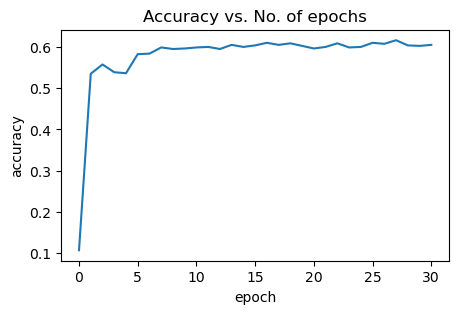

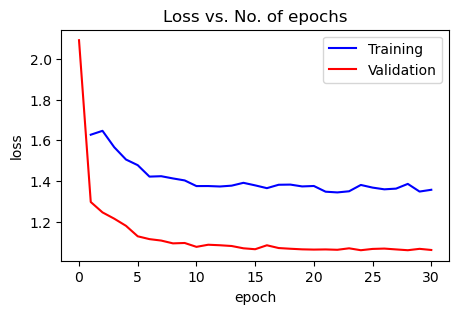

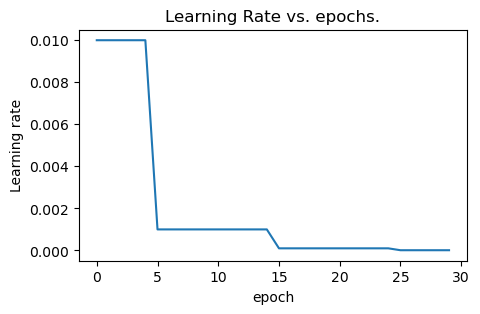

In [26]:
# tau = 2.0

epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'ODIR_Aug'
model = model_res.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Res50_tl_{dataset}_class_wise__ind_t20'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit_class_wise_loss_avg(epochs = epochs, max_lr= max_lr, loss_func= loss, model = model, model_parameters = model_parameters,train_loader = train_loader, val_loader = val_loader, model_name=model_name,decay_epochs=decay_epochs,class_names=class_names,tau=2.0,method='independent')

logger(model_name,history,{'Dataset':dataset,'BaseModel':'Res50+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

## only focal loss

In [42]:
epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = FocalLoss(gamma=2.0,reduction='mean')
dataset = 'ODIR_Aug'
model = model_res.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Res50_tl_{dataset}_focal_loss'
history = [evaluate(model, val_loader,F.cross_entropy)]
print(history)
# history = []

# print(history)
history += fit_focal_loss(epochs,max_lr,loss,model,model_parameters,train_loader,val_loader,model_name=model_name,decay_epochs=decay_epochs)

# torch.save(model_ft.state_dict(),f'{model_name}.pth')
logger(model_name,history,{'Dataset':dataset,'BaseModel':'Res50+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

[{'val_loss': 2.079049825668335, 'val_acc': 0.13249999284744263}]


100%|██████████| 200/200 [04:00<00:00,  1.20s/it]


Epoch [1], last_lr: 0.01000, train_loss: 0.8991, val_loss: 1.2856, val_acc: 0.5325
best_acc: 0.5325000286102295


100%|██████████| 200/200 [03:27<00:00,  1.04s/it]


Epoch [2], last_lr: 0.01000, train_loss: 0.7364, val_loss: 1.2018, val_acc: 0.5625
best_acc: 0.5625


100%|██████████| 200/200 [03:22<00:00,  1.01s/it]


Epoch [3], last_lr: 0.01000, train_loss: 0.6816, val_loss: 1.1683, val_acc: 0.5688
best_acc: 0.5687500238418579


100%|██████████| 200/200 [03:26<00:00,  1.03s/it]


Epoch [4], last_lr: 0.01000, train_loss: 0.6592, val_loss: 1.1315, val_acc: 0.5938
best_acc: 0.59375


100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [5], last_lr: 0.01000, train_loss: 0.6200, val_loss: 1.0835, val_acc: 0.6150
best_acc: 0.6150000095367432


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [6], last_lr: 0.00100, train_loss: 0.5860, val_loss: 1.0833, val_acc: 0.6225
best_acc: 0.6225000023841858


100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [7], last_lr: 0.00100, train_loss: 0.5711, val_loss: 1.0816, val_acc: 0.6375
best_acc: 0.637499988079071


100%|██████████| 200/200 [03:13<00:00,  1.04it/s]


Epoch [8], last_lr: 0.00100, train_loss: 0.5773, val_loss: 1.0937, val_acc: 0.6325
best_acc: 0.637499988079071


100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [9], last_lr: 0.00100, train_loss: 0.5709, val_loss: 1.0644, val_acc: 0.6300
best_acc: 0.637499988079071


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [10], last_lr: 0.00100, train_loss: 0.5693, val_loss: 1.0554, val_acc: 0.6212
best_acc: 0.637499988079071


100%|██████████| 200/200 [03:23<00:00,  1.02s/it]


Epoch [11], last_lr: 0.00100, train_loss: 0.5759, val_loss: 1.0731, val_acc: 0.6313
best_acc: 0.637499988079071


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch [12], last_lr: 0.00100, train_loss: 0.5695, val_loss: 1.0508, val_acc: 0.6263
best_acc: 0.637499988079071


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [13], last_lr: 0.00100, train_loss: 0.5590, val_loss: 1.0473, val_acc: 0.6338
best_acc: 0.637499988079071


100%|██████████| 200/200 [03:25<00:00,  1.03s/it]


Epoch [14], last_lr: 0.00100, train_loss: 0.5662, val_loss: 1.0617, val_acc: 0.6313
best_acc: 0.637499988079071


100%|██████████| 200/200 [03:23<00:00,  1.02s/it]


Epoch [15], last_lr: 0.00100, train_loss: 0.5301, val_loss: 1.0509, val_acc: 0.6338
best_acc: 0.637499988079071


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [16], last_lr: 0.00010, train_loss: 0.5586, val_loss: 1.0530, val_acc: 0.6388
best_acc: 0.6387500166893005


100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [17], last_lr: 0.00010, train_loss: 0.5592, val_loss: 1.0471, val_acc: 0.6438
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:04<00:00,  1.09it/s]


Epoch [18], last_lr: 0.00010, train_loss: 0.5316, val_loss: 1.0573, val_acc: 0.6388
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:04<00:00,  1.09it/s]


Epoch [19], last_lr: 0.00010, train_loss: 0.5549, val_loss: 1.0465, val_acc: 0.6375
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


Epoch [20], last_lr: 0.00010, train_loss: 0.5425, val_loss: 1.0684, val_acc: 0.6325
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch [21], last_lr: 0.00010, train_loss: 0.5519, val_loss: 1.0445, val_acc: 0.6325
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [22], last_lr: 0.00010, train_loss: 0.5382, val_loss: 1.0645, val_acc: 0.6338
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [23], last_lr: 0.00010, train_loss: 0.5415, val_loss: 1.0409, val_acc: 0.6325
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:22<00:00,  1.01s/it]


Epoch [24], last_lr: 0.00010, train_loss: 0.5407, val_loss: 1.0467, val_acc: 0.6400
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [25], last_lr: 0.00010, train_loss: 0.5559, val_loss: 1.0653, val_acc: 0.6325
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch [26], last_lr: 0.00001, train_loss: 0.5457, val_loss: 1.0411, val_acc: 0.6350
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch [27], last_lr: 0.00001, train_loss: 0.5384, val_loss: 1.0345, val_acc: 0.6313
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch [28], last_lr: 0.00001, train_loss: 0.5372, val_loss: 1.0357, val_acc: 0.6375
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [29], last_lr: 0.00001, train_loss: 0.5550, val_loss: 1.0449, val_acc: 0.6313
best_acc: 0.643750011920929


100%|██████████| 200/200 [03:07<00:00,  1.07it/s]


Epoch [30], last_lr: 0.00001, train_loss: 0.5412, val_loss: 1.0452, val_acc: 0.6313
best_acc: 0.643750011920929


NameError: name 'model_ft' is not defined

## Resent50 Fscore + Focal loss

[{'val_loss': 2.081535816192627, 'val_acc': 0.11999999731779099}]


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [1], last_lr: 0.01000, train_loss: 1.1994, val_loss: 1.3239, val_acc: 0.5175
best_acc: 0.5174999833106995


100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [2], last_lr: 0.01000, train_loss: 9.1322, val_loss: 1.4283, val_acc: 0.4300
best_acc: 0.5174999833106995


100%|██████████| 200/200 [03:09<00:00,  1.05it/s]


Epoch [3], last_lr: 0.01000, train_loss: 7.7668, val_loss: 1.3410, val_acc: 0.5063
best_acc: 0.5174999833106995


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [4], last_lr: 0.01000, train_loss: 6.4513, val_loss: 1.3034, val_acc: 0.5437
best_acc: 0.543749988079071


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [5], last_lr: 0.01000, train_loss: 6.1632, val_loss: 1.3155, val_acc: 0.5263
best_acc: 0.543749988079071


100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch [6], last_lr: 0.00100, train_loss: 5.5763, val_loss: 1.2388, val_acc: 0.5663
best_acc: 0.5662500262260437


100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [7], last_lr: 0.00100, train_loss: 5.1718, val_loss: 1.2166, val_acc: 0.5650
best_acc: 0.5662500262260437


100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [8], last_lr: 0.00100, train_loss: 5.1370, val_loss: 1.1978, val_acc: 0.5725
best_acc: 0.5724999904632568


100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [9], last_lr: 0.00100, train_loss: 5.0462, val_loss: 1.1952, val_acc: 0.5663
best_acc: 0.5724999904632568


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [10], last_lr: 0.00100, train_loss: 5.2985, val_loss: 1.1810, val_acc: 0.5612
best_acc: 0.5724999904632568


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [11], last_lr: 0.00100, train_loss: 5.2532, val_loss: 1.1955, val_acc: 0.5550
best_acc: 0.5724999904632568


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [12], last_lr: 0.00100, train_loss: 5.0580, val_loss: 1.1461, val_acc: 0.5800
best_acc: 0.5799999833106995


100%|██████████| 200/200 [03:25<00:00,  1.03s/it]


Epoch [13], last_lr: 0.00100, train_loss: 4.8597, val_loss: 1.1570, val_acc: 0.5800
best_acc: 0.5799999833106995


100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


Epoch [14], last_lr: 0.00100, train_loss: 4.7087, val_loss: 1.1687, val_acc: 0.5775
best_acc: 0.5799999833106995


100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch [15], last_lr: 0.00100, train_loss: 4.7110, val_loss: 1.1756, val_acc: 0.5675
best_acc: 0.5799999833106995


100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch [16], last_lr: 0.00010, train_loss: 4.7229, val_loss: 1.1701, val_acc: 0.5788
best_acc: 0.5799999833106995


100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch [17], last_lr: 0.00010, train_loss: 4.3622, val_loss: 1.1786, val_acc: 0.5838
best_acc: 0.5837500095367432


100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [18], last_lr: 0.00010, train_loss: 4.2554, val_loss: 1.2020, val_acc: 0.5800
best_acc: 0.5837500095367432


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [19], last_lr: 0.00010, train_loss: 4.3605, val_loss: 1.1770, val_acc: 0.5713
best_acc: 0.5837500095367432


100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [20], last_lr: 0.00010, train_loss: 4.2950, val_loss: 1.1807, val_acc: 0.5850
best_acc: 0.5849999785423279


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch [21], last_lr: 0.00010, train_loss: 4.2179, val_loss: 1.1867, val_acc: 0.5925
best_acc: 0.5924999713897705


100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [22], last_lr: 0.00010, train_loss: 4.1591, val_loss: 1.1911, val_acc: 0.5788
best_acc: 0.5924999713897705


100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [23], last_lr: 0.00010, train_loss: 4.3331, val_loss: 1.1747, val_acc: 0.5913
best_acc: 0.5924999713897705


100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [24], last_lr: 0.00010, train_loss: 4.2044, val_loss: 1.1730, val_acc: 0.5950
best_acc: 0.5950000286102295


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [25], last_lr: 0.00010, train_loss: 4.1330, val_loss: 1.2122, val_acc: 0.5763
best_acc: 0.5950000286102295


100%|██████████| 200/200 [03:09<00:00,  1.05it/s]


Epoch [26], last_lr: 0.00001, train_loss: 4.3617, val_loss: 1.1841, val_acc: 0.5875
best_acc: 0.5950000286102295


100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch [27], last_lr: 0.00001, train_loss: 4.1877, val_loss: 1.1953, val_acc: 0.5763
best_acc: 0.5950000286102295


100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [28], last_lr: 0.00001, train_loss: 4.2579, val_loss: 1.2025, val_acc: 0.5788
best_acc: 0.5950000286102295


100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [29], last_lr: 0.00001, train_loss: 4.3848, val_loss: 1.2017, val_acc: 0.5775
best_acc: 0.5950000286102295


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch [30], last_lr: 0.00001, train_loss: 4.2604, val_loss: 1.2348, val_acc: 0.5763
best_acc: 0.5950000286102295


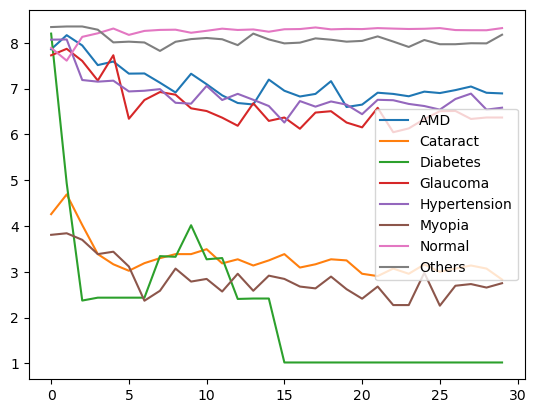

TypeError: list indices must be integers or slices, not str

In [52]:
epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = FocalLoss(gamma=2.0,reduction='mean')
dataset = 'ODIR_Aug'
model = model_res.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Res50_tl_{dataset}_focal_loss_fscore'
history = [evaluate(model, val_loader,F.cross_entropy)]
print(history)
# history = []

# print(history)
history += fit_focal_loss_fscore(epochs,max_lr,loss,model,model_parameters,train_loader,val_loader,model_name=model_name,decay_epochs=decay_epochs,class_names=class_names)


logger(model_name,history,{'Dataset':dataset,'BaseModel':'Res50+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

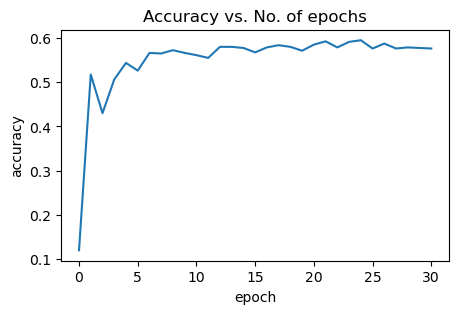

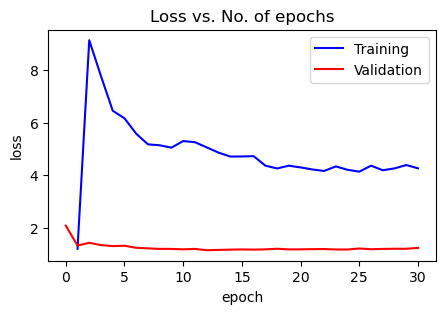

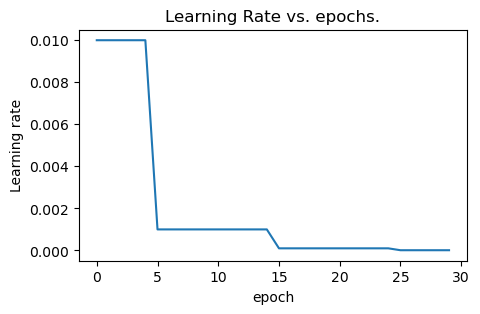

In [61]:
logger(model_name,history[:-1],{'Dataset':dataset,'BaseModel':'Res50+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM','class_weights':history[-1]})

plot = Plots(history[:-1],model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()

In [58]:
history[-2:]

[{'val_loss': 1.2348432540893555,
  'val_acc': 0.5762500166893005,
  'train_loss': 4.260417938232422,
  'lrs': [1.0000000000000003e-05]},
 [array([7.8595176, 4.258248 , 8.20188  , 7.7272797, 8.069573 , 3.806447 ,
         7.890052 , 8.344883 ], dtype=float32),
  array([8.167685 , 4.6890697, 4.9338512, 7.86973  , 8.073837 , 3.8406506,
         7.6112547, 8.357584 ], dtype=float32),
  array([7.9433074, 4.0214686, 2.3709643, 7.6049557, 7.188136 , 3.6972995,
         8.130802 , 8.357555 ], dtype=float32),
  array([7.513849 , 3.385352 , 2.4341125, 7.177047 , 7.1522284, 3.385352 ,
         8.2087   , 8.287033 ], dtype=float32),
  array([7.591861 , 3.1632714, 2.4341125, 7.728979 , 7.1740875, 3.4378245,
         8.312836 , 8.01016  ], dtype=float32),
  array([7.3274937, 3.0219529, 2.4341125, 6.3419156, 6.938753 , 3.1141686,
         8.174069 , 8.0258045], dtype=float32),
  array([7.3314366, 3.1880524, 2.4341125, 6.751442 , 6.9537315, 2.3672082,
         8.260869 , 8.008169 ], dtype=float32),
 

## Resent50 with MLP Net

In [39]:
from mlp_net import NonLinearClassifier 

epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'ODIR_Aug'
model = model_res.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

# mlp net
mlp_net = NonLinearClassifier(dim_in=len(class_names),n_label= len(class_names)).cuda()

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Res50_tl_{dataset}_class_wise_mlp'
# history = [evaluate(model, val_loader,loss)]
# print(history)

history =[]
# print(history)
history += fit_class_wise_loss_mlp_net(epochs = epochs, max_lr= max_lr, loss_func= loss, model = model, model_parameters = model_parameters,train_loader = train_loader, val_loader = val_loader, model_name=model_name,decay_epochs=decay_epochs,class_names=class_names, mlp_net=mlp_net)

logger(model_name,history,{'Dataset':dataset,'BaseModel':'Res50+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

100%|██████████| 200/200 [03:53<00:00,  1.17s/it]


f-score:  tensor([0.5798, 0.8804, 0.2317, 0.6197, 0.5887, 0.8844, 0.3258, 0.4267],
       device='cuda:0')
class_wise weights:  tensor([10.7463, 10.6412, 11.7841, 11.4953,  9.8601, 11.5739, 11.6450, 12.8730],
       device='cuda:0')
Epoch [1], last_lr: 0.01000, train_loss: 1.4058, val_loss: 1.1804, val_acc: 0.5738
best_acc: 0.5737500190734863


100%|██████████| 200/200 [03:47<00:00,  1.14s/it]


f-score:  tensor([0.5455, 0.8617, 0.3547, 0.6359, 0.6436, 0.8660, 0.3558, 0.4469],
       device='cuda:0')


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Vgg16 Custom v1

In [24]:
model_vgg = models.vgg16(pretrained=True)
for param in model_vgg.parameters():
    param.requires_grad = False
in_features = model_vgg.classifier[6].in_features


# Defining Dense top layers after the convolutional layers
model_vgg.classifier[6] = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, len(class_names)),
    )
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
numel(model_vgg,1)

2173832

[{'val_loss': 2.0802195072174072, 'val_acc': 0.11124999821186066}]


100%|██████████| 200/200 [05:09<00:00,  1.55s/it]


Epoch [1], last_lr: 0.01000, train_loss: 1.8414, val_loss: 1.4989, val_acc: 0.4175
best_acc: 0.41749998927116394


100%|██████████| 200/200 [04:58<00:00,  1.49s/it]


Epoch [2], last_lr: 0.01000, train_loss: 1.6749, val_loss: 1.4584, val_acc: 0.4175
best_acc: 0.41749998927116394


100%|██████████| 200/200 [04:58<00:00,  1.49s/it]


Epoch [3], last_lr: 0.01000, train_loss: 1.6453, val_loss: 1.4366, val_acc: 0.4412
best_acc: 0.4412499964237213


100%|██████████| 200/200 [04:59<00:00,  1.50s/it]


Epoch [4], last_lr: 0.01000, train_loss: 1.6198, val_loss: 1.4214, val_acc: 0.4525
best_acc: 0.45249998569488525


100%|██████████| 200/200 [04:57<00:00,  1.49s/it]


Epoch [5], last_lr: 0.01000, train_loss: 1.5807, val_loss: 1.3893, val_acc: 0.4712
best_acc: 0.4712499976158142


100%|██████████| 200/200 [04:58<00:00,  1.49s/it]


Epoch [6], last_lr: 0.00100, train_loss: 1.5684, val_loss: 1.3776, val_acc: 0.4675
best_acc: 0.4712499976158142


100%|██████████| 200/200 [04:57<00:00,  1.49s/it]


Epoch [7], last_lr: 0.00100, train_loss: 1.5621, val_loss: 1.3816, val_acc: 0.4750
best_acc: 0.4749999940395355


100%|██████████| 200/200 [04:57<00:00,  1.49s/it]


Epoch [8], last_lr: 0.00100, train_loss: 1.5574, val_loss: 1.3748, val_acc: 0.4787
best_acc: 0.47874999046325684


100%|██████████| 200/200 [04:58<00:00,  1.49s/it]


Epoch [9], last_lr: 0.00100, train_loss: 1.5343, val_loss: 1.3593, val_acc: 0.4688
best_acc: 0.47874999046325684


100%|██████████| 200/200 [05:01<00:00,  1.51s/it]


Epoch [10], last_lr: 0.00100, train_loss: 1.5394, val_loss: 1.3673, val_acc: 0.4850
best_acc: 0.48500001430511475


100%|██████████| 200/200 [04:58<00:00,  1.49s/it]


Epoch [11], last_lr: 0.00100, train_loss: 1.5296, val_loss: 1.3594, val_acc: 0.4800
best_acc: 0.48500001430511475


100%|██████████| 200/200 [04:57<00:00,  1.49s/it]


Epoch [12], last_lr: 0.00100, train_loss: 1.5294, val_loss: 1.3498, val_acc: 0.4812
best_acc: 0.48500001430511475


100%|██████████| 200/200 [04:58<00:00,  1.49s/it]


Epoch [13], last_lr: 0.00100, train_loss: 1.5391, val_loss: 1.3577, val_acc: 0.4750
best_acc: 0.48500001430511475


100%|██████████| 200/200 [05:31<00:00,  1.66s/it]


Epoch [14], last_lr: 0.00100, train_loss: 1.5163, val_loss: 1.3607, val_acc: 0.4787
best_acc: 0.48500001430511475


100%|██████████| 200/200 [06:03<00:00,  1.82s/it]


Epoch [15], last_lr: 0.00100, train_loss: 1.5384, val_loss: 1.3601, val_acc: 0.4850
best_acc: 0.48500001430511475


100%|██████████| 200/200 [06:05<00:00,  1.83s/it]


Epoch [16], last_lr: 0.00010, train_loss: 1.5363, val_loss: 1.3465, val_acc: 0.4850
best_acc: 0.48500001430511475


100%|██████████| 200/200 [05:52<00:00,  1.76s/it]


Epoch [17], last_lr: 0.00010, train_loss: 1.5320, val_loss: 1.3542, val_acc: 0.4888
best_acc: 0.48875001072883606


100%|██████████| 200/200 [05:52<00:00,  1.76s/it]


Epoch [18], last_lr: 0.00010, train_loss: 1.5451, val_loss: 1.3586, val_acc: 0.4800
best_acc: 0.48875001072883606


100%|██████████| 200/200 [05:45<00:00,  1.73s/it]


Epoch [19], last_lr: 0.00010, train_loss: 1.5482, val_loss: 1.3493, val_acc: 0.4875
best_acc: 0.48875001072883606


100%|██████████| 200/200 [05:47<00:00,  1.74s/it]


Epoch [20], last_lr: 0.00010, train_loss: 1.5418, val_loss: 1.3502, val_acc: 0.4775
best_acc: 0.48875001072883606


100%|██████████| 200/200 [05:48<00:00,  1.74s/it]


Epoch [21], last_lr: 0.00010, train_loss: 1.5339, val_loss: 1.3502, val_acc: 0.4913
best_acc: 0.49125000834465027


100%|██████████| 200/200 [06:00<00:00,  1.80s/it]


Epoch [22], last_lr: 0.00010, train_loss: 1.5413, val_loss: 1.3555, val_acc: 0.4737
best_acc: 0.49125000834465027


100%|██████████| 200/200 [06:01<00:00,  1.81s/it]


Epoch [23], last_lr: 0.00010, train_loss: 1.5417, val_loss: 1.3515, val_acc: 0.4900
best_acc: 0.49125000834465027


100%|██████████| 200/200 [05:50<00:00,  1.75s/it]


Epoch [24], last_lr: 0.00010, train_loss: 1.5309, val_loss: 1.3513, val_acc: 0.4900
best_acc: 0.49125000834465027


100%|██████████| 200/200 [05:51<00:00,  1.76s/it]


Epoch [25], last_lr: 0.00010, train_loss: 1.5260, val_loss: 1.3568, val_acc: 0.4875
best_acc: 0.49125000834465027


100%|██████████| 200/200 [05:50<00:00,  1.75s/it]


Epoch [26], last_lr: 0.00001, train_loss: 1.5270, val_loss: 1.3480, val_acc: 0.4988
best_acc: 0.4987500011920929


100%|██████████| 200/200 [06:01<00:00,  1.81s/it]


Epoch [27], last_lr: 0.00001, train_loss: 1.5326, val_loss: 1.3519, val_acc: 0.4812
best_acc: 0.4987500011920929


100%|██████████| 200/200 [05:48<00:00,  1.74s/it]


Epoch [28], last_lr: 0.00001, train_loss: 1.5341, val_loss: 1.3552, val_acc: 0.4850
best_acc: 0.4987500011920929


100%|██████████| 200/200 [05:50<00:00,  1.75s/it]


Epoch [29], last_lr: 0.00001, train_loss: 1.5318, val_loss: 1.3520, val_acc: 0.4913
best_acc: 0.4987500011920929


100%|██████████| 200/200 [05:50<00:00,  1.75s/it]


Epoch [30], last_lr: 0.00001, train_loss: 1.5388, val_loss: 1.3544, val_acc: 0.4825
best_acc: 0.4987500011920929


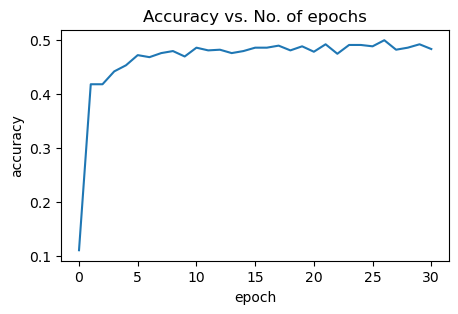

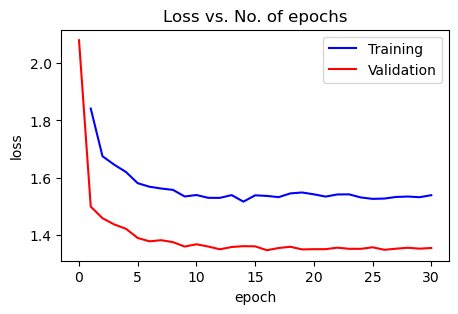

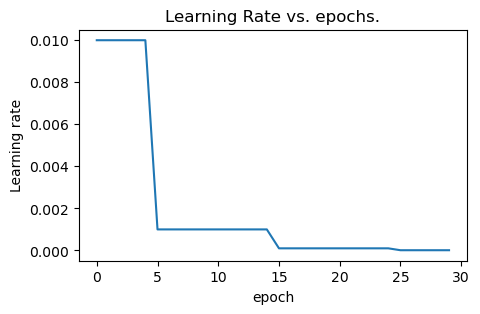

In [26]:
epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'ODIR_Aug'
model = model_vgg.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'vggcustom_tl_{dataset}'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit(epochs,max_lr,loss,model,model_parameters,train_loader,val_loader,model_name=model_name,decay_epochs=decay_epochs)

torch.save(model_ft.state_dict(),f'{model_name}.pth')
logger(model_name,history,{'Dataset':dataset,'BaseModel':'Vgg16+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

## Vgg16 custom v2

In [27]:
model_vgg_v2 = models.vgg16(pretrained=True)
for param in model_vgg_v2.parameters():
    param.requires_grad = False
in_features = model_vgg_v2.classifier[0].in_features


# Defining Dense top layers after the convolutional layers
model_vgg_v2.classifier = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, len(class_names)),
    )
print(model_vgg_v2)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
numel(model_vgg_v2,1)

12963720

[{'val_loss': 2.082306385040283, 'val_acc': 0.1237500011920929}]


100%|██████████| 200/200 [06:03<00:00,  1.82s/it]


Epoch [1], last_lr: 0.01000, train_loss: 1.6898, val_loss: 1.5451, val_acc: 0.4350
best_acc: 0.4350000023841858


100%|██████████| 200/200 [06:00<00:00,  1.80s/it]


Epoch [2], last_lr: 0.01000, train_loss: 1.5336, val_loss: 1.3922, val_acc: 0.4988
best_acc: 0.4987500011920929


100%|██████████| 200/200 [05:56<00:00,  1.78s/it]


Epoch [3], last_lr: 0.01000, train_loss: 1.4610, val_loss: 1.3617, val_acc: 0.4900
best_acc: 0.4987500011920929


100%|██████████| 200/200 [05:58<00:00,  1.79s/it]


Epoch [4], last_lr: 0.01000, train_loss: 1.4162, val_loss: 1.2860, val_acc: 0.5050
best_acc: 0.5049999952316284


100%|██████████| 200/200 [06:09<00:00,  1.85s/it]


Epoch [5], last_lr: 0.01000, train_loss: 1.4047, val_loss: 1.2739, val_acc: 0.5275
best_acc: 0.5274999737739563


100%|██████████| 200/200 [06:05<00:00,  1.83s/it]


Epoch [6], last_lr: 0.00100, train_loss: 1.3805, val_loss: 1.2633, val_acc: 0.5288
best_acc: 0.5287500023841858


100%|██████████| 200/200 [06:01<00:00,  1.81s/it]


Epoch [7], last_lr: 0.00100, train_loss: 1.3356, val_loss: 1.2260, val_acc: 0.5312
best_acc: 0.53125


100%|██████████| 200/200 [06:00<00:00,  1.80s/it]


Epoch [8], last_lr: 0.00100, train_loss: 1.3458, val_loss: 1.2362, val_acc: 0.5300
best_acc: 0.53125


100%|██████████| 200/200 [05:50<00:00,  1.75s/it]


Epoch [9], last_lr: 0.00100, train_loss: 1.3460, val_loss: 1.1992, val_acc: 0.5500
best_acc: 0.550000011920929


100%|██████████| 200/200 [05:51<00:00,  1.76s/it]


Epoch [10], last_lr: 0.00100, train_loss: 1.3280, val_loss: 1.2208, val_acc: 0.5450
best_acc: 0.550000011920929


100%|██████████| 200/200 [05:51<00:00,  1.76s/it]


Epoch [11], last_lr: 0.00100, train_loss: 1.3291, val_loss: 1.2157, val_acc: 0.5500
best_acc: 0.550000011920929


100%|██████████| 200/200 [06:05<00:00,  1.83s/it]


Epoch [12], last_lr: 0.00100, train_loss: 1.3015, val_loss: 1.2264, val_acc: 0.5525
best_acc: 0.5525000095367432


100%|██████████| 200/200 [06:29<00:00,  1.95s/it]


Epoch [13], last_lr: 0.00100, train_loss: 1.3221, val_loss: 1.2066, val_acc: 0.5562
best_acc: 0.5562499761581421


100%|██████████| 200/200 [06:08<00:00,  1.84s/it]


Epoch [14], last_lr: 0.00100, train_loss: 1.3162, val_loss: 1.2138, val_acc: 0.5537
best_acc: 0.5562499761581421


100%|██████████| 200/200 [06:11<00:00,  1.86s/it]


Epoch [15], last_lr: 0.00100, train_loss: 1.3016, val_loss: 1.1748, val_acc: 0.5575
best_acc: 0.5575000047683716


100%|██████████| 200/200 [06:11<00:00,  1.86s/it]


Epoch [16], last_lr: 0.00010, train_loss: 1.2879, val_loss: 1.1914, val_acc: 0.5537
best_acc: 0.5575000047683716


100%|██████████| 200/200 [06:13<00:00,  1.87s/it]


Epoch [17], last_lr: 0.00010, train_loss: 1.3142, val_loss: 1.2246, val_acc: 0.5500
best_acc: 0.5575000047683716


100%|██████████| 200/200 [07:15<00:00,  2.18s/it]


Epoch [18], last_lr: 0.00010, train_loss: 1.2832, val_loss: 1.2078, val_acc: 0.5425
best_acc: 0.5575000047683716


100%|██████████| 200/200 [06:20<00:00,  1.90s/it]


Epoch [19], last_lr: 0.00010, train_loss: 1.3122, val_loss: 1.2490, val_acc: 0.5512
best_acc: 0.5575000047683716


100%|██████████| 200/200 [08:26<00:00,  2.53s/it]


Epoch [20], last_lr: 0.00010, train_loss: 1.2997, val_loss: 1.2052, val_acc: 0.5562
best_acc: 0.5575000047683716


100%|██████████| 200/200 [06:34<00:00,  1.97s/it]


Epoch [21], last_lr: 0.00010, train_loss: 1.3159, val_loss: 1.2104, val_acc: 0.5512
best_acc: 0.5575000047683716


100%|██████████| 200/200 [07:02<00:00,  2.11s/it]


Epoch [22], last_lr: 0.00010, train_loss: 1.2833, val_loss: 1.2055, val_acc: 0.5638
best_acc: 0.5637500286102295


100%|██████████| 200/200 [06:19<00:00,  1.90s/it]


Epoch [23], last_lr: 0.00010, train_loss: 1.2935, val_loss: 1.2131, val_acc: 0.5525
best_acc: 0.5637500286102295


100%|██████████| 200/200 [06:19<00:00,  1.90s/it]


Epoch [24], last_lr: 0.00010, train_loss: 1.3020, val_loss: 1.1928, val_acc: 0.5713
best_acc: 0.5712500214576721


100%|██████████| 200/200 [08:03<00:00,  2.42s/it]


Epoch [25], last_lr: 0.00010, train_loss: 1.3114, val_loss: 1.2165, val_acc: 0.5512
best_acc: 0.5712500214576721


100%|██████████| 200/200 [06:31<00:00,  1.96s/it]


Epoch [26], last_lr: 0.00001, train_loss: 1.2869, val_loss: 1.1827, val_acc: 0.5675
best_acc: 0.5712500214576721


100%|██████████| 200/200 [06:15<00:00,  1.88s/it]


Epoch [27], last_lr: 0.00001, train_loss: 1.3152, val_loss: 1.2193, val_acc: 0.5575
best_acc: 0.5712500214576721


100%|██████████| 200/200 [06:12<00:00,  1.86s/it]


Epoch [28], last_lr: 0.00001, train_loss: 1.3172, val_loss: 1.1998, val_acc: 0.5462
best_acc: 0.5712500214576721


100%|██████████| 200/200 [06:16<00:00,  1.88s/it]


Epoch [29], last_lr: 0.00001, train_loss: 1.2805, val_loss: 1.2081, val_acc: 0.5462
best_acc: 0.5712500214576721


100%|██████████| 200/200 [06:15<00:00,  1.88s/it]


Epoch [30], last_lr: 0.00001, train_loss: 1.3095, val_loss: 1.1910, val_acc: 0.5625
best_acc: 0.5712500214576721


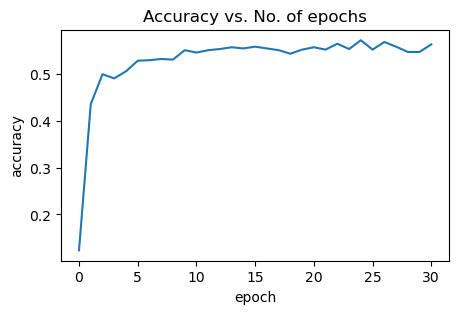

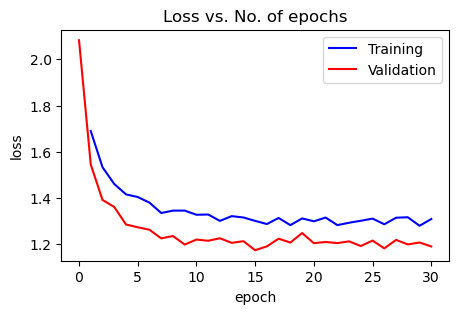

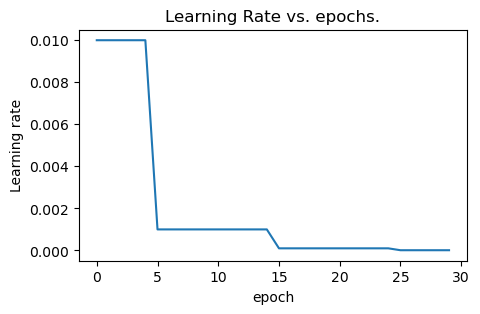

In [29]:
epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'ODIR_Aug'
model = model_vgg_v2.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'vggcustom_v2_tl_{dataset}'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit(epochs,max_lr,loss,model,model_parameters,train_loader,val_loader,model_name=model_name,decay_epochs=decay_epochs)

torch.save(model_ft.state_dict(),f'{model_name}.pth')
logger(model_name,history,{'Dataset':dataset,'BaseModel':'Vgg16+custom_v2',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

<!-- ## RFMiD Pure -->
## RFMID Aug Train
CB, CF, CL, HR, MCA, ODPM, TD, TV, VH, VS these classes are removed since no images or 
 Less than 10 images
AH : 8
BRAO : 1
CME : 1
CRAO : 1
CWS : 1
EDN : 4
ERM : 8
HPED : 1
LS : 2
MHL : 5
MNF : 1
MS : 4
PLQ : 1
PRH : 1
PT : 8
PTCR : 3
RP : 4
RT : 5
ST : 3

## Vgg16 basic

In [58]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = models.vgg16(pretrained=True)

In [164]:
PATH = 'data/RFMiD_Aug_Train/' 
train_loader,val_loader,class_names = get_train_valid_loader(PATH,16,augment = True,random_seed = 42,valid_size = 0.2,num_workers=1)

['AION', 'ARMD', 'BRVO', 'CRS', 'CRVO', 'CSR', 'DN', 'DR', 'Disease_Risk', 'MH', 'MYA', 'ODC', 'ODE', 'ODP', 'Other', 'RPEC', 'RS', 'TSLN']


In [60]:
# # Newly created modules have require_grad=True by default
# model_ft.classifier[6].out_features = len(class_names) # vgg16
# # Freeze training for all layers
# for param in model_ft.features.parameters():
#     param.require_grad = False


# Freeze training for all layers
# for param in list(model_ft.features.parameters())[:-2]:
#     param.requires_grad = False
# for param in list(model_ft.classifier.parameters())[:-4]:
#     param.requires_grad = False

# Newly created modules have require_grad=True by default
num_features = model_ft.classifier[6].in_features
features = list(model_ft.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
model_ft.classifier = nn.Sequential(*features) # Replace the model classifier

# for param in model_ft.classifier.parameters():
#     param.requires_grad = False
#     print(param)
 # Replace the model classifier
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [61]:
numel(model_ft,1)

134334290

[{'val_loss': 2.940199136734009, 'val_acc': 0.06628787517547607}]


100%|██████████| 131/131 [05:36<00:00,  2.57s/it]


Epoch [1], last_lr: 0.00010, train_loss: 2.9521, val_loss: 2.9039, val_acc: 0.0606
best_acc: 0.06060606241226196


100%|██████████| 131/131 [06:04<00:00,  2.79s/it]


Epoch [2], last_lr: 0.00010, train_loss: 2.9332, val_loss: 2.8783, val_acc: 0.0663
best_acc: 0.06628787517547607


100%|██████████| 131/131 [03:31<00:00,  1.61s/it]


Epoch [3], last_lr: 0.00010, train_loss: 2.9170, val_loss: 2.8570, val_acc: 0.0833
best_acc: 0.0833333358168602


100%|██████████| 131/131 [03:32<00:00,  1.63s/it]


Epoch [4], last_lr: 0.00010, train_loss: 2.8942, val_loss: 2.8373, val_acc: 0.0920
best_acc: 0.09204544872045517


100%|██████████| 131/131 [03:33<00:00,  1.63s/it]


Epoch [5], last_lr: 0.00010, train_loss: 2.8754, val_loss: 2.8209, val_acc: 0.1159
best_acc: 0.11590909212827682


100%|██████████| 131/131 [03:29<00:00,  1.60s/it]


Epoch [6], last_lr: 0.00010, train_loss: 2.8513, val_loss: 2.8035, val_acc: 0.1549
best_acc: 0.15492424368858337


100%|██████████| 131/131 [04:42<00:00,  2.16s/it]


Epoch [7], last_lr: 0.00010, train_loss: 2.8386, val_loss: 2.7863, val_acc: 0.1678
best_acc: 0.16780303418636322


100%|██████████| 131/131 [10:23<00:00,  4.76s/it]


Epoch [8], last_lr: 0.00010, train_loss: 2.8293, val_loss: 2.7716, val_acc: 0.1792
best_acc: 0.17916665971279144


100%|██████████| 131/131 [30:36<00:00, 14.02s/it]


Epoch [9], last_lr: 0.00010, train_loss: 2.8139, val_loss: 2.7547, val_acc: 0.1955
best_acc: 0.19545453786849976


100%|██████████| 131/131 [33:12<00:00, 15.21s/it] 


Epoch [10], last_lr: 0.00010, train_loss: 2.7951, val_loss: 2.7398, val_acc: 0.2117
best_acc: 0.21174243092536926


100%|██████████| 131/131 [17:49<00:00,  8.17s/it] 


Epoch [11], last_lr: 0.00001, train_loss: 2.7900, val_loss: 2.7385, val_acc: 0.2125
best_acc: 0.21249999105930328


100%|██████████| 131/131 [05:25<00:00,  2.48s/it]


Epoch [12], last_lr: 0.00001, train_loss: 2.7864, val_loss: 2.7378, val_acc: 0.2170
best_acc: 0.21704545617103577


100%|██████████| 131/131 [03:21<00:00,  1.54s/it]


Epoch [13], last_lr: 0.00001, train_loss: 2.7932, val_loss: 2.7357, val_acc: 0.2152
best_acc: 0.21704545617103577


100%|██████████| 131/131 [03:19<00:00,  1.53s/it]


Epoch [14], last_lr: 0.00001, train_loss: 2.7979, val_loss: 2.7336, val_acc: 0.2182
best_acc: 0.2181818187236786


100%|██████████| 131/131 [03:19<00:00,  1.53s/it]


Epoch [15], last_lr: 0.00001, train_loss: 2.7993, val_loss: 2.7316, val_acc: 0.2227
best_acc: 0.22272726893424988


100%|██████████| 131/131 [03:20<00:00,  1.53s/it]


Epoch [16], last_lr: 0.00001, train_loss: 2.7931, val_loss: 2.7322, val_acc: 0.2231
best_acc: 0.22310607135295868


100%|██████████| 131/131 [03:21<00:00,  1.54s/it]


Epoch [17], last_lr: 0.00001, train_loss: 2.7791, val_loss: 2.7310, val_acc: 0.2227
best_acc: 0.22310607135295868


100%|██████████| 131/131 [03:22<00:00,  1.54s/it]


Epoch [18], last_lr: 0.00001, train_loss: 2.7823, val_loss: 2.7282, val_acc: 0.2258
best_acc: 0.22575756907463074


100%|██████████| 131/131 [03:20<00:00,  1.53s/it]


Epoch [19], last_lr: 0.00001, train_loss: 2.7779, val_loss: 2.7277, val_acc: 0.2227
best_acc: 0.22575756907463074


100%|██████████| 131/131 [03:19<00:00,  1.53s/it]


Epoch [20], last_lr: 0.00001, train_loss: 2.7713, val_loss: 2.7250, val_acc: 0.2277
best_acc: 0.22765150666236877


100%|██████████| 131/131 [03:20<00:00,  1.53s/it]


Epoch [21], last_lr: 0.00001, train_loss: 2.7819, val_loss: 2.7244, val_acc: 0.2265
best_acc: 0.22765150666236877


100%|██████████| 131/131 [03:26<00:00,  1.58s/it]


Epoch [22], last_lr: 0.00001, train_loss: 2.7769, val_loss: 2.7234, val_acc: 0.2273
best_acc: 0.22765150666236877


100%|██████████| 131/131 [03:58<00:00,  1.82s/it]


Epoch [23], last_lr: 0.00001, train_loss: 2.7775, val_loss: 2.7218, val_acc: 0.2246
best_acc: 0.22765150666236877


100%|██████████| 131/131 [03:21<00:00,  1.54s/it]


Epoch [24], last_lr: 0.00001, train_loss: 2.7856, val_loss: 2.7190, val_acc: 0.2277
best_acc: 0.22765150666236877


100%|██████████| 131/131 [03:20<00:00,  1.53s/it]


Epoch [25], last_lr: 0.00001, train_loss: 2.7736, val_loss: 2.7183, val_acc: 0.2307
best_acc: 0.23068182170391083


100%|██████████| 131/131 [03:20<00:00,  1.53s/it]


Epoch [26], last_lr: 0.00000, train_loss: 2.7726, val_loss: 2.7203, val_acc: 0.2284
best_acc: 0.23068182170391083


100%|██████████| 131/131 [03:19<00:00,  1.53s/it]


Epoch [27], last_lr: 0.00000, train_loss: 2.7745, val_loss: 2.7177, val_acc: 0.2341
best_acc: 0.2340909093618393


100%|██████████| 131/131 [03:20<00:00,  1.53s/it]


Epoch [28], last_lr: 0.00000, train_loss: 2.7778, val_loss: 2.7164, val_acc: 0.2330
best_acc: 0.2340909093618393


100%|██████████| 131/131 [03:54<00:00,  1.79s/it]


Epoch [29], last_lr: 0.00000, train_loss: 2.7677, val_loss: 2.7179, val_acc: 0.2284
best_acc: 0.2340909093618393


100%|██████████| 131/131 [03:19<00:00,  1.52s/it]


Epoch [30], last_lr: 0.00000, train_loss: 2.7787, val_loss: 2.7168, val_acc: 0.2307
best_acc: 0.2340909093618393


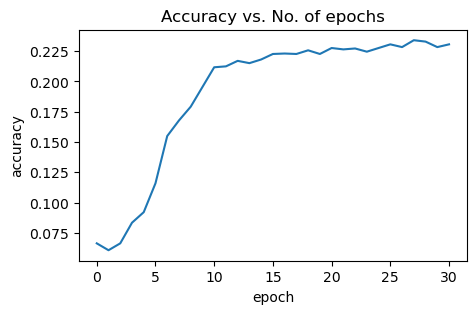

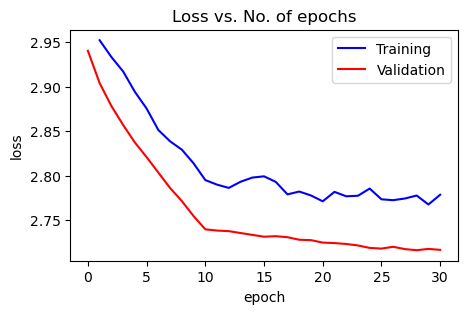

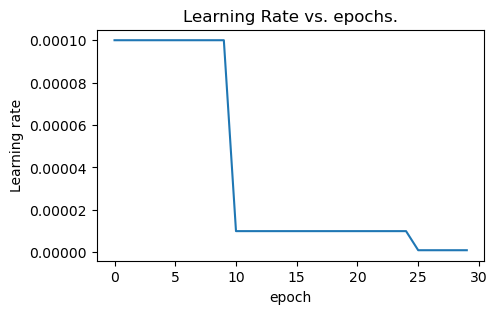

In [15]:
epochs = 30
max_lr = 1e-4
decay_epochs = [10,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'RFMiD_Aug'
model = model_ft.cuda()
model_parameters = model.classifier.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Vgg_tl_{dataset}'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit(epochs,max_lr,loss,model,model_parameters,train_loader,val_loader,model_name=model_name,decay_epochs=decay_epochs)

torch.save(model_ft.state_dict(),f'{model_name}.pth')
logger(model_name,history,{'Dataset':dataset,'BaseModel':'vgg16_fcs',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

### Efficient Net

In [49]:
from efficientnet_pytorch import EfficientNet
model_transfer = EfficientNet.from_pretrained('efficientnet-b0')
 
# print(model_transfer)
# # Freeze weights
for param in model_transfer.parameters():
    param.requires_grad = False
in_features = model_transfer._fc.in_features


# Defining Dense top layers after the convolutional layers
model_transfer._fc = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, len(class_names)),
    )
# if use_cuda:
#     model_transfer = model_transfer.cuda()
# print(model_transfer)

Loaded pretrained weights for efficientnet-b0


In [50]:
numel(model_transfer,1)

727698

[{'val_loss': 2.8910763263702393, 'val_acc': 0.0625}]


100%|██████████| 131/131 [03:18<00:00,  1.51s/it]


Epoch [1], last_lr: 0.01000, train_loss: 2.6262, val_loss: 3.0403, val_acc: 0.1129
best_acc: 0.11287878453731537


100%|██████████| 131/131 [03:18<00:00,  1.52s/it]


Epoch [2], last_lr: 0.01000, train_loss: 2.2419, val_loss: 2.4551, val_acc: 0.2352
best_acc: 0.23522727191448212


100%|██████████| 131/131 [03:18<00:00,  1.52s/it]


Epoch [3], last_lr: 0.01000, train_loss: 2.0800, val_loss: 2.0453, val_acc: 0.3299
best_acc: 0.32992422580718994


100%|██████████| 131/131 [04:03<00:00,  1.86s/it]


Epoch [4], last_lr: 0.01000, train_loss: 1.9497, val_loss: 1.6411, val_acc: 0.4830
best_acc: 0.4829545319080353


100%|██████████| 131/131 [03:20<00:00,  1.53s/it]


Epoch [5], last_lr: 0.01000, train_loss: 1.9146, val_loss: 1.4803, val_acc: 0.5284
best_acc: 0.5284090638160706


100%|██████████| 131/131 [03:18<00:00,  1.51s/it]


Epoch [6], last_lr: 0.00100, train_loss: 1.8530, val_loss: 1.4636, val_acc: 0.5455
best_acc: 0.5454545617103577


100%|██████████| 131/131 [03:18<00:00,  1.52s/it]


Epoch [7], last_lr: 0.00100, train_loss: 1.8189, val_loss: 1.4547, val_acc: 0.5504
best_acc: 0.5503787994384766


100%|██████████| 131/131 [03:18<00:00,  1.52s/it]


Epoch [8], last_lr: 0.00100, train_loss: 1.8491, val_loss: 1.4399, val_acc: 0.5625
best_acc: 0.5625


100%|██████████| 131/131 [03:49<00:00,  1.75s/it]


Epoch [9], last_lr: 0.00100, train_loss: 1.8119, val_loss: 1.4304, val_acc: 0.5572
best_acc: 0.5625


100%|██████████| 131/131 [03:20<00:00,  1.53s/it]


Epoch [10], last_lr: 0.00100, train_loss: 1.8062, val_loss: 1.4027, val_acc: 0.5746
best_acc: 0.5746212005615234


100%|██████████| 131/131 [03:18<00:00,  1.51s/it]


Epoch [11], last_lr: 0.00100, train_loss: 1.8132, val_loss: 1.4114, val_acc: 0.5742
best_acc: 0.5746212005615234


100%|██████████| 131/131 [03:18<00:00,  1.52s/it]


Epoch [12], last_lr: 0.00100, train_loss: 1.8022, val_loss: 1.3925, val_acc: 0.5845
best_acc: 0.584469735622406


100%|██████████| 131/131 [03:17<00:00,  1.51s/it]


Epoch [13], last_lr: 0.00100, train_loss: 1.8054, val_loss: 1.3808, val_acc: 0.5856
best_acc: 0.5856060981750488


100%|██████████| 131/131 [03:18<00:00,  1.52s/it]


Epoch [14], last_lr: 0.00100, train_loss: 1.7648, val_loss: 1.3694, val_acc: 0.5852
best_acc: 0.5856060981750488


100%|██████████| 131/131 [03:36<00:00,  1.65s/it]


Epoch [15], last_lr: 0.00100, train_loss: 1.7802, val_loss: 1.3663, val_acc: 0.5917
best_acc: 0.5916666388511658


100%|██████████| 131/131 [03:18<00:00,  1.52s/it]


Epoch [16], last_lr: 0.00010, train_loss: 1.7548, val_loss: 1.3730, val_acc: 0.5928
best_acc: 0.5928030014038086


100%|██████████| 131/131 [03:18<00:00,  1.51s/it]


Epoch [17], last_lr: 0.00010, train_loss: 1.7766, val_loss: 1.3618, val_acc: 0.5932
best_acc: 0.593181848526001


100%|██████████| 131/131 [03:18<00:00,  1.52s/it]


Epoch [18], last_lr: 0.00010, train_loss: 1.7615, val_loss: 1.3700, val_acc: 0.5871
best_acc: 0.593181848526001


100%|██████████| 131/131 [03:18<00:00,  1.51s/it]


Epoch [19], last_lr: 0.00010, train_loss: 1.7485, val_loss: 1.3689, val_acc: 0.5811
best_acc: 0.593181848526001


100%|██████████| 131/131 [04:01<00:00,  1.84s/it]


Epoch [20], last_lr: 0.00010, train_loss: 1.7708, val_loss: 1.3552, val_acc: 0.5792
best_acc: 0.593181848526001


100%|██████████| 131/131 [03:19<00:00,  1.53s/it]


Epoch [21], last_lr: 0.00010, train_loss: 1.7497, val_loss: 1.3751, val_acc: 0.5814
best_acc: 0.593181848526001


100%|██████████| 131/131 [03:17<00:00,  1.51s/it]


Epoch [22], last_lr: 0.00010, train_loss: 1.7454, val_loss: 1.3696, val_acc: 0.5883
best_acc: 0.593181848526001


100%|██████████| 131/131 [03:18<00:00,  1.51s/it]


Epoch [23], last_lr: 0.00010, train_loss: 1.7765, val_loss: 1.3720, val_acc: 0.5807
best_acc: 0.593181848526001


100%|██████████| 131/131 [03:17<00:00,  1.51s/it]


Epoch [24], last_lr: 0.00010, train_loss: 1.7732, val_loss: 1.3628, val_acc: 0.5883
best_acc: 0.593181848526001


100%|██████████| 131/131 [03:33<00:00,  1.63s/it]


Epoch [25], last_lr: 0.00010, train_loss: 1.7500, val_loss: 1.3589, val_acc: 0.5947
best_acc: 0.5946969985961914


100%|██████████| 131/131 [03:26<00:00,  1.57s/it]


Epoch [26], last_lr: 0.00001, train_loss: 1.7693, val_loss: 1.3599, val_acc: 0.5939
best_acc: 0.5946969985961914


100%|██████████| 131/131 [03:18<00:00,  1.51s/it]


Epoch [27], last_lr: 0.00001, train_loss: 1.7956, val_loss: 1.3570, val_acc: 0.5883
best_acc: 0.5946969985961914


100%|██████████| 131/131 [03:18<00:00,  1.51s/it]


Epoch [28], last_lr: 0.00001, train_loss: 1.7784, val_loss: 1.3516, val_acc: 0.5924
best_acc: 0.5946969985961914


100%|██████████| 131/131 [03:18<00:00,  1.52s/it]


Epoch [29], last_lr: 0.00001, train_loss: 1.7858, val_loss: 1.3536, val_acc: 0.5830
best_acc: 0.5946969985961914


100%|██████████| 131/131 [03:18<00:00,  1.51s/it]


Epoch [30], last_lr: 0.00001, train_loss: 1.7461, val_loss: 1.3641, val_acc: 0.5773
best_acc: 0.5946969985961914


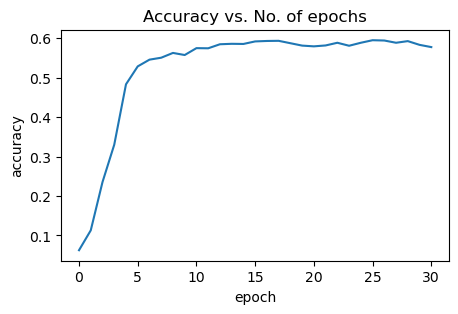

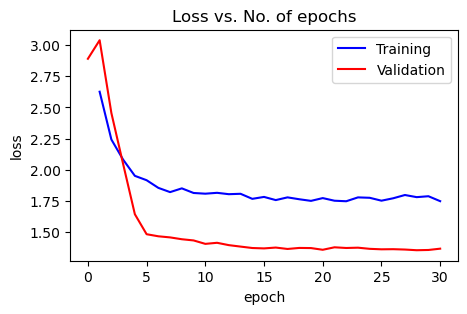

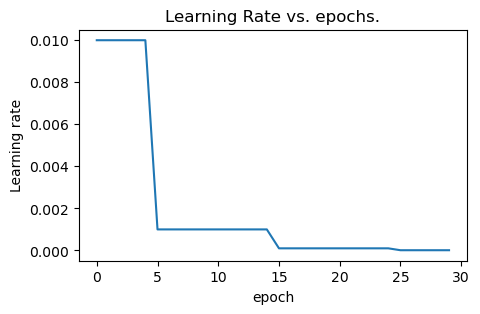

In [18]:
epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'RFMiD_Aug'
model = model_transfer.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'EffNet_tl_{dataset}'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit(epochs,max_lr,loss,model,model_parameters,train_loader,val_loader,model_name=model_name,decay_epochs=decay_epochs)

torch.save(model_ft.state_dict(),f'{model_name}.pth')
logger(model_name,history,{'Dataset':dataset,'BaseModel':'EffNet+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

## Resnet50

In [165]:
model_res = models.resnet50(pretrained=True)
# # Freeze weights
for param in model_res.parameters():
    param.requires_grad = False
in_features = model_res.fc.in_features


# Defining Dense top layers after the convolutional layers
model_res.fc = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, len(class_names)),
    )
print(model_res)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [52]:
numel(model_res,1)

1122450

[{'val_loss': 2.8940601348876953, 'val_acc': 0.04848485067486763}]


100%|██████████| 131/131 [03:47<00:00,  1.73s/it]


Epoch [1], last_lr: 0.01000, train_loss: 2.4368, val_loss: 1.8292, val_acc: 0.4583
best_acc: 0.4583333432674408


100%|██████████| 131/131 [03:19<00:00,  1.52s/it]


Epoch [2], last_lr: 0.01000, train_loss: 1.9718, val_loss: 1.5483, val_acc: 0.5477
best_acc: 0.5477272868156433


100%|██████████| 131/131 [03:18<00:00,  1.51s/it]


Epoch [3], last_lr: 0.01000, train_loss: 1.8366, val_loss: 1.4513, val_acc: 0.5712
best_acc: 0.571212112903595


100%|██████████| 131/131 [03:18<00:00,  1.51s/it]


Epoch [4], last_lr: 0.01000, train_loss: 1.7294, val_loss: 1.3639, val_acc: 0.5780
best_acc: 0.5780303478240967


100%|██████████| 131/131 [03:18<00:00,  1.51s/it]


Epoch [5], last_lr: 0.01000, train_loss: 1.6659, val_loss: 1.2751, val_acc: 0.6121
best_acc: 0.6121212244033813


100%|██████████| 131/131 [03:32<00:00,  1.62s/it]


Epoch [6], last_lr: 0.00100, train_loss: 1.5910, val_loss: 1.2647, val_acc: 0.6394
best_acc: 0.6393939256668091


100%|██████████| 131/131 [03:30<00:00,  1.61s/it]


Epoch [7], last_lr: 0.00100, train_loss: 1.5901, val_loss: 1.2483, val_acc: 0.6367
best_acc: 0.6393939256668091


100%|██████████| 131/131 [03:19<00:00,  1.53s/it]


Epoch [8], last_lr: 0.00100, train_loss: 1.5637, val_loss: 1.2541, val_acc: 0.6258
best_acc: 0.6393939256668091


100%|██████████| 131/131 [03:19<00:00,  1.53s/it]


Epoch [9], last_lr: 0.00100, train_loss: 1.5458, val_loss: 1.2374, val_acc: 0.6390
best_acc: 0.6393939256668091


100%|██████████| 131/131 [03:19<00:00,  1.52s/it]


Epoch [10], last_lr: 0.00100, train_loss: 1.5387, val_loss: 1.2026, val_acc: 0.6587
best_acc: 0.6587120890617371


100%|██████████| 131/131 [03:19<00:00,  1.52s/it]


Epoch [11], last_lr: 0.00100, train_loss: 1.5429, val_loss: 1.1967, val_acc: 0.6576
best_acc: 0.6587120890617371


100%|██████████| 131/131 [03:23<00:00,  1.55s/it]


Epoch [12], last_lr: 0.00100, train_loss: 1.5459, val_loss: 1.1993, val_acc: 0.6561
best_acc: 0.6587120890617371


100%|██████████| 131/131 [03:23<00:00,  1.55s/it]


Epoch [13], last_lr: 0.00100, train_loss: 1.5298, val_loss: 1.2012, val_acc: 0.6545
best_acc: 0.6587120890617371


100%|██████████| 131/131 [03:21<00:00,  1.54s/it]


Epoch [14], last_lr: 0.00100, train_loss: 1.5425, val_loss: 1.1746, val_acc: 0.6716
best_acc: 0.6715909242630005


100%|██████████| 131/131 [03:28<00:00,  1.59s/it]


Epoch [15], last_lr: 0.00100, train_loss: 1.4908, val_loss: 1.1708, val_acc: 0.6727
best_acc: 0.6727272868156433


100%|██████████| 131/131 [03:42<00:00,  1.70s/it]


Epoch [16], last_lr: 0.00010, train_loss: 1.5150, val_loss: 1.1658, val_acc: 0.6652
best_acc: 0.6727272868156433


100%|██████████| 131/131 [03:40<00:00,  1.68s/it]


Epoch [17], last_lr: 0.00010, train_loss: 1.4846, val_loss: 1.1634, val_acc: 0.6670
best_acc: 0.6727272868156433


100%|██████████| 131/131 [03:41<00:00,  1.69s/it]


Epoch [18], last_lr: 0.00010, train_loss: 1.5038, val_loss: 1.1373, val_acc: 0.6833
best_acc: 0.6833333373069763


100%|██████████| 131/131 [03:37<00:00,  1.66s/it]


Epoch [19], last_lr: 0.00010, train_loss: 1.4710, val_loss: 1.1531, val_acc: 0.6742
best_acc: 0.6833333373069763


100%|██████████| 131/131 [03:37<00:00,  1.66s/it]


Epoch [20], last_lr: 0.00010, train_loss: 1.4957, val_loss: 1.1784, val_acc: 0.6614
best_acc: 0.6833333373069763


100%|██████████| 131/131 [03:36<00:00,  1.66s/it]


Epoch [21], last_lr: 0.00010, train_loss: 1.5140, val_loss: 1.1566, val_acc: 0.6633
best_acc: 0.6833333373069763


100%|██████████| 131/131 [03:36<00:00,  1.65s/it]


Epoch [22], last_lr: 0.00010, train_loss: 1.5114, val_loss: 1.1667, val_acc: 0.6640
best_acc: 0.6833333373069763


100%|██████████| 131/131 [03:57<00:00,  1.82s/it]


Epoch [23], last_lr: 0.00010, train_loss: 1.4790, val_loss: 1.1372, val_acc: 0.6727
best_acc: 0.6833333373069763


100%|██████████| 131/131 [03:52<00:00,  1.77s/it]


Epoch [24], last_lr: 0.00010, train_loss: 1.5081, val_loss: 1.1698, val_acc: 0.6583
best_acc: 0.6833333373069763


100%|██████████| 131/131 [03:54<00:00,  1.79s/it]


Epoch [25], last_lr: 0.00010, train_loss: 1.4987, val_loss: 1.1556, val_acc: 0.6697
best_acc: 0.6833333373069763


100%|██████████| 131/131 [03:56<00:00,  1.81s/it]


Epoch [26], last_lr: 0.00001, train_loss: 1.4647, val_loss: 1.1648, val_acc: 0.6640
best_acc: 0.6833333373069763


100%|██████████| 131/131 [06:57<00:00,  3.19s/it]


Epoch [27], last_lr: 0.00001, train_loss: 1.4683, val_loss: 1.1503, val_acc: 0.6652
best_acc: 0.6833333373069763


100%|██████████| 131/131 [3:04:16<00:00, 84.40s/it]     


Epoch [28], last_lr: 0.00001, train_loss: 1.5280, val_loss: 1.1530, val_acc: 0.6803
best_acc: 0.6833333373069763


100%|██████████| 131/131 [03:26<00:00,  1.58s/it]


Epoch [29], last_lr: 0.00001, train_loss: 1.4935, val_loss: 1.1749, val_acc: 0.6731
best_acc: 0.6833333373069763


100%|██████████| 131/131 [03:34<00:00,  1.64s/it]


Epoch [30], last_lr: 0.00001, train_loss: 1.5077, val_loss: 1.1430, val_acc: 0.6716
best_acc: 0.6833333373069763


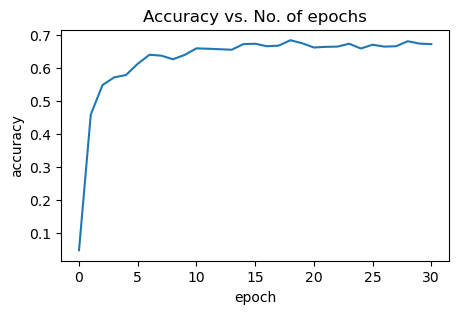

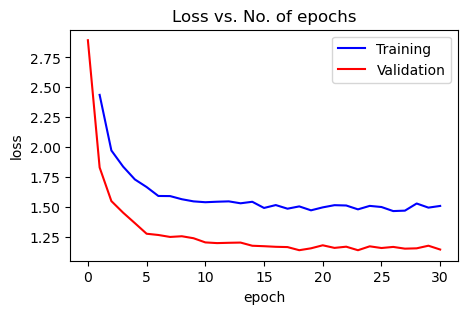

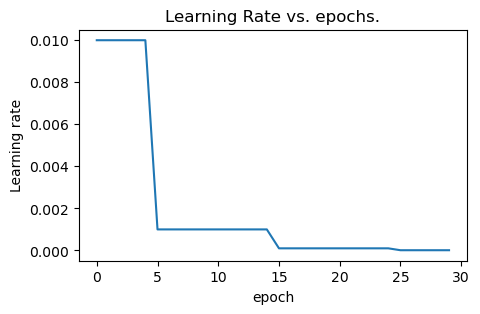

In [21]:
epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'RFMiD_Aug'
model = model_res.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'Res50_tl_{dataset}'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit(epochs,max_lr,loss,model,model_parameters,train_loader,val_loader,model_name=model_name,decay_epochs=decay_epochs)

torch.save(model_ft.state_dict(),f'{model_name}.pth')
logger(model_name,history,{'Dataset':dataset,'BaseModel':'Res50+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

## Vgg16 Custom V1

In [53]:
model_vgg = models.vgg16(pretrained=True)
for param in model_vgg.parameters():
    param.requires_grad = False
in_features = model_vgg.classifier[6].in_features


# Defining Dense top layers after the convolutional layers
model_vgg.classifier[6] = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, len(class_names)),
    )
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [54]:
numel(model_vgg,1)

2175122

[{'val_loss': 2.893192768096924, 'val_acc': 0.05909091234207153}]


100%|██████████| 131/131 [03:31<00:00,  1.62s/it]


Epoch [1], last_lr: 0.01000, train_loss: 2.7941, val_loss: 2.2666, val_acc: 0.2989
best_acc: 0.29886364936828613


100%|██████████| 131/131 [03:33<00:00,  1.63s/it]


Epoch [2], last_lr: 0.01000, train_loss: 2.4835, val_loss: 2.1486, val_acc: 0.2913
best_acc: 0.29886364936828613


100%|██████████| 131/131 [03:33<00:00,  1.63s/it]


Epoch [3], last_lr: 0.01000, train_loss: 2.3984, val_loss: 2.0198, val_acc: 0.3348
best_acc: 0.3348484933376312


100%|██████████| 131/131 [03:28<00:00,  1.59s/it]


Epoch [4], last_lr: 0.01000, train_loss: 2.3115, val_loss: 1.9548, val_acc: 0.3557
best_acc: 0.355681836605072


100%|██████████| 131/131 [03:25<00:00,  1.57s/it]


Epoch [5], last_lr: 0.01000, train_loss: 2.2714, val_loss: 1.9146, val_acc: 0.3936
best_acc: 0.39356061816215515


100%|██████████| 131/131 [03:55<00:00,  1.80s/it]


Epoch [6], last_lr: 0.00100, train_loss: 2.2621, val_loss: 1.8728, val_acc: 0.3985
best_acc: 0.39848482608795166


100%|██████████| 131/131 [03:29<00:00,  1.60s/it]


Epoch [7], last_lr: 0.00100, train_loss: 2.2324, val_loss: 1.8616, val_acc: 0.3936
best_acc: 0.39848482608795166


100%|██████████| 131/131 [03:27<00:00,  1.58s/it]


Epoch [8], last_lr: 0.00100, train_loss: 2.2743, val_loss: 1.8853, val_acc: 0.4045
best_acc: 0.40454545617103577


100%|██████████| 131/131 [03:32<00:00,  1.63s/it]


Epoch [9], last_lr: 0.00100, train_loss: 2.2352, val_loss: 1.8503, val_acc: 0.4167
best_acc: 0.4166666567325592


100%|██████████| 131/131 [03:27<00:00,  1.59s/it]


Epoch [10], last_lr: 0.00100, train_loss: 2.2314, val_loss: 1.8630, val_acc: 0.3943
best_acc: 0.4166666567325592


100%|██████████| 131/131 [03:25<00:00,  1.57s/it]


Epoch [11], last_lr: 0.00100, train_loss: 2.2058, val_loss: 1.8329, val_acc: 0.4106
best_acc: 0.4166666567325592


100%|██████████| 131/131 [03:23<00:00,  1.56s/it]


Epoch [12], last_lr: 0.00100, train_loss: 2.2295, val_loss: 1.8256, val_acc: 0.4098
best_acc: 0.4166666567325592


100%|██████████| 131/131 [03:56<00:00,  1.80s/it]


Epoch [13], last_lr: 0.00100, train_loss: 2.2272, val_loss: 1.8228, val_acc: 0.4148
best_acc: 0.4166666567325592


100%|██████████| 131/131 [03:23<00:00,  1.56s/it]


Epoch [14], last_lr: 0.00100, train_loss: 2.2004, val_loss: 1.8390, val_acc: 0.4250
best_acc: 0.42499998211860657


100%|██████████| 131/131 [03:24<00:00,  1.56s/it]


Epoch [15], last_lr: 0.00100, train_loss: 2.2149, val_loss: 1.8142, val_acc: 0.4201
best_acc: 0.42499998211860657


100%|██████████| 131/131 [03:25<00:00,  1.57s/it]


Epoch [16], last_lr: 0.00010, train_loss: 2.1663, val_loss: 1.8181, val_acc: 0.4242
best_acc: 0.42499998211860657


100%|██████████| 131/131 [03:24<00:00,  1.56s/it]


Epoch [17], last_lr: 0.00010, train_loss: 2.2141, val_loss: 1.8270, val_acc: 0.4178
best_acc: 0.42499998211860657


100%|██████████| 131/131 [03:23<00:00,  1.56s/it]


Epoch [18], last_lr: 0.00010, train_loss: 2.2176, val_loss: 1.8264, val_acc: 0.4174
best_acc: 0.42499998211860657


100%|██████████| 131/131 [03:24<00:00,  1.56s/it]


Epoch [19], last_lr: 0.00010, train_loss: 2.1918, val_loss: 1.8332, val_acc: 0.4087
best_acc: 0.42499998211860657


100%|██████████| 131/131 [03:55<00:00,  1.80s/it]


Epoch [20], last_lr: 0.00010, train_loss: 2.2084, val_loss: 1.8223, val_acc: 0.4072
best_acc: 0.42499998211860657


100%|██████████| 131/131 [03:25<00:00,  1.57s/it]


Epoch [21], last_lr: 0.00010, train_loss: 2.1999, val_loss: 1.8321, val_acc: 0.4186
best_acc: 0.42499998211860657


100%|██████████| 131/131 [03:27<00:00,  1.58s/it]


Epoch [22], last_lr: 0.00010, train_loss: 2.1958, val_loss: 1.8235, val_acc: 0.4076
best_acc: 0.42499998211860657


100%|██████████| 131/131 [03:25<00:00,  1.57s/it]


Epoch [23], last_lr: 0.00010, train_loss: 2.2009, val_loss: 1.8082, val_acc: 0.4235
best_acc: 0.42499998211860657


100%|██████████| 131/131 [03:26<00:00,  1.58s/it]


Epoch [24], last_lr: 0.00010, train_loss: 2.2093, val_loss: 1.8281, val_acc: 0.4250
best_acc: 0.42499998211860657


100%|██████████| 131/131 [03:25<00:00,  1.57s/it]


Epoch [25], last_lr: 0.00010, train_loss: 2.1700, val_loss: 1.8167, val_acc: 0.4288
best_acc: 0.42878785729408264


100%|██████████| 131/131 [03:27<00:00,  1.58s/it]


Epoch [26], last_lr: 0.00001, train_loss: 2.1942, val_loss: 1.8255, val_acc: 0.4231
best_acc: 0.42878785729408264


100%|██████████| 131/131 [03:50<00:00,  1.76s/it]


Epoch [27], last_lr: 0.00001, train_loss: 2.1801, val_loss: 1.8317, val_acc: 0.4277
best_acc: 0.42878785729408264


100%|██████████| 131/131 [03:38<00:00,  1.67s/it]


Epoch [28], last_lr: 0.00001, train_loss: 2.1852, val_loss: 1.7957, val_acc: 0.4174
best_acc: 0.42878785729408264


100%|██████████| 131/131 [03:38<00:00,  1.67s/it]


Epoch [29], last_lr: 0.00001, train_loss: 2.1797, val_loss: 1.8379, val_acc: 0.4258
best_acc: 0.42878785729408264


100%|██████████| 131/131 [03:38<00:00,  1.67s/it]


Epoch [30], last_lr: 0.00001, train_loss: 2.1802, val_loss: 1.8159, val_acc: 0.4227
best_acc: 0.42878785729408264


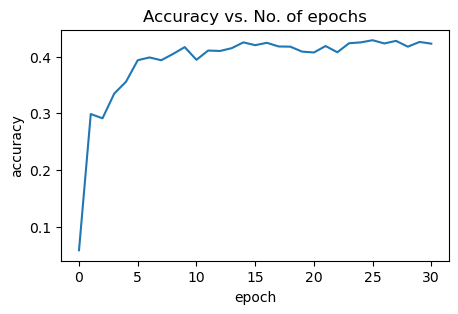

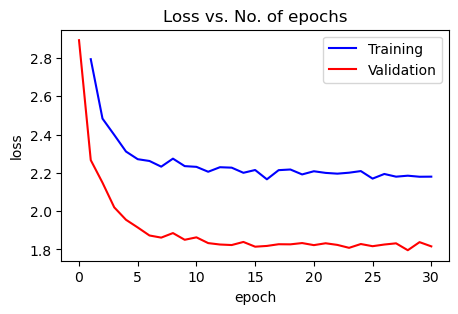

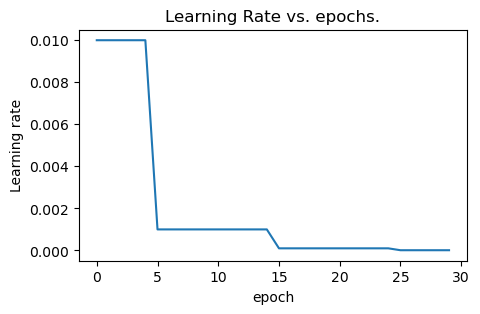

In [24]:
epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'RFMiD_Aug'
model = model_vgg.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'vggcustom_tl_{dataset}'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit(epochs,max_lr,loss,model,model_parameters,train_loader,val_loader,model_name=model_name,decay_epochs=decay_epochs)

torch.save(model_ft.state_dict(),f'{model_name}.pth')
logger(model_name,history,{'Dataset':dataset,'BaseModel':'Vgg16+custom',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

## Vgg16 custom v2

In [55]:
model_vgg_v2 = models.vgg16(pretrained=True)
for param in model_vgg_v2.parameters():
    param.requires_grad = False
in_features = model_vgg_v2.classifier[0].in_features


# Defining Dense top layers after the convolutional layers
model_vgg_v2.classifier = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, len(class_names)),
    )
print(model_vgg_v2)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [56]:
numel(model_vgg_v2,1)

12965010

[{'val_loss': 2.892914295196533, 'val_acc': 0.054924242198467255}]


100%|██████████| 131/131 [03:32<00:00,  1.62s/it]


Epoch [1], last_lr: 0.01000, train_loss: 2.6392, val_loss: 2.1184, val_acc: 0.3197
best_acc: 0.31969696283340454


100%|██████████| 131/131 [03:41<00:00,  1.69s/it]


Epoch [2], last_lr: 0.01000, train_loss: 2.2992, val_loss: 1.8557, val_acc: 0.3981
best_acc: 0.39810606837272644


100%|██████████| 131/131 [04:07<00:00,  1.89s/it]


Epoch [3], last_lr: 0.01000, train_loss: 2.1613, val_loss: 1.6551, val_acc: 0.4564
best_acc: 0.45643940567970276


100%|██████████| 131/131 [03:44<00:00,  1.71s/it]


Epoch [4], last_lr: 0.01000, train_loss: 2.0517, val_loss: 1.6086, val_acc: 0.4629
best_acc: 0.4628787636756897


100%|██████████| 131/131 [03:42<00:00,  1.70s/it]


Epoch [5], last_lr: 0.01000, train_loss: 1.9581, val_loss: 1.5241, val_acc: 0.5015
best_acc: 0.5015151500701904


100%|██████████| 131/131 [03:41<00:00,  1.69s/it]


Epoch [6], last_lr: 0.00100, train_loss: 1.9136, val_loss: 1.5126, val_acc: 0.4924
best_acc: 0.5015151500701904


100%|██████████| 131/131 [03:41<00:00,  1.69s/it]


Epoch [7], last_lr: 0.00100, train_loss: 1.8658, val_loss: 1.5204, val_acc: 0.4966
best_acc: 0.5015151500701904


100%|██████████| 131/131 [03:42<00:00,  1.70s/it]


Epoch [8], last_lr: 0.00100, train_loss: 1.7982, val_loss: 1.4951, val_acc: 0.5189
best_acc: 0.5189393758773804


100%|██████████| 131/131 [03:40<00:00,  1.69s/it]


Epoch [9], last_lr: 0.00100, train_loss: 1.8288, val_loss: 1.4539, val_acc: 0.5011
best_acc: 0.5189393758773804


100%|██████████| 131/131 [03:54<00:00,  1.79s/it]


Epoch [10], last_lr: 0.00100, train_loss: 1.7757, val_loss: 1.4624, val_acc: 0.5167
best_acc: 0.5189393758773804


100%|██████████| 131/131 [03:32<00:00,  1.62s/it]


Epoch [11], last_lr: 0.00100, train_loss: 1.7851, val_loss: 1.4286, val_acc: 0.5386
best_acc: 0.538636326789856


100%|██████████| 131/131 [03:29<00:00,  1.60s/it]


Epoch [12], last_lr: 0.00100, train_loss: 1.7627, val_loss: 1.4334, val_acc: 0.5341
best_acc: 0.538636326789856


100%|██████████| 131/131 [03:32<00:00,  1.62s/it]


Epoch [13], last_lr: 0.00100, train_loss: 1.7597, val_loss: 1.3930, val_acc: 0.5485
best_acc: 0.5484848618507385


100%|██████████| 131/131 [03:30<00:00,  1.61s/it]


Epoch [14], last_lr: 0.00100, train_loss: 1.7690, val_loss: 1.3756, val_acc: 0.5428
best_acc: 0.5484848618507385


100%|██████████| 131/131 [03:29<00:00,  1.60s/it]


Epoch [15], last_lr: 0.00100, train_loss: 1.7337, val_loss: 1.4262, val_acc: 0.5223
best_acc: 0.5484848618507385


100%|██████████| 131/131 [03:22<00:00,  1.55s/it]


Epoch [16], last_lr: 0.00010, train_loss: 1.7253, val_loss: 1.3992, val_acc: 0.5500
best_acc: 0.550000011920929


100%|██████████| 131/131 [03:35<00:00,  1.65s/it]


Epoch [17], last_lr: 0.00010, train_loss: 1.7278, val_loss: 1.3609, val_acc: 0.5606
best_acc: 0.560606062412262


100%|██████████| 131/131 [03:51<00:00,  1.76s/it]


Epoch [18], last_lr: 0.00010, train_loss: 1.7157, val_loss: 1.4035, val_acc: 0.5402
best_acc: 0.560606062412262


100%|██████████| 131/131 [03:36<00:00,  1.65s/it]


Epoch [19], last_lr: 0.00010, train_loss: 1.7510, val_loss: 1.4149, val_acc: 0.5515
best_acc: 0.560606062412262


100%|██████████| 131/131 [03:31<00:00,  1.61s/it]


Epoch [20], last_lr: 0.00010, train_loss: 1.7032, val_loss: 1.3599, val_acc: 0.5648
best_acc: 0.5647727251052856


100%|██████████| 131/131 [03:37<00:00,  1.66s/it]


Epoch [21], last_lr: 0.00010, train_loss: 1.7218, val_loss: 1.3527, val_acc: 0.5621
best_acc: 0.5647727251052856


100%|██████████| 131/131 [03:35<00:00,  1.64s/it]


Epoch [22], last_lr: 0.00010, train_loss: 1.7809, val_loss: 1.3691, val_acc: 0.5549
best_acc: 0.5647727251052856


100%|██████████| 131/131 [03:32<00:00,  1.62s/it]


Epoch [23], last_lr: 0.00010, train_loss: 1.7351, val_loss: 1.3815, val_acc: 0.5337
best_acc: 0.5647727251052856


100%|██████████| 131/131 [03:31<00:00,  1.61s/it]


Epoch [24], last_lr: 0.00010, train_loss: 1.7252, val_loss: 1.3583, val_acc: 0.5587
best_acc: 0.5647727251052856


100%|██████████| 131/131 [03:56<00:00,  1.81s/it]


Epoch [25], last_lr: 0.00010, train_loss: 1.7363, val_loss: 1.4024, val_acc: 0.5436
best_acc: 0.5647727251052856


100%|██████████| 131/131 [03:45<00:00,  1.72s/it]


Epoch [26], last_lr: 0.00001, train_loss: 1.7034, val_loss: 1.3688, val_acc: 0.5417
best_acc: 0.5647727251052856


100%|██████████| 131/131 [03:50<00:00,  1.76s/it]


Epoch [27], last_lr: 0.00001, train_loss: 1.7400, val_loss: 1.3770, val_acc: 0.5447
best_acc: 0.5647727251052856


100%|██████████| 131/131 [03:23<00:00,  1.55s/it]


Epoch [28], last_lr: 0.00001, train_loss: 1.7116, val_loss: 1.4060, val_acc: 0.5367
best_acc: 0.5647727251052856


100%|██████████| 131/131 [03:23<00:00,  1.55s/it]


Epoch [29], last_lr: 0.00001, train_loss: 1.7174, val_loss: 1.3993, val_acc: 0.5606
best_acc: 0.5647727251052856


100%|██████████| 131/131 [03:21<00:00,  1.54s/it]


Epoch [30], last_lr: 0.00001, train_loss: 1.6794, val_loss: 1.3932, val_acc: 0.5508
best_acc: 0.5647727251052856


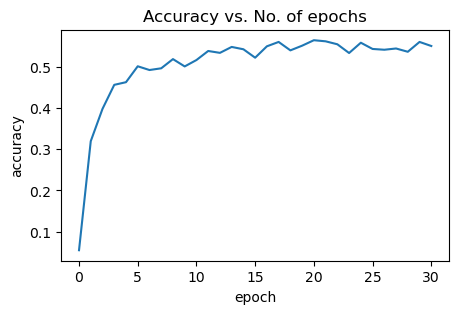

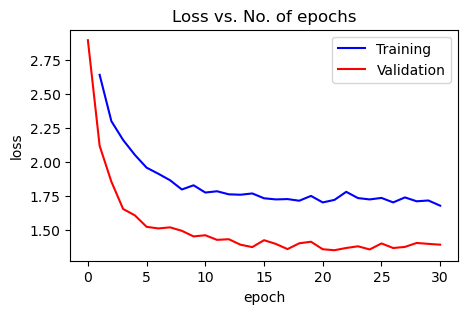

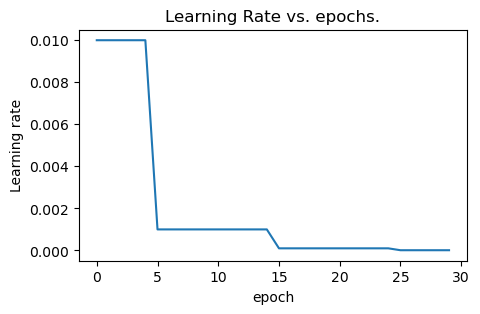

In [27]:
epochs = 30
max_lr = 1e-2
decay_epochs = [5,15,25]
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy
dataset = 'RFMiD_Aug'
model = model_vgg_v2.cuda()
model_parameters = model.parameters() # be careful here since, when using conv layers change this into list and append the conv parameters also.(I didn't do it in the previous attempts)

train_loader,val_loader = DeviceDataLoader(train_loader,torch.device('cuda')),DeviceDataLoader(val_loader,torch.device('cuda'))

model_name = f'vggcustom_v2_tl_{dataset}'
history = [evaluate(model, val_loader,loss)]
print(history)


# print(history)
history += fit(epochs,max_lr,loss,model,model_parameters,train_loader,val_loader,model_name=model_name,decay_epochs=decay_epochs)

torch.save(model_ft.state_dict(),f'{model_name}.pth')
logger(model_name,history,{'Dataset':dataset,'BaseModel':'Vgg16+custom_v2',"DA":'augmentations','max_lr':max_lr,'sched':'[10,25]','Optim':'ADAM'})

plot = Plots(history,model_name)
plot.plot_accuracies()
plot.plot_losses()
plot.plot_lrs()


# try with img.to(device) instead of DeviceDataloader might work!

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [36]:
def model_to_classification_report(model , path ,val_loader=val_loader,classes=class_names):
    y_pred_all = []
    y_true_all = []
    
    model_name = path.split('.pth')[0]
    #model = model_ft
    model.load_state_dict(torch.load(path))
    model.eval()
    model.cpu()
    
    for batch in val_loader:
        x,y = batch
        x = x.detach().cpu()
        y = y.detach().cpu()
        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1)
            y_pred = torch.flatten(y_pred)
            y_pred = y_pred.tolist()

        y = y.numpy().tolist()

        if len(y) == len(y_pred):
            for i in range(len(y)):
                y_pred_all.append(y_pred[i])
                y_true_all.append(y[i])
        else:
            print('length of y mismatched with length of y_pred !!')


    # print(len(y_pred_all))
    # print(len(y_true_all))

    print(f'Generating Classification for {model_name} ...')
    print(classification_report(y_true_all, y_pred_all))
    
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true_all, y_pred_all)
    # print(cf_matrix)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.title(f'Confusion Matrix of {model_name}', fontsize = 20) # title with fontsize 20
    plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15
    plt.show()
    # plt.savefig('output.png')

## ODIR

Generating Classification for Vgg_tl_ODIR_Augbest ...
              precision    recall  f1-score   support

           0       0.30      0.20      0.24       123
           1       0.74      0.94      0.83        86
           2       0.26      0.14      0.18       112
           3       0.49      0.41      0.45       101
           4       0.26      0.44      0.33       104
           5       0.59      0.88      0.70        90
           6       0.27      0.40      0.32        91
           7       0.36      0.09      0.14        93

    accuracy                           0.41       800
   macro avg       0.41      0.44      0.40       800
weighted avg       0.40      0.41      0.38       800



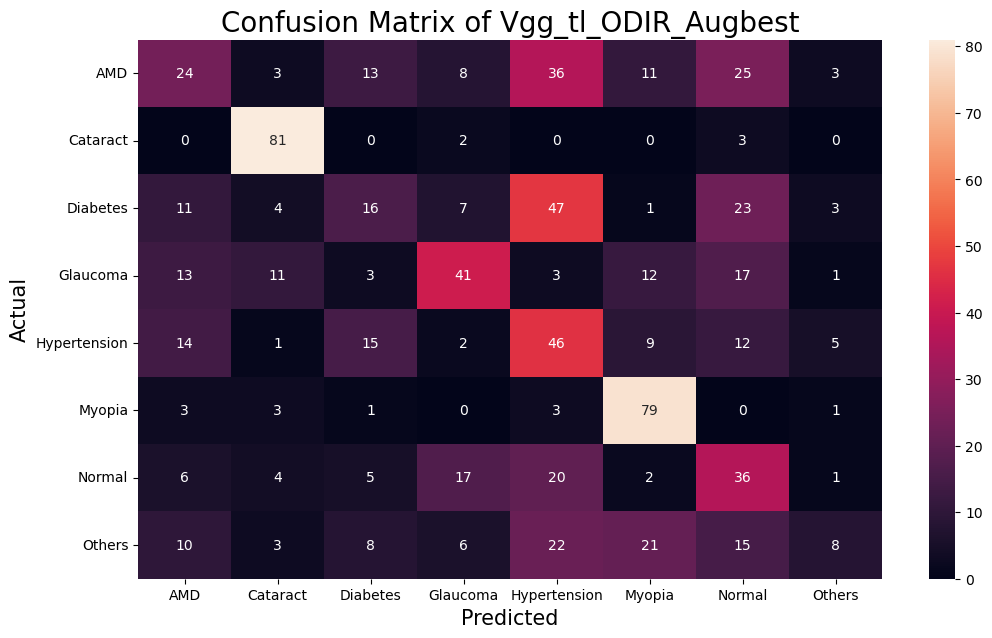

In [37]:
model_to_classification_report(model = model_ft,path='Vgg_tl_ODIR_Augbest.pth')

Generating Classification for EffNet_tl_ODIR_Augbest ...
              precision    recall  f1-score   support

           0       0.64      0.59      0.62       123
           1       0.79      0.94      0.86        86
           2       0.45      0.25      0.32       112
           3       0.62      0.81      0.70       101
           4       0.57      0.66      0.61       104
           5       0.87      0.98      0.92        90
           6       0.26      0.32      0.29        91
           7       0.62      0.38      0.47        93

    accuracy                           0.61       800
   macro avg       0.60      0.62      0.60       800
weighted avg       0.60      0.61      0.59       800



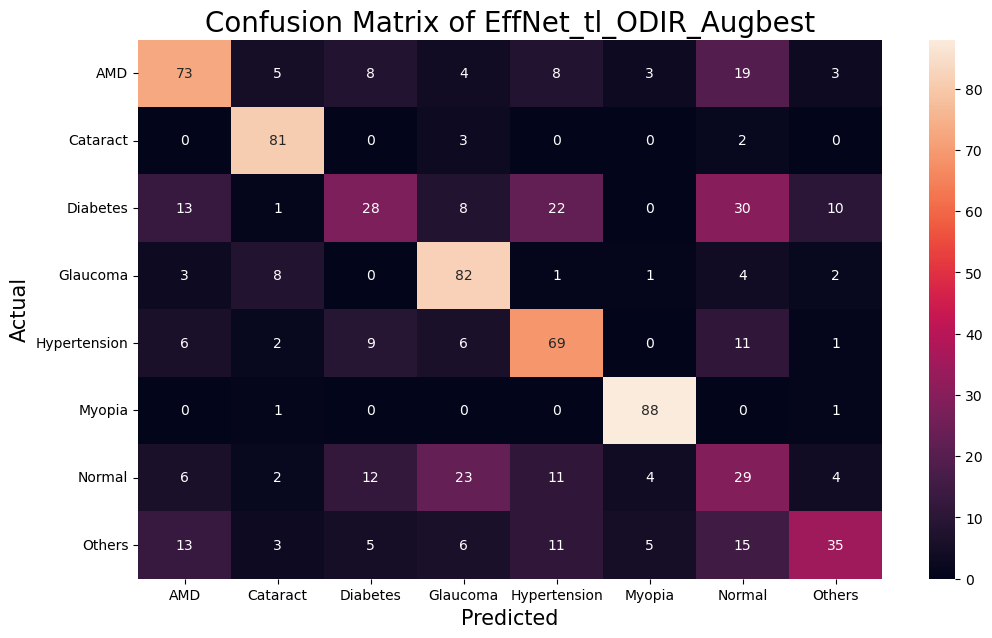

In [41]:
model_to_classification_report(model = model_transfer, path = 'EffNet_tl_ODIR_Augbest.pth') 


Generating Classification for Res50_tl_ODIR_Augbest ...
              precision    recall  f1-score   support

           0       0.74      0.62      0.67       123
           1       0.83      0.91      0.87        86
           2       0.55      0.34      0.42       112
           3       0.59      0.79      0.68       101
           4       0.56      0.71      0.63       104
           5       0.90      0.96      0.92        90
           6       0.30      0.40      0.34        91
           7       0.68      0.37      0.48        93

    accuracy                           0.63       800
   macro avg       0.64      0.64      0.63       800
weighted avg       0.64      0.63      0.62       800



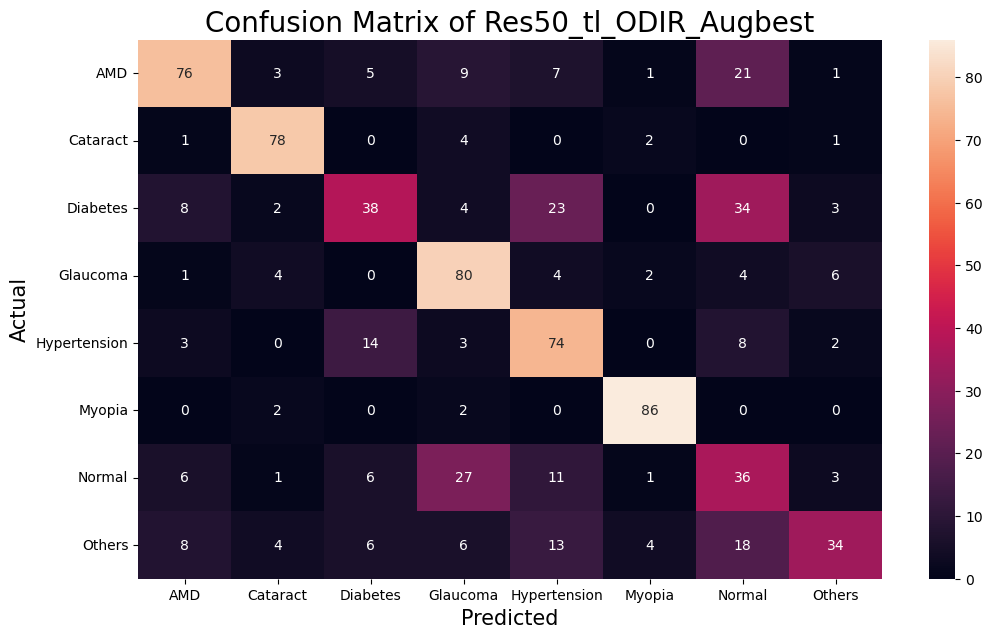

In [42]:
model_to_classification_report(model = model_res, path = 'Res50_tl_ODIR_Augbest.pth') 

Generating Classification for Res50_tl_ODIR_Aug_class_wisebest ...
              precision    recall  f1-score   support

           0       0.68      0.62      0.65       123
           1       0.86      0.91      0.88        86
           2       0.44      0.33      0.38       112
           3       0.61      0.81      0.70       101
           4       0.72      0.61      0.66       104
           5       0.88      0.94      0.91        90
           6       0.29      0.43      0.35        91
           7       0.64      0.41      0.50        93

    accuracy                           0.62       800
   macro avg       0.64      0.63      0.63       800
weighted avg       0.63      0.62      0.62       800



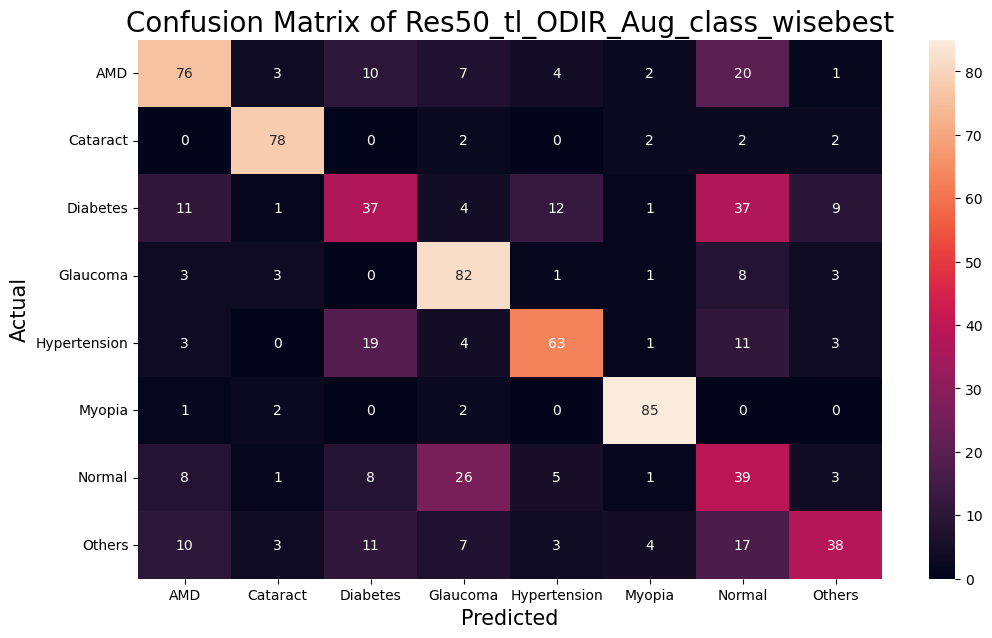

In [37]:
model_to_classification_report(model = model_res, path = 'Res50_tl_ODIR_Aug_class_wisebest.pth') 

Generating Classification for Res50_tl_ODIR_Aug_class_wise_t15best ...
              precision    recall  f1-score   support

           0       0.63      0.66      0.64       123
           1       0.84      0.90      0.87        86
           2       0.43      0.38      0.41       112
           3       0.67      0.73      0.70       101
           4       0.69      0.63      0.66       104
           5       0.92      0.93      0.93        90
           6       0.33      0.48      0.39        91
           7       0.73      0.38      0.50        93

    accuracy                           0.63       800
   macro avg       0.65      0.64      0.64       800
weighted avg       0.65      0.63      0.63       800



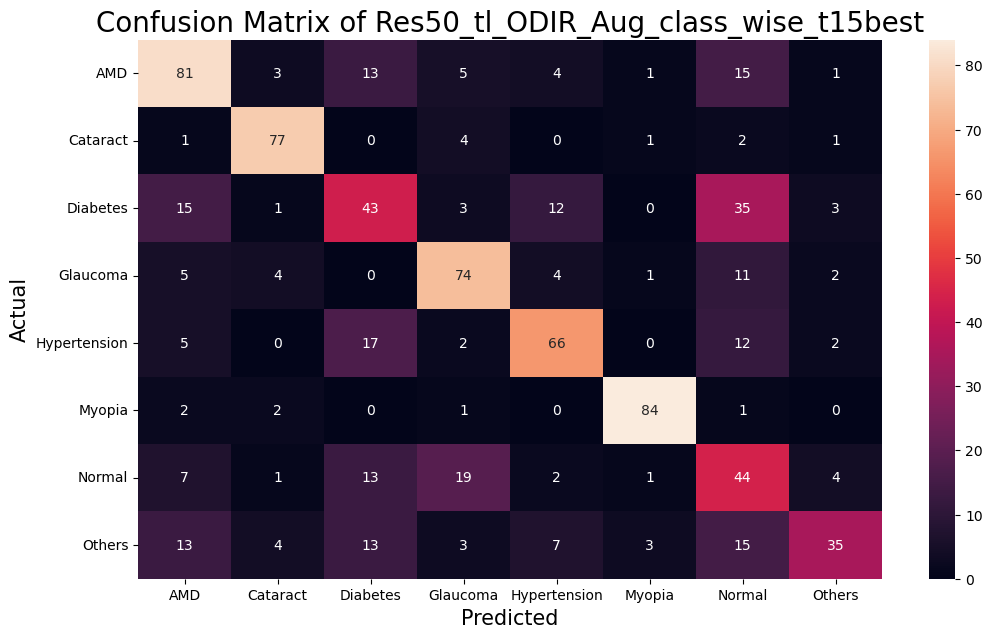

In [43]:
model_to_classification_report(model = model_res, path = 'Res50_tl_ODIR_Aug_class_wise_t15best.pth') 

Generating Classification for vggcustom_tl_ODIR_Augbest ...
              precision    recall  f1-score   support

           0       0.47      0.46      0.46       123
           1       0.86      0.84      0.85        86
           2       0.30      0.21      0.25       112
           3       0.57      0.55      0.56       101
           4       0.44      0.47      0.45       104
           5       0.75      0.93      0.83        90
           6       0.23      0.35      0.28        91
           7       0.49      0.28      0.36        93

    accuracy                           0.50       800
   macro avg       0.51      0.51      0.50       800
weighted avg       0.50      0.50      0.49       800



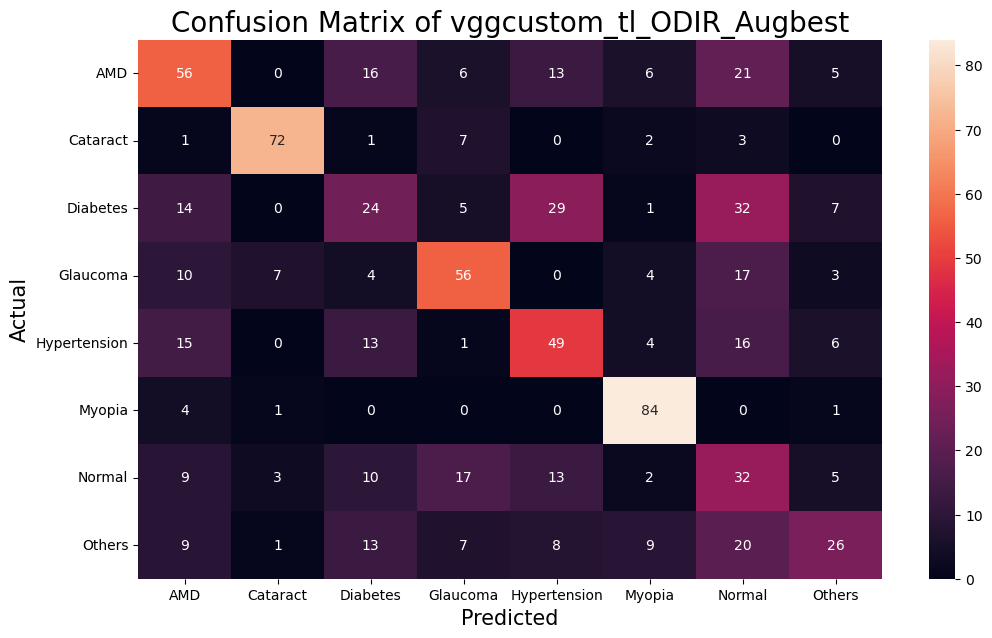

In [43]:
model_to_classification_report(model = model_vgg, path = 'vggcustom_tl_ODIR_Augbest.pth') 

Generating Classification for vggcustom_v2_tl_ODIR_Augbest ...
              precision    recall  f1-score   support

           0       0.63      0.66      0.64       123
           1       0.84      0.91      0.87        86
           2       0.44      0.16      0.24       112
           3       0.52      0.76      0.62       101
           4       0.54      0.62      0.58       104
           5       0.76      0.96      0.85        90
           6       0.25      0.33      0.29        91
           7       0.61      0.25      0.35        93

    accuracy                           0.57       800
   macro avg       0.57      0.58      0.55       800
weighted avg       0.57      0.57      0.55       800



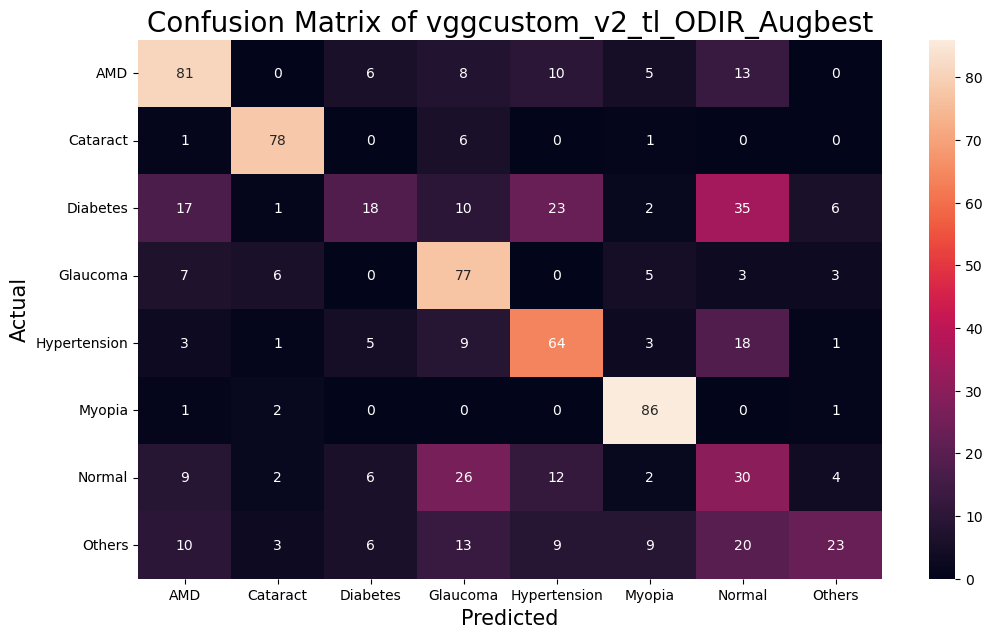

In [44]:
model_to_classification_report(model = model_vgg_v2, path = 'vggcustom_v2_tl_ODIR_Augbest.pth') 

## RFMiD

Generating Classification for Vgg_tl_RFMiD_Augbest ...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        36
           2       0.22      0.08      0.12        24
           3       0.25      0.02      0.04        42
           4       0.47      0.71      0.56        31
           5       0.19      0.28      0.22        29
           6       0.00      0.00      0.00        27
           7       0.69      0.37      0.48        30
           8       0.09      0.14      0.11        28
           9       0.83      0.14      0.23        37
          10       0.32      0.19      0.24        36
          11       0.15      0.22      0.18        27
          12       0.20      0.42      0.27        26
          13       0.00      0.00      0.00        23
          14       0.15      0.43      0.23        30
          15       0.00      0.00      0.00        30
          16       0.27   

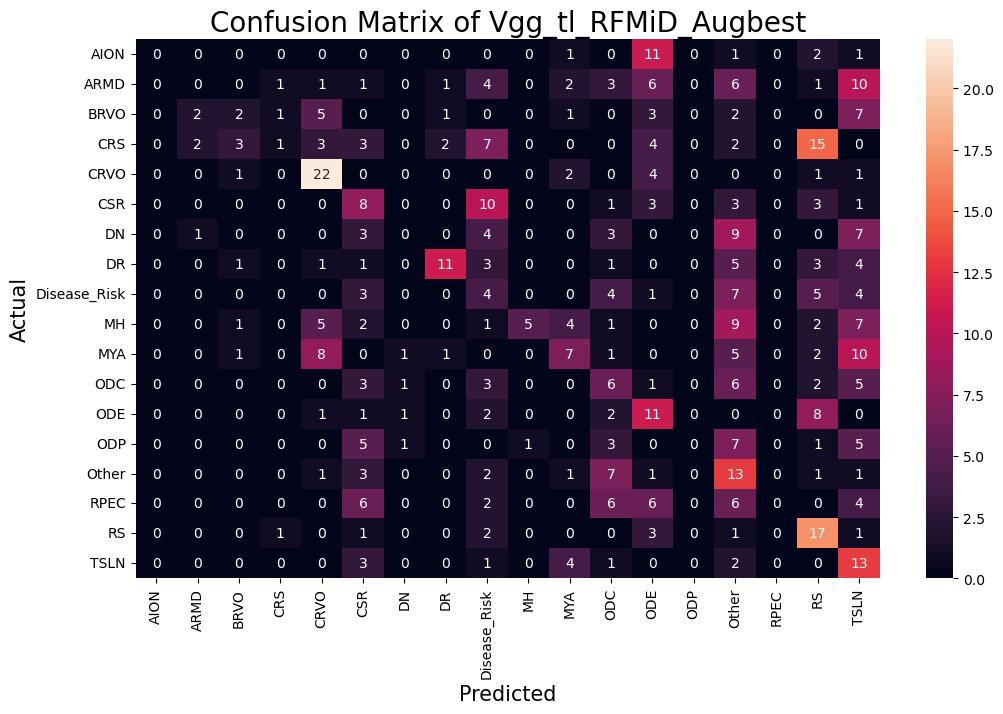

In [65]:
model_to_classification_report(model = model_ft, path = 'Vgg_tl_RFMiD_Augbest.pth') 

Generating Classification for EffNet_tl_RFMiD_Augbest ...
              precision    recall  f1-score   support

           0       0.52      0.75      0.62        16
           1       0.81      0.61      0.70        36
           2       0.43      0.25      0.32        24
           3       0.71      0.52      0.60        42
           4       0.80      0.90      0.85        31
           5       0.52      0.93      0.67        29
           6       0.27      0.11      0.16        27
           7       0.59      0.67      0.62        30
           8       0.37      0.36      0.36        28
           9       0.74      0.54      0.62        37
          10       0.70      0.83      0.76        36
          11       0.47      0.52      0.49        27
          12       0.70      0.62      0.65        26
          13       0.52      0.57      0.54        23
          14       0.49      0.70      0.58        30
          15       0.87      0.43      0.58        30
          16       0.68

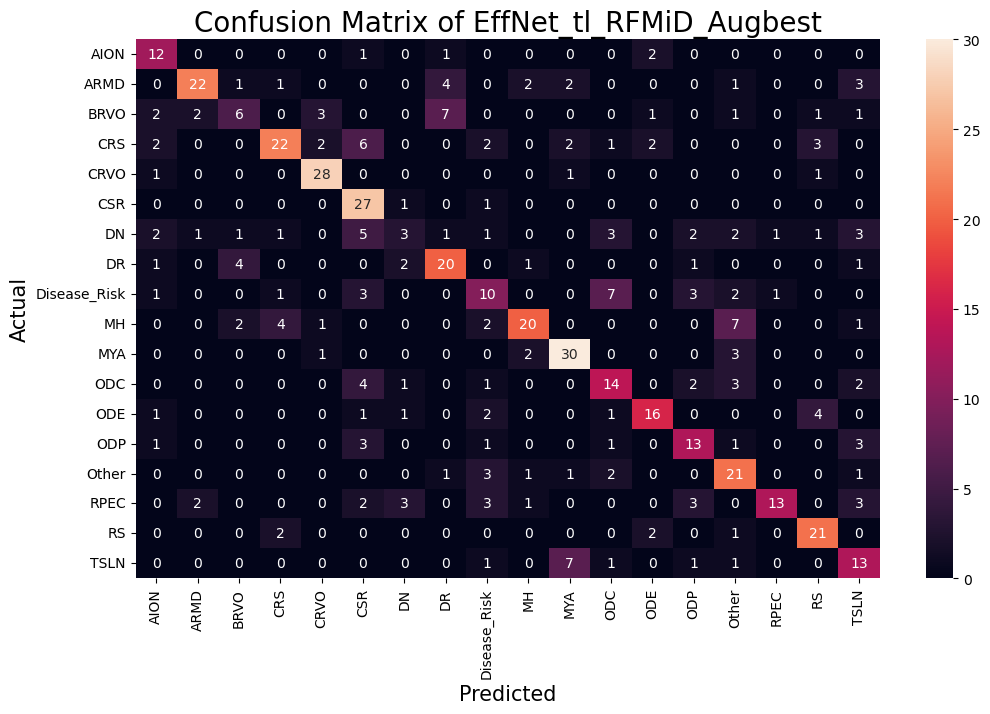

In [66]:
model_to_classification_report(model = model_transfer, path = 'EffNet_tl_RFMiD_Augbest.pth') 

Generating Classification for Res50_tl_RFMiD_Augbest ...
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        16
           1       0.67      0.67      0.67        36
           2       0.70      0.58      0.64        24
           3       0.94      0.79      0.86        42
           4       0.91      0.97      0.94        31
           5       0.73      0.83      0.77        29
           6       0.67      0.37      0.48        27
           7       0.70      0.77      0.73        30
           8       0.47      0.32      0.38        28
           9       0.66      0.51      0.58        37
          10       0.75      0.75      0.75        36
          11       0.45      0.56      0.50        27
          12       0.70      0.62      0.65        26
          13       0.83      0.65      0.73        23
          14       0.49      0.77      0.60        30
          15       0.69      0.60      0.64        30
          16       0.70 

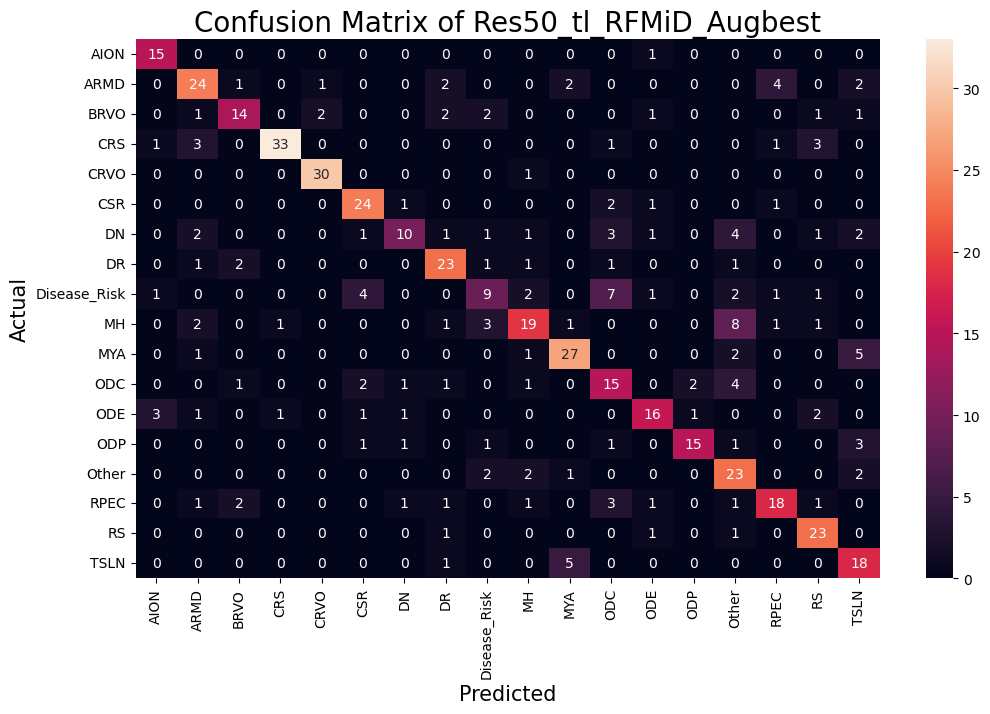

In [67]:
model_to_classification_report(model = model_res, path = 'Res50_tl_RFMiD_Augbest.pth') 

Generating Classification for vggcustom_tl_RFMiD_Augbest ...
              precision    recall  f1-score   support

           0       0.43      0.19      0.26        16
           1       0.62      0.14      0.23        36
           2       0.35      0.46      0.40        24
           3       0.76      0.31      0.44        42
           4       0.74      0.81      0.77        31
           5       0.24      0.83      0.37        29
           6       0.40      0.07      0.12        27
           7       0.47      0.57      0.52        30
           8       0.33      0.11      0.16        28
           9       0.62      0.41      0.49        37
          10       0.67      0.61      0.64        36
          11       0.24      0.44      0.31        27
          12       0.46      0.50      0.48        26
          13       0.55      0.26      0.35        23
          14       0.40      0.57      0.47        30
          15       1.00      0.10      0.18        30
          16       0

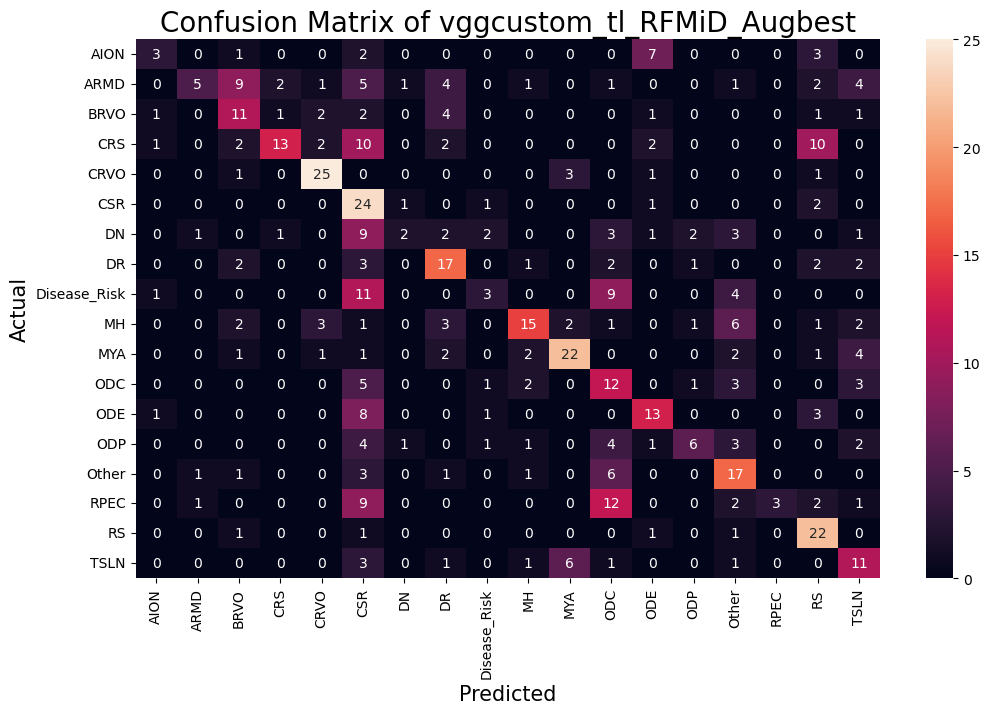

In [68]:
model_to_classification_report(model = model_vgg, path = 'vggcustom_tl_RFMiD_Augbest.pth') 

Generating Classification for vggcustom_v2_tl_RFMiD_Augbest ...
              precision    recall  f1-score   support

           0       0.31      0.50      0.38        16
           1       0.83      0.56      0.67        36
           2       0.50      0.21      0.29        24
           3       0.74      0.74      0.74        42
           4       0.79      0.84      0.81        31
           5       0.50      0.66      0.57        29
           6       0.40      0.30      0.34        27
           7       0.57      0.67      0.62        30
           8       0.32      0.29      0.30        28
           9       0.66      0.62      0.64        37
          10       0.72      0.81      0.76        36
          11       0.35      0.59      0.44        27
          12       0.44      0.42      0.43        26
          13       0.50      0.52      0.51        23
          14       0.50      0.53      0.52        30
          15       0.58      0.23      0.33        30
          16     

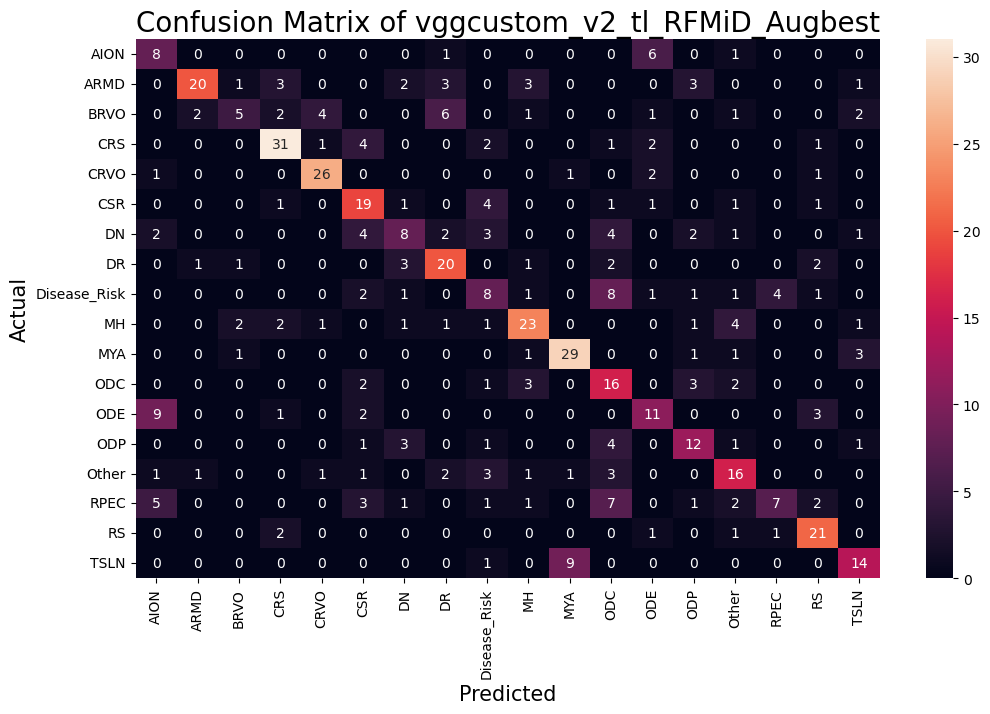

In [69]:
model_to_classification_report(model = model_vgg_v2, path = 'vggcustom_v2_tl_RFMiD_Augbest.pth') 

In [23]:
from sklearn.metrics import accuracy_score
def model_to_classification_report_classes(model , path ,val_loader=val_loader,classes=class_names):
    y_pred_all = []
    y_true_all = []
    
    model_name = path.split('.pth')[0]
    #model = model_ft
    model.load_state_dict(torch.load(path))
    model.eval()
    model.cpu()
    
    for batch in val_loader:
        x,y = batch
        x = x.detach().cpu()
        y = y.detach().cpu()
        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1)
            y_pred = torch.flatten(y_pred)
            y_pred = y_pred.tolist()

        y = y.numpy().tolist()

        if len(y) == len(y_pred):
            for i in range(len(y)):
                y_pred_all.append(y_pred[i])
                y_true_all.append(y[i])
        else:
            print('length of y mismatched with length of y_pred !!')


    # print(len(y_pred_all))
    # print(len(y_true_all))

    print(f'Generating Classification for {model_name} ...')
    # print()
    
    
    # return  {name: accuracy_score(np.array(y_true_all) == i, np.array(y_pred_all) == i) for i, name in enumerate(class_names)}
    # return classification_report(y_true_all, y_pred_all,output_dict=True)
    return y_true_all, y_pred_all
    
    # Build confusion matrix
    # cf_matrix = confusion_matrix(y_true_all, y_pred_all)
    # # print(cf_matrix)
    # df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
    #                     columns = [i for i in classes])
    # plt.figure(figsize = (12,7))
    # sn.heatmap(df_cm, annot=True)
    # plt.title(f'Confusion Matrix of {model_name}', fontsize = 20) # title with fontsize 20
    # plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
    # plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15
    # plt.show()
    # plt.savefig('output.png')

In [24]:
y_true_all, y_pred_all = model_to_classification_report_classes(model = model_res, path = 'Res50_tl_ODIR_Aug_class_wise_t15best.pth') 

Generating Classification for Res50_tl_ODIR_Aug_class_wise_t15best ...


In [29]:
from torchmetrics.classification import MulticlassF1Score
target = torch.tensor(y_true_all)
preds = torch.tensor(y_pred_all)
metric = MulticlassF1Score(num_classes=8)
metric(preds, target)

mcf1s = MulticlassF1Score(num_classes=8, average=None)
mcf1s(preds, target)

tensor([0.6429, 0.8652, 0.4076, 0.6981, 0.6633, 0.9282, 0.3894, 0.4965])

In [89]:
y_pred_all = []
y_true_all = []

path = 'vggcustom_v2_tl_ODIR_Augbest.pth'
model_name = path.split('.pth')[0]
#model = model_ft
model.load_state_dict(torch.load(path))
model.eval()
model.cpu()


('data/RFMiD_Aug_Train/AION\\1051.png', 0)
0


In [126]:
from PIL import Image
import os

In [124]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def pre_image(image_path,model):
   img = Image.open(image_path)
   mean = [0.5]*3#[0.485, 0.456, 0.406] 
   std = [0.5]*3#[0.229, 0.224, 0.225]
   transform_norm = transforms.Compose([transforms.Resize(255), # define transforms
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])
   # get normalized image
   img_normalized = transform_norm(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   # input = Variable(image_tensor)
   img_normalized = img_normalized.to('cpu')
   # print(img_normalized.shape)
   with torch.no_grad():
      model.eval()  
      output = model(img_normalized)
     # print(output)
      index = output.data.cpu().numpy().argmax()
      classes = class_names
      class_name = classes[index]
      return class_name

In [166]:
# model_name = path.split('.pth')[0]
model = model_res
model.load_state_dict(torch.load('Res50_tl_RFMiD_Augbest.pth'))
model.eval()
model.cpu()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [167]:
with open('rfmid_pred_res50.csv','a') as f:  
    pth = 'data/RFMiD_pure/Training'
    for clas in os.listdir(os.path.join(pth)):
        print(clas)
        for img in tqdm(os.listdir(os.path.join(pth,clas))):
            path = os.path.join(pth,clas,img) 
            pred = pre_image(path,model=model)
            f.write(f'{path}, {pred}, {clas} \n')        

AION


100%|██████████| 13/13 [00:02<00:00,  5.85it/s]


ARMD


100%|██████████| 34/34 [00:09<00:00,  3.78it/s]


BRVO


100%|██████████| 54/54 [00:11<00:00,  4.83it/s]


CRS


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


CRVO


100%|██████████| 26/26 [00:04<00:00,  5.54it/s]


CSR


100%|██████████| 32/32 [00:05<00:00,  5.48it/s]


Disease_Risk


100%|██████████| 401/401 [01:28<00:00,  4.51it/s]


DN


100%|██████████| 89/89 [00:16<00:00,  5.32it/s]


DR


100%|██████████| 240/240 [00:54<00:00,  4.41it/s]


MH


100%|██████████| 180/180 [00:39<00:00,  4.59it/s]


MYA


100%|██████████| 46/46 [00:11<00:00,  4.11it/s]


ODC


100%|██████████| 119/119 [00:21<00:00,  5.54it/s]


ODE


100%|██████████| 52/52 [00:09<00:00,  5.31it/s]


ODP


100%|██████████| 17/17 [00:03<00:00,  4.37it/s]


Other


100%|██████████| 926/926 [02:07<00:00,  7.28it/s]


RPEC


100%|██████████| 15/15 [00:02<00:00,  6.00it/s]


RS


100%|██████████| 39/39 [00:06<00:00,  6.00it/s]


TSLN


100%|██████████| 23/23 [00:06<00:00,  3.72it/s]


# RFMiD
## model_ft 
- [ ] 'data/RFMID_pure/Training/AION/1051.png' AION RS 
- [ ] 'data/RFMID_pure/Training/AION/954.png' AION ODE
- [ ] 'data/RFMID_pure/Training/DR/1037.png' DR ODE
- [x] 'data/RFMID_pure/Training/DR/102.png' DR DR
- [ ] 'data/RFMID_pure/Training/Disease_Risk/1018.png' Normal/Disesae Risk Normal
- [ ] 'data/RFMID_pure/Training/CSR/592.png' CSR CSR
- [ ] 'data/RFMID_pure/Training/CSR/609.png' CSR RS
## Resnet50
- [ ] 'data/RFMID_pure/Training/AION/1051.png' AION AION
- [ ] 'data/RFMID_pure/Training/AION/954.png' AION AION
- [ ] 'data/RFMID_pure/Training/DR/1037.png' DR DN
- [x] 'data/RFMID_pure/Training/DR/102.png' DR DR
- [ ] 'data/RFMID_pure/Training/Disease_Risk/1018.png' Normal/Disesae Risk Normal
- [ ] 'data/RFMID_pure/Training/CSR/592.png' CSR CSR
- [ ] 'data/RFMID_pure/Training/CSR/609.png' CSR CSR
- [ ] 'data/RFMID_pure/Training/MH/1019.png' MH MH
- [ ] 'data/RFMID_pure/Training/MH/1076.png' MH BRVO
- [ ] 'data/RFMID_pure/Training/ODP/1688.png' ODP ODC

In [97]:
f = open("test_y", "w")
for ( samples_fname,batch,) in enumerate(val_loader,0):
    print(len(batch))
    images, labels = batch
    outputs = model(images)
    pred = torch.max(outputs, 1)[1]
    f.write("\n".join([
        ", ".join(x)
        for x in zip(map(str, pred.cpu().tolist()), samples_fname)
    ]) + "\n")
f.close()

2


TypeError: 'int' object is not iterable

In [105]:
val_loader.

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


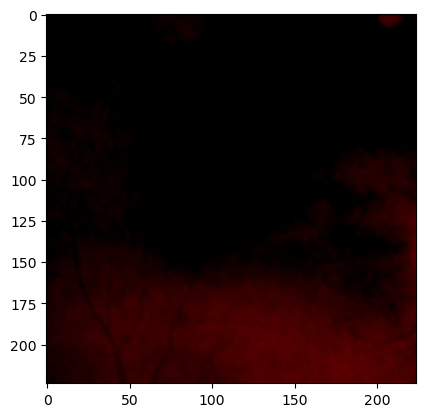

In [88]:
plt.imshow(x[0].cpu().permute(1,2,0).numpy())